In [53]:
import awkward as ak
import glob
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import networkx as nx

from utils.visualization_utils import *


%matplotlib inline

#filename = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv4Sample/FlatPt/CloseByGamma0PU/ntuples_10_600/new_ntuples_15043323_86.root"
#filename = '/eos/home-j/jejarosl/test_sample_pion140pu/new_ntuples_15459280_525.root'
#filename = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv4Sample/GNNTraining/SingleGamma140PU/ntuples_10_600/new_ntuples_15459279_533.root"
filename = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv4Sample/CMSSW_13_X/GNNTraining/CloseByPion0PU/ntuples_10_600/new_ntuples_15643818_42.root"

In [54]:
 file = uproot.open(filename)

In [55]:
file.keys()

['ticlNtuplizer;1',
 'ticlNtuplizer/tracksters;1',
 'ticlNtuplizer/clusters;1',
 'ticlNtuplizer/graph;1',
 'ticlNtuplizer/candidates;1',
 'ticlNtuplizer/trackstersMerged;1',
 'ticlNtuplizer/associations;1',
 'ticlNtuplizer/simtrackstersSC;1',
 'ticlNtuplizer/simtrackstersCP;1',
 'ticlNtuplizer/fineSimTracksters;1',
 'ticlNtuplizer/tracks;1',
 'ticlNtuplizer/simTICLCandidate;1']

In [155]:
tracks = file["ticlNtuplizer/tracks"]
tracksters = file["ticlNtuplizer/tracksters"]
simtracksters = file["ticlNtuplizer/simtrackstersSC"]
simtrackstersCP = file["ticlNtuplizer/simtrackstersCP"]
ass = file["ticlNtuplizer/associations"]
gra = file["ticlNtuplizer/graph"]
cand = file["ticlNtuplizer/candidates"]
lc = file["ticlNtuplizer/clusters"]

In [57]:
lc.keys()

['seedID',
 'energy',
 'correctedEnergy',
 'correctedEnergyUncertainty',
 'position_x',
 'position_y',
 'position_z',
 'position_eta',
 'position_phi',
 'cluster_layer_id',
 'cluster_type',
 'cluster_time',
 'cluster_timeErr',
 'cluster_local_density',
 'cluster_radius',
 'cluster_number_of_hits']

In [156]:
trk_data = tracksters.arrays(["NTracksters", "raw_energy","raw_em_energy","barycenter_x","barycenter_y",
                              "barycenter_z","eVector0_x", "eVector0_y","eVector0_z","EV1","EV2","EV3",
                              "vertices_indexes", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "vertices_x", "vertices_y",
                              "vertices_z", "vertices_energy", "layer_cluster_seed"])
gra_data = gra.arrays(["linked_inners", "linked_outers"])
ass_data = ass.arrays(["tsCLUE3D_recoToSim_SC", "tsCLUE3D_recoToSim_SC_score",
                       "tsCLUE3D_simToReco_SC", "tsCLUE3D_simToReco_SC_score",
                       "tsCLUE3D_simToReco_SC_sharedE", "tsCLUE3D_recoToSim_SC_sharedE"])

cand_data = cand.arrays(["tracksters_in_candidate"])
lc_data = lc.arrays(['position_x', 'position_y', 'position_z', 'energy'])
try:
    simtrackstersSC_data = simtracksters.arrays(["stsSC_raw_energy", 'stsSC_boundaryPx', 'stsSC_boundaryPy', 'stsSC_boundaryPz'])
    simtrackstersCP_data = simtrackstersCP.arrays(["stsCP_raw_energy", 'stsCP_boundaryPx', 'stsCP_boundaryPy', 'stsCP_boundaryPz'])
    
except Exception:
    simtrackstersSC_data = simtracksters.arrays(["raw_energy", 'boundaryPx', 'boundaryPy', 'boundaryPz'])
    simtrackstersCP_data = simtrackstersCP.arrays(["raw_energy", 'boundaryPx', 'boundaryPy', 'boundaryPz'])

In [157]:
def get_major_PU_tracksters(
    reco2sim,
    sim_raw_energy,
    score_threshold=0.2,
    energy_fraction_threshold=0.3
):
    # assuming only one simtrackster to keep things easy
    big = []

    for recoT_idx, (sim_indexes, shared_energies, scores) in enumerate(reco2sim):
        for simT_idx, shared_energy, score in zip(sim_indexes, shared_energies, scores):
            # 2 goals here:
            # - find the trackster with >50% shared energy
            # - find the tracksters with < 0.2 score
            if score > score_threshold: continue
            
            st_energy = sim_raw_energy[simT_idx]
            st_fraction = shared_energy / st_energy
            
            if st_fraction > energy_fraction_threshold:
                big.append(recoT_idx)

    return big

513


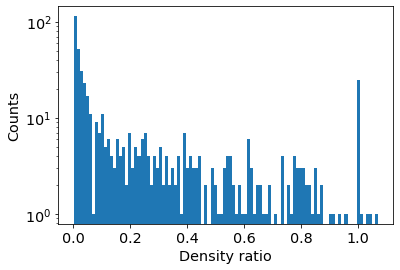

In [67]:
# make histogram on 20 events, make ration between the seed density and the rest
fig = plt.figure()
num_lc = 0
density = []
for ev in range(20):
    reco2sim_index = ass_data[ev].tsCLUE3D_recoToSim_SC
    reco2sim_score = ass_data[ev].tsCLUE3D_recoToSim_SC_score
    reco2sim_sharedE = ass_data[ev].tsCLUE3D_recoToSim_SC_sharedE
    try:
        sim_raw_energy = simtrackstersSC_data[ev].stsSC_raw_energy
    except Exception:
        sim_raw_energy = simtrackstersSC_data[ev].raw_energy
    
    bigTracksters = get_major_PU_tracksters(
        zip(reco2sim_index, reco2sim_sharedE, reco2sim_score),
        sim_raw_energy,
        )
    #print(bigTracksters)
    
    # find index of lcs belonging to major tracksters
    for bT in bigTracksters:
        vi_big = trk_data[ev].vertices_indexes[bT]
        seed_lc_idx = trk_data[ev].layer_cluster_seed[bT]
    
        ev_density = list(lc["energy"].array()[ev][vi_big]) #list(lc["cluster_local_density"].array()[ev][vi_big])
        #print(seed_lc_idx)
        seed_density = lc["energy"].array()[ev][seed_lc_idx]
    
        max_density = max(ev_density)
        density = density + list(np.array(ev_density) / seed_density)
        num_lc += len(ev_density)
    
final_density = np.clip(np.array(density).flatten(), 0, 1000)
#print(final_density)
plt.hist(final_density, bins=100)

plt.xlabel('Density ratio')
plt.ylabel('Counts')
plt.yscale('log')
print(num_lc)
plt.show()

513


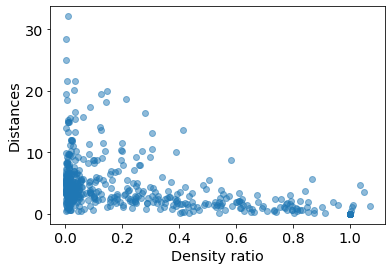

In [69]:
# same thing, not as a histogram, but distance between the seed and the lc
fig = plt.figure()
num_lc = 0
density, distances = [], []
for ev in range(20):
    reco2sim_index = ass_data[ev].tsCLUE3D_recoToSim_SC
    reco2sim_score = ass_data[ev].tsCLUE3D_recoToSim_SC_score
    reco2sim_sharedE = ass_data[ev].tsCLUE3D_recoToSim_SC_sharedE
    reco2sim_sharedE = ass_data[ev].tsCLUE3D_recoToSim_SC_sharedE
    try:
        sim_raw_energy = simtrackstersSC_data[ev].stsSC_raw_energy
    except Exception:
        sim_raw_energy = simtrackstersSC_data[ev].raw_energy
    
    bigTracksters = get_major_PU_tracksters(
        zip(reco2sim_index, reco2sim_sharedE, reco2sim_score),
        sim_raw_energy,
        )
    #print(bigTracksters)
    
    # find index of lcs belonging to major tracksters
    for bT in bigTracksters:
        vi_big = trk_data[ev].vertices_indexes[bT]
        seed_lc_idx = trk_data[ev].layer_cluster_seed[bT]
        
        # distance in x-y plane
        pos_x = lc["position_x"].array()[ev][vi_big]
        pos_y = lc["position_y"].array()[ev][vi_big]
        pos_z = lc["position_z"].array()[ev][vi_big]
        
        pos_seed_x = lc["position_x"].array()[ev][seed_lc_idx]
        pos_seed_y = lc["position_y"].array()[ev][seed_lc_idx]
        pos_seed_z = lc["position_z"].array()[ev][seed_lc_idx]
    
        dist = np.sqrt((np.array(pos_x)-np.array(pos_seed_x))**2 + (np.array(pos_y)-np.array(pos_seed_y))**2)
    
        ev_density = list(lc["energy"].array()[ev][vi_big]) #list(lc["cluster_local_density"].array()[ev][vi_big])
        #print(seed_lc_idx)
        seed_density = lc["energy"].array()[ev][seed_lc_idx]
    
        max_density = max(ev_density)
        density = density + list(np.array(ev_density) / seed_density)
        distances = distances + list(dist)
        num_lc += len(ev_density)
    
final_density = np.clip(np.array(density).flatten(), 0, 1000)
#print(final_density)
plt.scatter(final_density, distances, alpha=0.5)

plt.xlabel('Density ratio')
plt.ylabel('Distances')
#plt.yscale('log')
print(num_lc)
plt.show()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
513


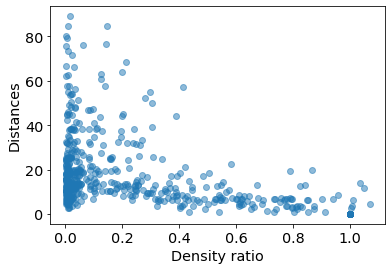

In [79]:
# same thing, not as a histogram, but distance between the seed and the lc
fig = plt.figure()
num_lc = 0
density, distances = [], []
for ev in range(20):
    reco2sim_index = ass_data[ev].tsCLUE3D_recoToSim_SC
    reco2sim_score = ass_data[ev].tsCLUE3D_recoToSim_SC_score
    reco2sim_sharedE = ass_data[ev].tsCLUE3D_recoToSim_SC_sharedE
    reco2sim_sharedE = ass_data[ev].tsCLUE3D_recoToSim_SC_sharedE
    try:
        sim_raw_energy = simtrackstersSC_data[ev].stsSC_raw_energy
    except Exception:
        sim_raw_energy = simtrackstersSC_data[ev].raw_energy
    
    bigTracksters = get_major_PU_tracksters(
        zip(reco2sim_index, reco2sim_sharedE, reco2sim_score),
        sim_raw_energy,
        )
    #print(bigTracksters)
    
    # find index of lcs belonging to major tracksters
    for bT in bigTracksters:
        vi_big = trk_data[ev].vertices_indexes[bT]
        seed_lc_idx = trk_data[ev].layer_cluster_seed[bT]
        
        # distance in x-y plane
        pos_x = lc["position_x"].array()[ev][vi_big]
        pos_y = lc["position_y"].array()[ev][vi_big]
        pos_z = lc["position_z"].array()[ev][vi_big]
        
        pos_seed_x = lc["position_x"].array()[ev][seed_lc_idx]
        pos_seed_y = lc["position_y"].array()[ev][seed_lc_idx]
        pos_seed_z = lc["position_z"].array()[ev][seed_lc_idx]
    
        dist = np.sqrt((np.array(pos_x)-np.array(pos_seed_x))**2 + (np.array(pos_y)-np.array(pos_seed_y))**2 
                       + (np.array(pos_z)-np.array(pos_seed_z))**2)
    
        ev_density = list(lc["energy"].array()[ev][vi_big]) #list(lc["cluster_local_density"].array()[ev][vi_big])
        #print(seed_lc_idx)
        seed_density = lc["energy"].array()[ev][seed_lc_idx]
    
        max_density = max(ev_density)
        density = density + list(np.array(ev_density) / seed_density)
        distances = distances + list(dist)
        num_lc += len(ev_density)
    
final_density = np.clip(np.array(density).flatten(), 0, 1000)
#print(final_density)
plt.scatter(final_density, distances, alpha=0.5)

plt.xlabel('Density ratio')
plt.ylabel('Distances')
#plt.yscale('log')
print(num_lc)
plt.show()

In [151]:
# # plot the comparison PCA vs two segments
# fig = plt.figure()
# num_lc = 0
# density = []
# for ev in range(20):
#     reco2sim_index = ass_data[ev].tsCLUE3D_recoToSim_SC
#     reco2sim_score = ass_data[ev].tsCLUE3D_recoToSim_SC_score
#     reco2sim_sharedE = ass_data[ev].tsCLUE3D_recoToSim_SC_sharedE
#     try:
#         sim_raw_energy = simtrackstersSC_data[ev].stsSC_raw_energy
#     except Exception:
#         sim_raw_energy = simtrackstersSC_data[ev].raw_energy
    
#     bigTracksters = get_major_PU_tracksters(
#         zip(reco2sim_index, reco2sim_sharedE, reco2sim_score),
#         sim_raw_energy,
#         )
#     print(bigTracksters)
    
#     lcx = lc_data.position_x[ev]
#     lcy = lc_data.position_y[ev]
#     lcz = lc_data.position_z[ev]
#     lce = lc_data.energy[ev]
    
#     # find index of lcs belonging to major tracksters
#     for bT in bigTracksters:
        
#         vxt = vx[ev][bT]
#         vyt = vy[ev][bT]
#         vzt = vz[ev][bT]
#         vet = ve[ev][bT]
#         vit = vi[ev][bT]
        
#         print(simtrackstersSC_data[ev])
        
#         p_vector = np.array([simtrackstersSC_data[ev].boundaryPx[bT], simtrackstersSC_data[ev].boundaryPy[bT], simtrackstersSC_data[ev].boundaryPz[bT]])
        
#         seed_lc_idx = trk_data.layer_cluster_seed[ev][bT]
        
#         seed_x = lcx[seed_lc_idx]
#         seed_y = lcy[seed_lc_idx]
#         seed_z = lcz[seed_lc_idx]
        
#         vz_seed = lc_data.position_z[ev][seed_lc_idx]
#         pca_lower_z = WPCA(n_components=3)        
#         positions_lower_z = np.array((vxt[vzt <= vz_seed], vyt[vzt <= vz_seed], vzt[vzt <= vz_seed])).T
        
#         vet_array_lower_z = np.array(vet[vzt <= vz_seed]).reshape(-1,1)
#         vet_array_lower_z = np.tile(vet_array_lower_z,(1, 3))
        
#         pca_lower_z.fit(positions_lower_z, weights = vet_array_lower_z)
        
#         component_lower_z = pca_lower_z.components_[0]
        
#         print(component_lower_z)
        
#         seed_coord = np.array([lcx[seed_lc_idx], lcy[seed_lc_idx], lcz[seed_lc_idx]])

#         if components_lower_z[0][2] < 0:
            
#             lower_segment_end = np.array([seed_x+components_lower_z[0][0],
#                                 seed_y+components_lower_z[0][1],
#                                 seed_z+components_lower_z[0][2]])
#         else:
            
#             lower_segment_end = np.array([seed_x-components_lower_z[0][0],
#                                 seed_y-components_lower_z[0][1],
#                                 seed_z-components_lower_z[0][2]])
        
#         vi_big = trk_data[ev].vertices_indexes[bT]
#         seed_lc_idx = trk_data[ev].layer_cluster_seed[bT]
    
#         ev_density = list(lc["energy"].array()[ev][vi_big]) #list(lc["cluster_local_density"].array()[ev][vi_big])
#         #print(seed_lc_idx)
#         seed_density = lc["energy"].array()[ev][seed_lc_idx]
    
#         max_density = max(ev_density)
#         density = density + list(np.array(ev_density) / seed_density)
#         num_lc += len(ev_density)
    
# final_density = np.clip(np.array(density).flatten(), 0, 1000)
# #print(final_density)
# plt.hist(final_density, bins=100)

# plt.xlabel('Density ratio')
# plt.ylabel('Counts')
# plt.yscale('log')
# print(num_lc)
# plt.show()

[0]
{raw_energy: [105], boundaryPx: [-999], boundaryPy: [-999], boundaryPz: [-999]}
[ 0.21728028 -0.02519243 -0.97578411]
[0]
{raw_energy: [513], boundaryPx: [-999], boundaryPy: [-999], boundaryPz: [-999]}
[-0.11476882 -0.24945356  0.96156177]
[2]
{raw_energy: [335], boundaryPx: [-999], boundaryPy: [-999], boundaryPz: [-999]}


ValueError: in NumpyArray attempting to get 2, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/libawkward/array/NumpyArray.cpp#L1215)

<Figure size 1080x360 with 0 Axes>

In [174]:
vx = trk_data.vertices_x
vy = trk_data.vertices_y
vz = trk_data.vertices_z
ve = trk_data.vertices_energy
vi = trk_data.vertices_indexes

try:
    vx_sim = simtracksters["stsSC_vertices_x"].array()
    vy_sim = simtracksters["stsSC_vertices_y"].array()
    vz_sim = simtracksters["stsSC_vertices_z"].array()
    ve_sim = simtracksters["stsSC_vertices_energy"].array()
except Exception:
    vx_sim = simtracksters["vertices_x"].array()
    vy_sim = simtracksters["vertices_y"].array()
    vz_sim = simtracksters["vertices_z"].array()
    ve_sim = simtracksters["vertices_energy"].array()

bx = trk_data.barycenter_x
by = trk_data.barycenter_y
bz = trk_data.barycenter_z
be = trk_data.raw_energy

try:
    bx_sim = simtracksters["stsSC_barycenter_x"].array()
    by_sim = simtracksters["stsSC_barycenter_y"].array()
    bz_sim = simtracksters["stsSC_barycenter_z"].array()
    be_sim = simtracksters["stsSC_raw_energy"].array()
except Exception:
    bx_sim = simtracksters["barycenter_x"].array()
    by_sim = simtracksters["barycenter_y"].array()
    bz_sim = simtracksters["barycenter_z"].array()
    be_sim = simtracksters["raw_energy"].array()

In [82]:
reco2sim_index = ass_data.tsCLUE3D_recoToSim_SC
reco2sim_score = ass_data.tsCLUE3D_recoToSim_SC_score
reco2sim_sharedE = ass_data.tsCLUE3D_recoToSim_SC_sharedE
try:
    sim_raw_energy = simtrackstersSC_data.stsSC_raw_energy
except Exception:
    sim_raw_energy = simtrackstersSC_data.raw_energy

In [83]:
ev = 0

bigTracksters = get_major_PU_tracksters(
    zip(reco2sim_index[ev], reco2sim_sharedE[ev], reco2sim_score[ev]),
    sim_raw_energy[ev],
)

In [84]:
bigTracksters

[0]

In [85]:
def find_dist_to_closest_edge(point, edges, far=False):
    """
    point: np.array (x,y,z)
    edges: dictionary
    
    """
    min_dist = np.inf
    min_edge = None
    closest_point = None
    closest_endpoint = None
    closest_endpoint_id = None
    
    for edge, (segment_start, segment_end) in edges.items():
        
        if far: 
            dist, closest_point_tmp, closest_endpoint_tmp, closest_endpoint_id_tmp, far_endpoint, far_endpoint_id = distance_point_to_segment(point, segment_start, segment_end, edge, far=far)
        else:
            dist, closest_point_tmp, closest_endpoint_tmp, closest_endpoint_id_tmp = distance_point_to_segment(point, segment_start, segment_end, edge, far=far)
        
        if dist < min_dist:
            min_dist = dist
            min_edge = edge
            closest_point = closest_point_tmp
            closest_endpoint = closest_endpoint_tmp
            closest_endpoint_id = closest_endpoint_id_tmp
        
    if far:
        return min_dist, min_edge, closest_point, closest_endpoint, closest_endpoint_id, far_endpoint, far_endpoint_id
            
    return min_dist, min_edge, closest_point, closest_endpoint, closest_endpoint_id

def distance_point_to_segment(point, segment_start, segment_end, edge, far=False):
    """
    `point` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    point_vector = point - segment_start
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    if projection <= 0:
        if far:
            return np.linalg.norm(point_vector), segment_start, segment_start, edge[0], segment_end, edge[1] 
        return np.linalg.norm(point_vector), segment_start, segment_start, edge[0]
    elif projection > 1:
        if far:
             return np.linalg.norm(point - segment_end), segment_end, segment_end, edge[1], segment_start, edge[0]
            
        return np.linalg.norm(point - segment_end), segment_end, segment_end, edge[1]
    else:
        closest_point = segment_start + projection * segment_vector
        closest_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else segment_end
        closest_endpoint_id = edge[0] if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else edge[1]
        
        if far:
            far_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) > np.linalg.norm(closest_point - segment_end) else segment_end
            far_endpoint_id = edge[0] if np.linalg.norm(closest_point - segment_start) > np.linalg.norm(closest_point - segment_end) else edge[1]
            return np.linalg.norm(point - closest_point), closest_point, closest_endpoint, closest_endpoint_id, far_endpoint, far_endpoint_id
        return np.linalg.norm(point - closest_point), closest_point, closest_endpoint, closest_endpoint_id
    
def explored_nodes_affected(nodes, edges, DST_threshold):
    for n, point in nodes.items():
        # go through all explored nodes
        # go through all edges
        min_dist = np.inf
        for edge, (segment_start, segment_end) in edges.items():
        
            dist, closest_point_tmp, closest_endpoint_tmp, closest_endpoint_id_tmp = distance_point_to_segment(point, segment_start, segment_end, edge)
            # find minimal distance
            if dist < min_dist:
                min_dist = dist
                
        # check that minimal distance is lower than the threshold
        if min_dist > DST_threshold:
            return True
        
    return False

def closer_to_seed(point, closest_endpoint, seed_coord):
    if np.linalg.norm(point - seed_coord) <  np.linalg.norm(closest_endpoint - seed_coord):
        return True
    return False

In [86]:
def project_lc_to_pca(point, segment_start, segment_end):
    """
    `lc` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    #print(segment_vector)
    point_vector = point - segment_start
    #print(point_vector)
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    closest_point = segment_start + projection * segment_vector
    return np.linalg.norm(point - closest_point), closest_point

In [87]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


In [88]:
def unit_vector(vector):
    """ Returns the unit vector of the vector."""
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [89]:
!pip install wpca
from wpca import WPCA, EMPCA

Defaulting to user installation because normal site-packages is not writeable


In [90]:
def create_graph(lc_data, vx, vy, vz, ve, vi, ev=0, DST_threshold=2, ANGLE_THR = 1.5, MAX_ITER=None, sort_by_z = False):
    all_edges = []
    all_nodes = []
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")

    lcx = lc_data.position_x[ev]
    lcy = lc_data.position_y[ev]
    lcz = lc_data.position_z[ev]
    lce = lc_data.energy[ev]

    bubble_size = 10
    pileup_alpha = 0.5
    noise_threshold = 0.2

    for bigT in bigTracksters:

        vxt = vx[ev][bigT]
        vyt = vy[ev][bigT]
        vzt = vz[ev][bigT]
        vet = ve[ev][bigT]
        vit = vi[ev][bigT]
        edges, nodes = {}, {}

        ax.scatter(vxt, vyt, vzt, s=vet*bubble_size, alpha=0.2, c="blue", zorder=-5, label=f"{len(vet)} LC: {sum(vet):.2f} GeV")
        seed_lc_idx = trk_data.layer_cluster_seed[ev][bigT]
        ax.scatter(lcx[seed_lc_idx], lcy[seed_lc_idx], lcz[seed_lc_idx], s=lce[seed_lc_idx]*bubble_size/2, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

        # go through the layers of the trackster: a) in increasing z-component b) by increasing energy
        data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]
        
        if sort_by_z:
            # sorted by z
            ordered_data = sorted(data, key=lambda a: -a[2])
        else: 
            # sorted by energy
            ordered_data = sorted(data, key=lambda a: -a[3])

        txt = range(len(ordered_data))
        txt_i = 0
        
        seed_coord = np.array([lcx[seed_lc_idx], lcy[seed_lc_idx], lcz[seed_lc_idx]])
        edges[(-1, -1)] = (seed_coord, seed_coord)

        for x, y, z, e, i, j in ordered_data:

            # Check how far the new node is from the current edges
            point = np.array([x, y, z])
            min_dist, min_edge, closest_point, closest_endpoint, closest_endpoint_id, far_endpoint, far_endpoint_id =  find_dist_to_closest_edge(point, edges, far=True)

            if min_dist > DST_threshold:
                # refine the graph

                if closer_to_seed(point, closest_endpoint, seed_coord):
                    
                    
                    if min_edge == (-1, -1):
                        affected = True
                    else:
                        edge_angle = angle_between(np.array(point - edges[min_edge][0]), point - edges[min_edge][1])
                        
                        if abs(edge_angle) < ANGLE_THR:
                            affected = True
                            continue 
                            
                        # input new edges
                        new_edges = edges.copy()
                        new_edges[(min_edge[0], j)] = (edges[min_edge][0], point)
                        new_edges[(min_edge[1], j)] = (edges[min_edge][1], point)
                        del new_edges[min_edge]
                        affected = explored_nodes_affected(nodes, new_edges, DST_threshold)
                    #print(affected)

                    if not affected:
                        #print('not affected')
                        edges[(min_edge[0], j)] = (edges[min_edge][0], point)
                        edges[(min_edge[1], j)] = (edges[min_edge][1], point)

                        # drop the closest edge
                        del edges[min_edge]
                else:
                    
                    # Can refine? What if I remove closest endpoint and directly connect to a new node?
                    if far_endpoint_id != -1:
                        affected = True
                    else:
                        # input new edges
                        new_edges = edges.copy()
                        new_edges[(min_edge[0], j)] = (edges[min_edge][0], point)
                        del new_edges[min_edge]
                        affected = explored_nodes_affected(nodes, new_edges, DST_threshold)
                    
                    if not affected:
                        
                        edges[(far_endpoint_id, j)] = (far_endpoint, point)
                        del edges[min_edge]
                        
                    else:
                        edges[(closest_endpoint_id, j)] = (closest_endpoint, point)

                #print(txt_i, (closest_endpoint_id, j), ' energy: ', e)

#             else:
#                 print("close enough: ", txt_i, ' energy: ', e)

            #print('-------------')
    
            # othervise we ignore it

            ax.text(x, y, z, txt[txt_i])

            nodes[j] = point
            
            txt_i += 1
            if MAX_ITER and txt_i == MAX_ITER:
                break

        all_edges.append(edges)
        all_nodes.append(nodes)
        break
        
    for edge, (segment_start, segment_end) in edges.items():
        plt.plot((segment_start[0], segment_end[0]), (segment_start[1], segment_end[1]), (segment_start[2], segment_end[2]), c='b', alpha=0.6)

    set_axes_equal(ax)
    ax.view_init(azim=90, elev=0)
    plt.show()

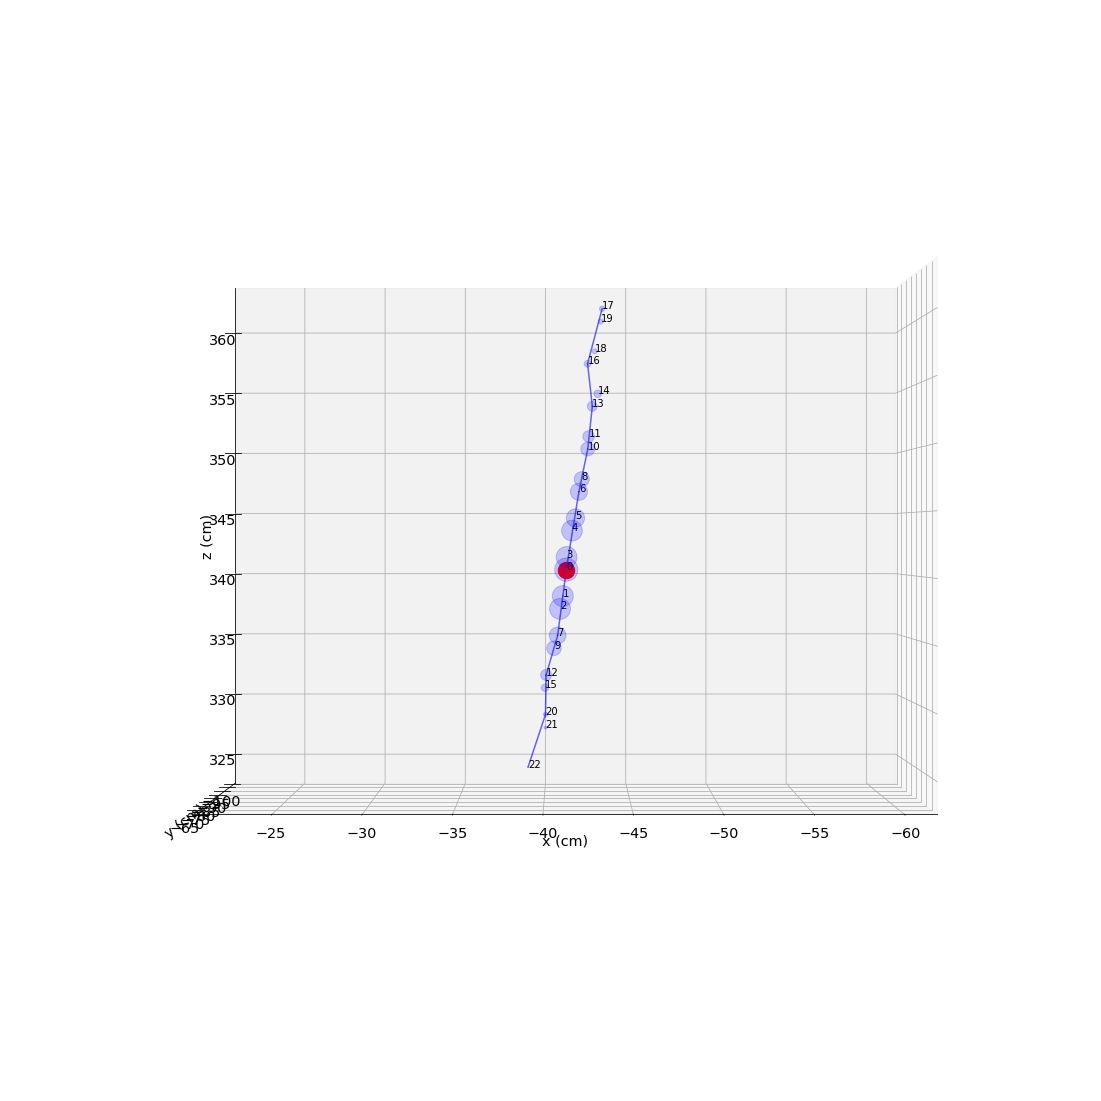

In [94]:
%matplotlib inline
create_graph(lc_data, vx, vy, vz, ve, vi, ev=1, DST_threshold=2, ANGLE_THR = 1.5)

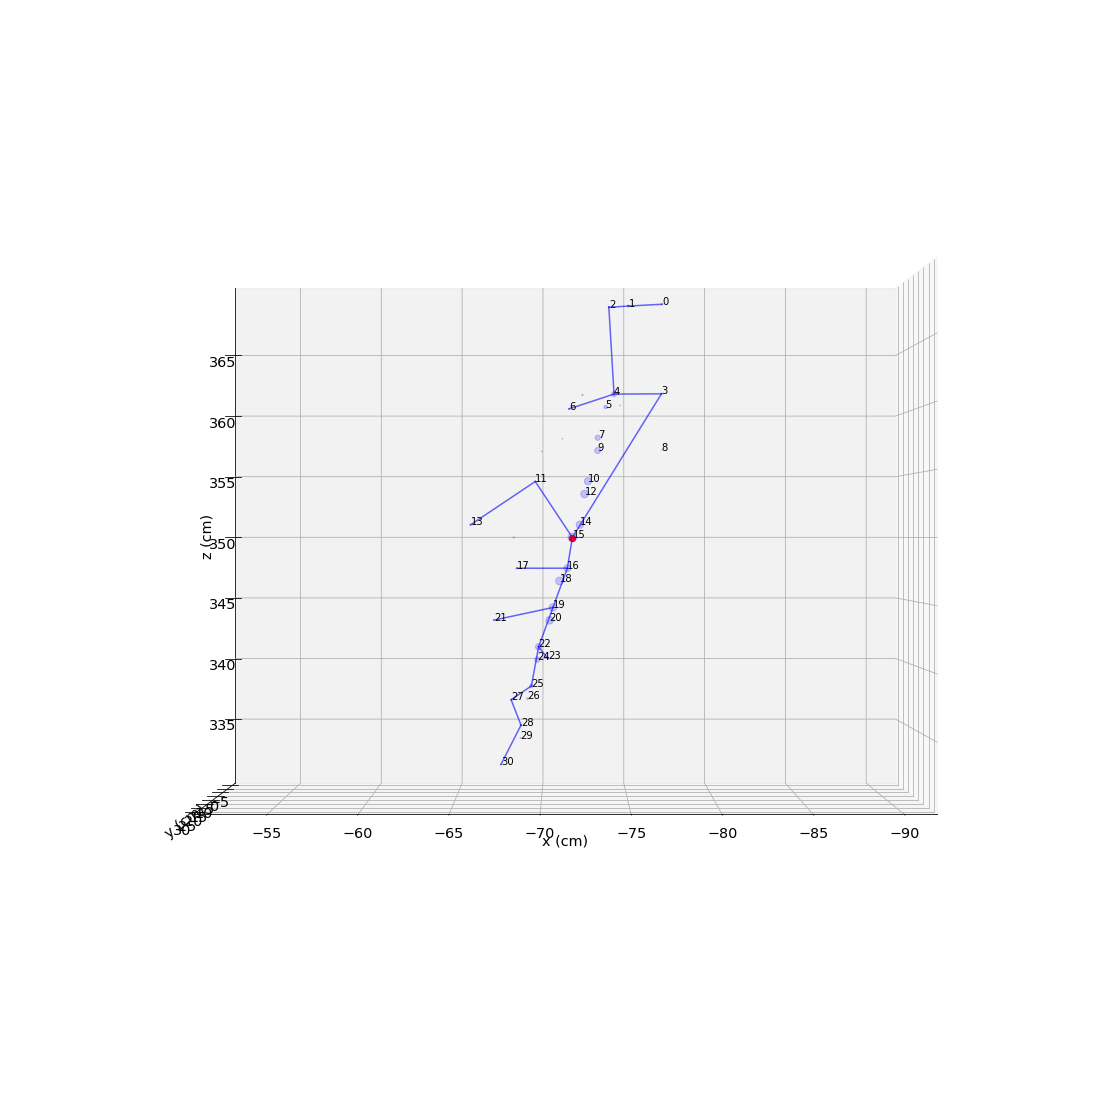

In [95]:
%matplotlib inline 
#widget
create_graph(lc_data, vx, vy, vz, ve, vi, DST_threshold=2, ANGLE_THR = 1.5, sort_by_z = True)

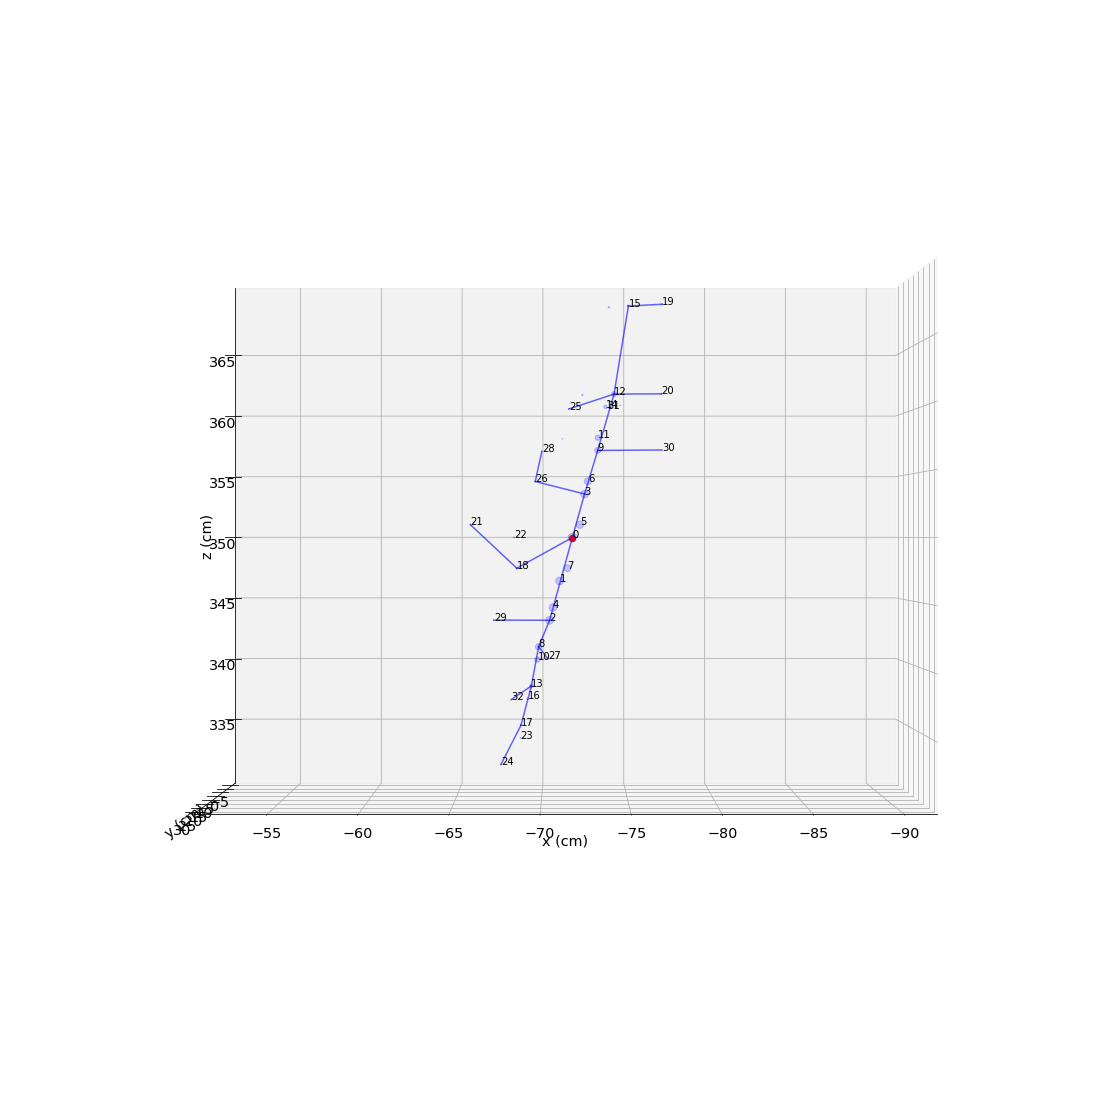

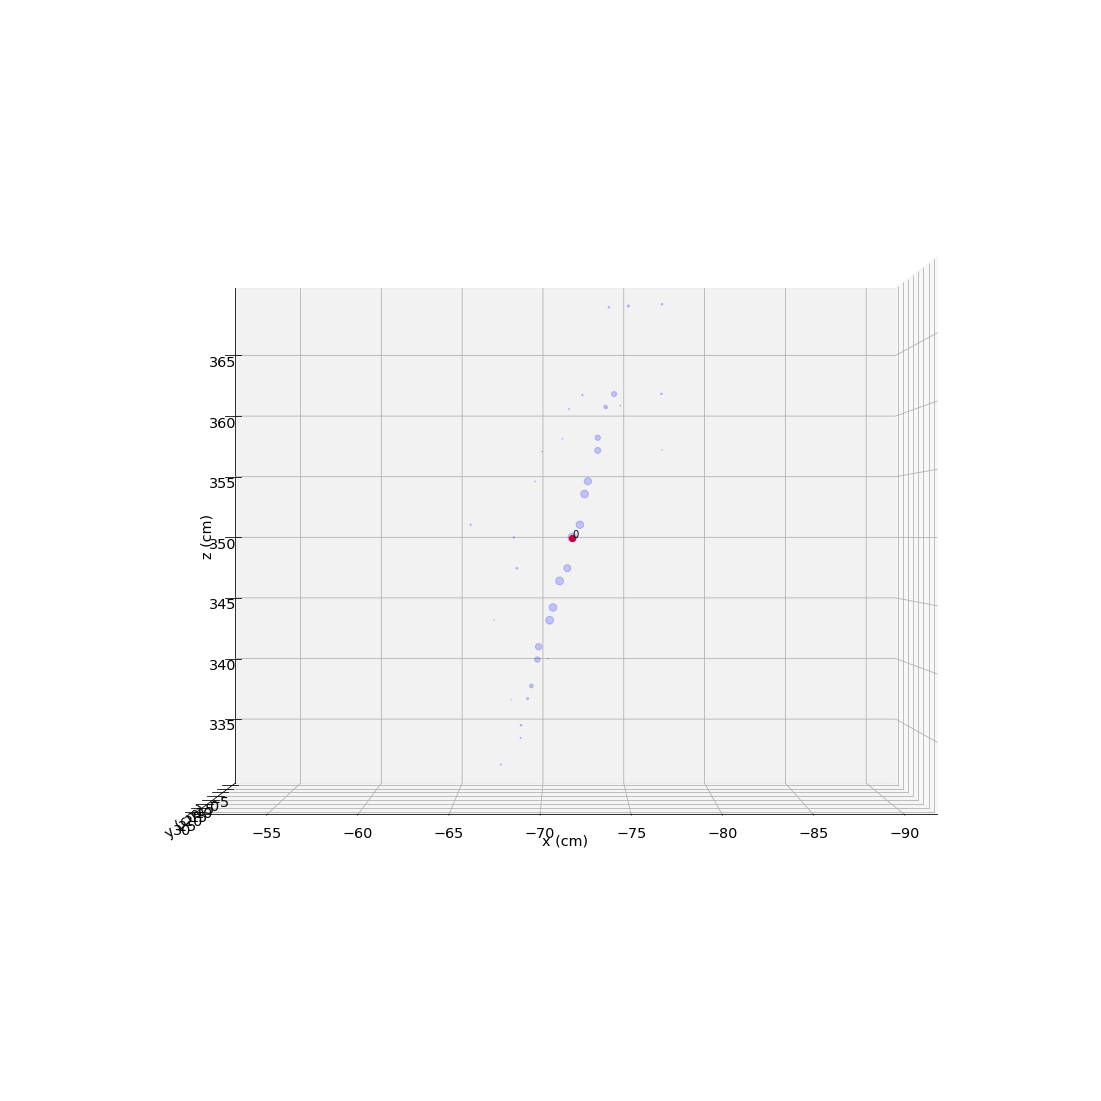

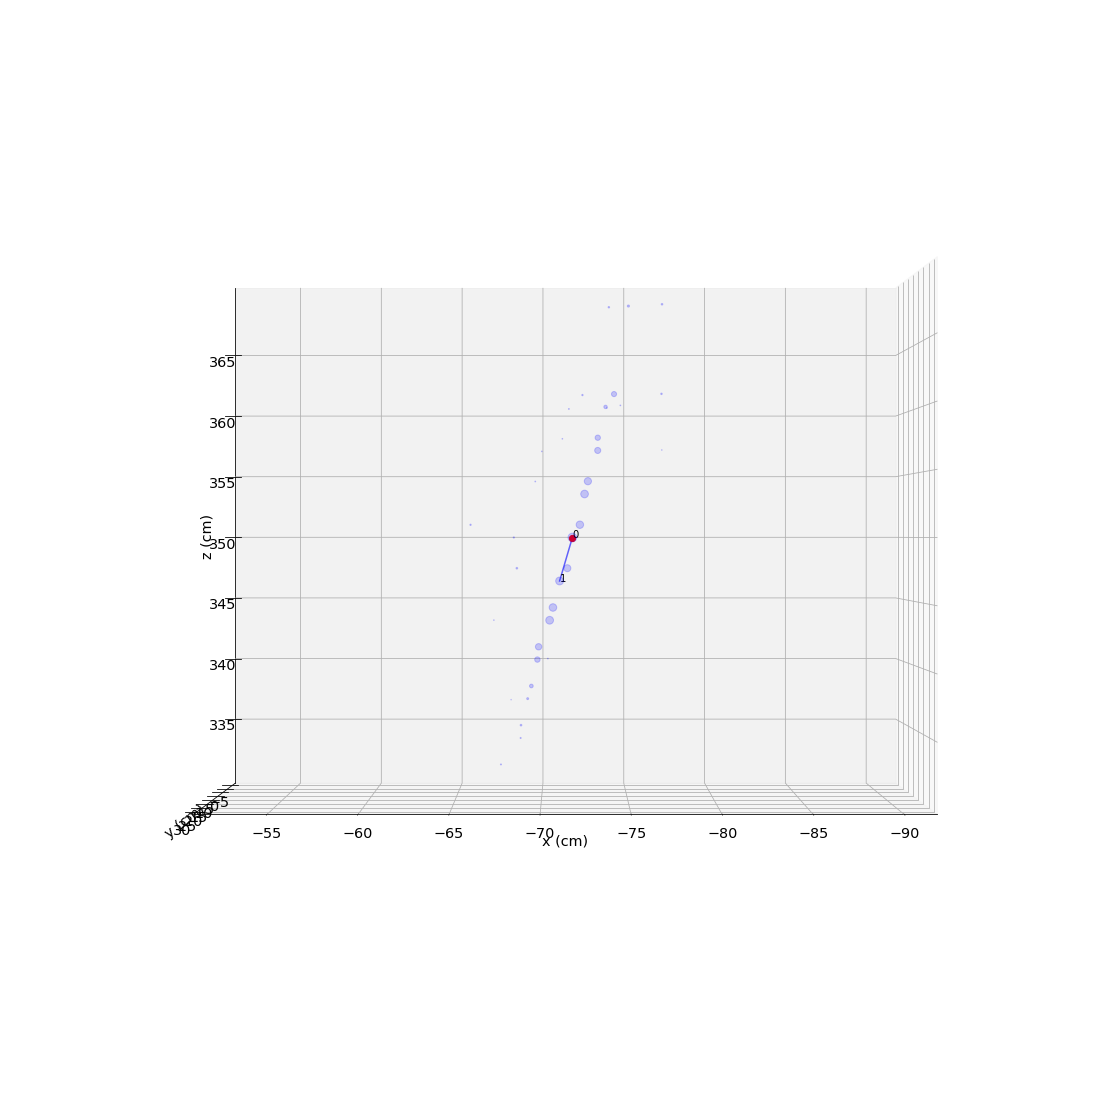

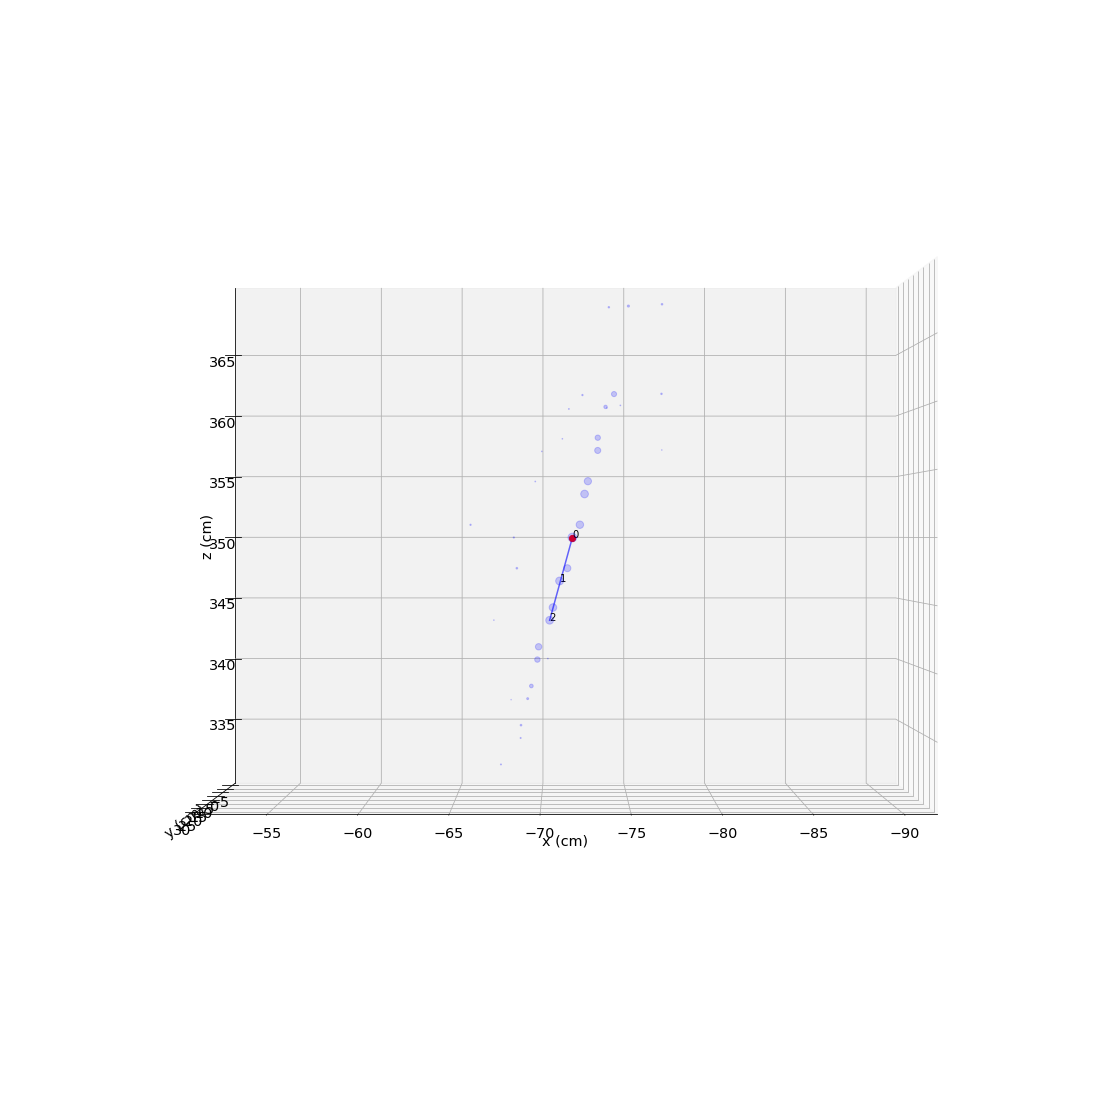

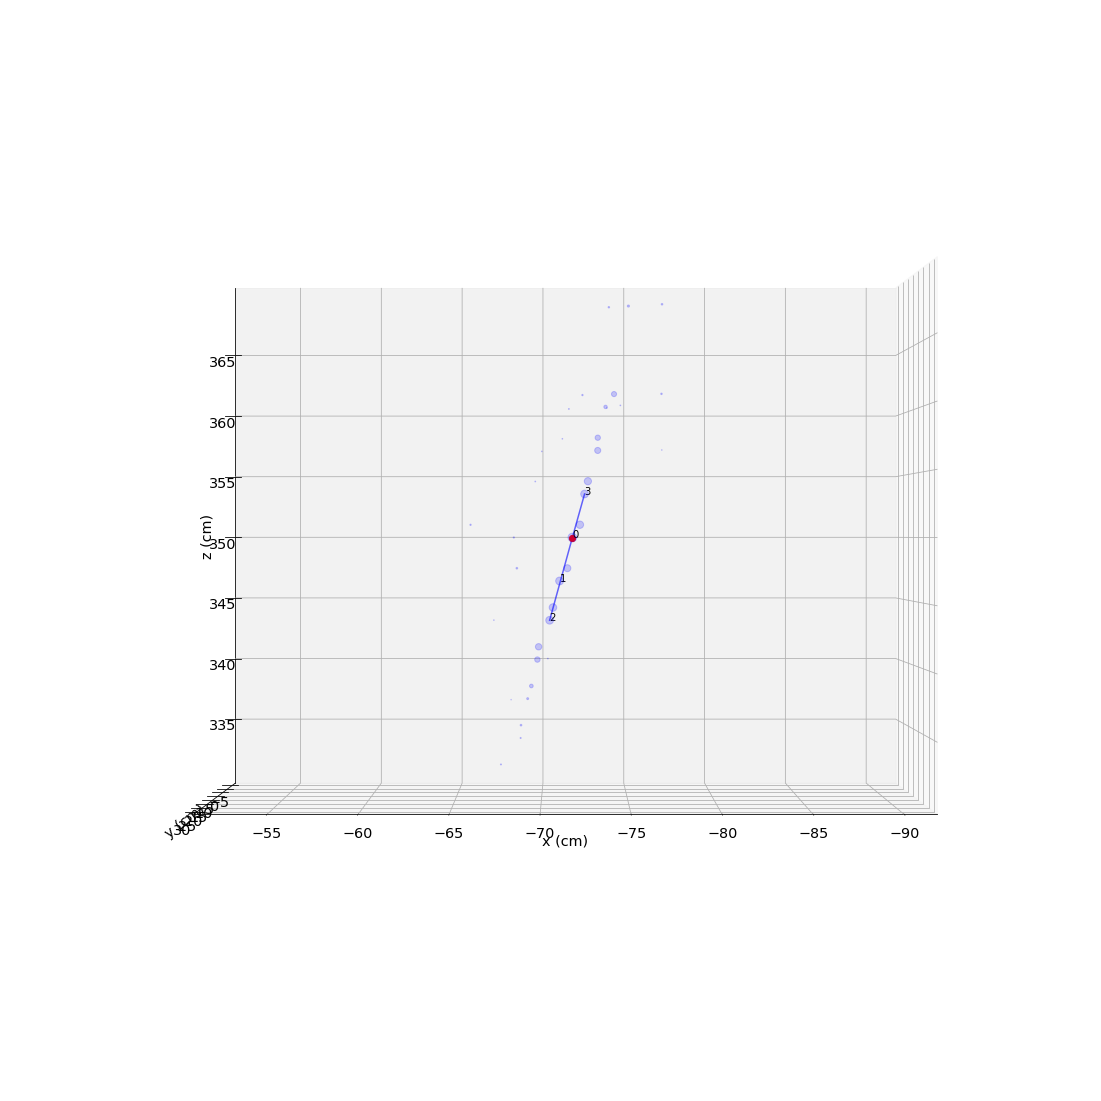

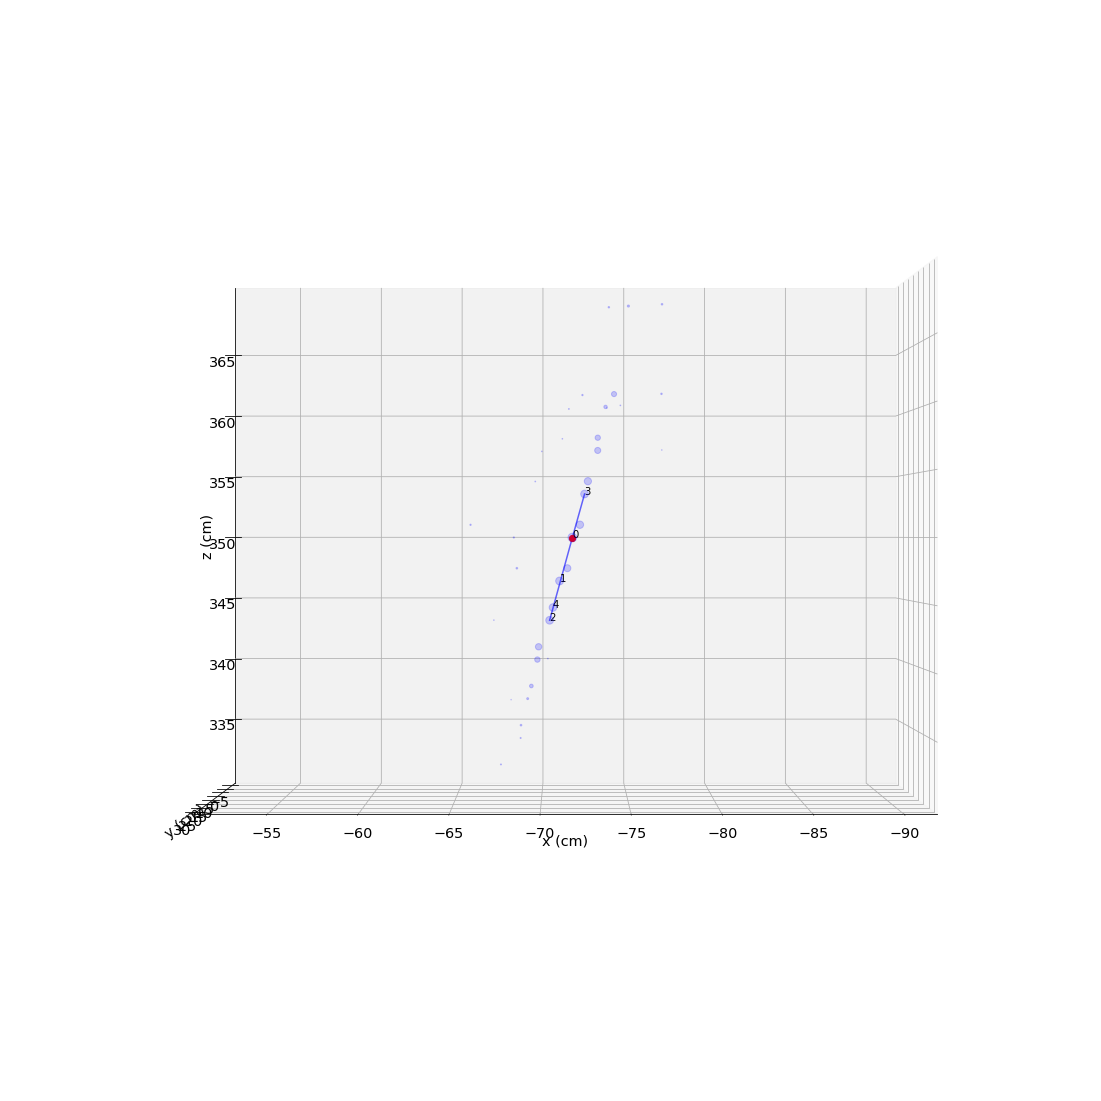

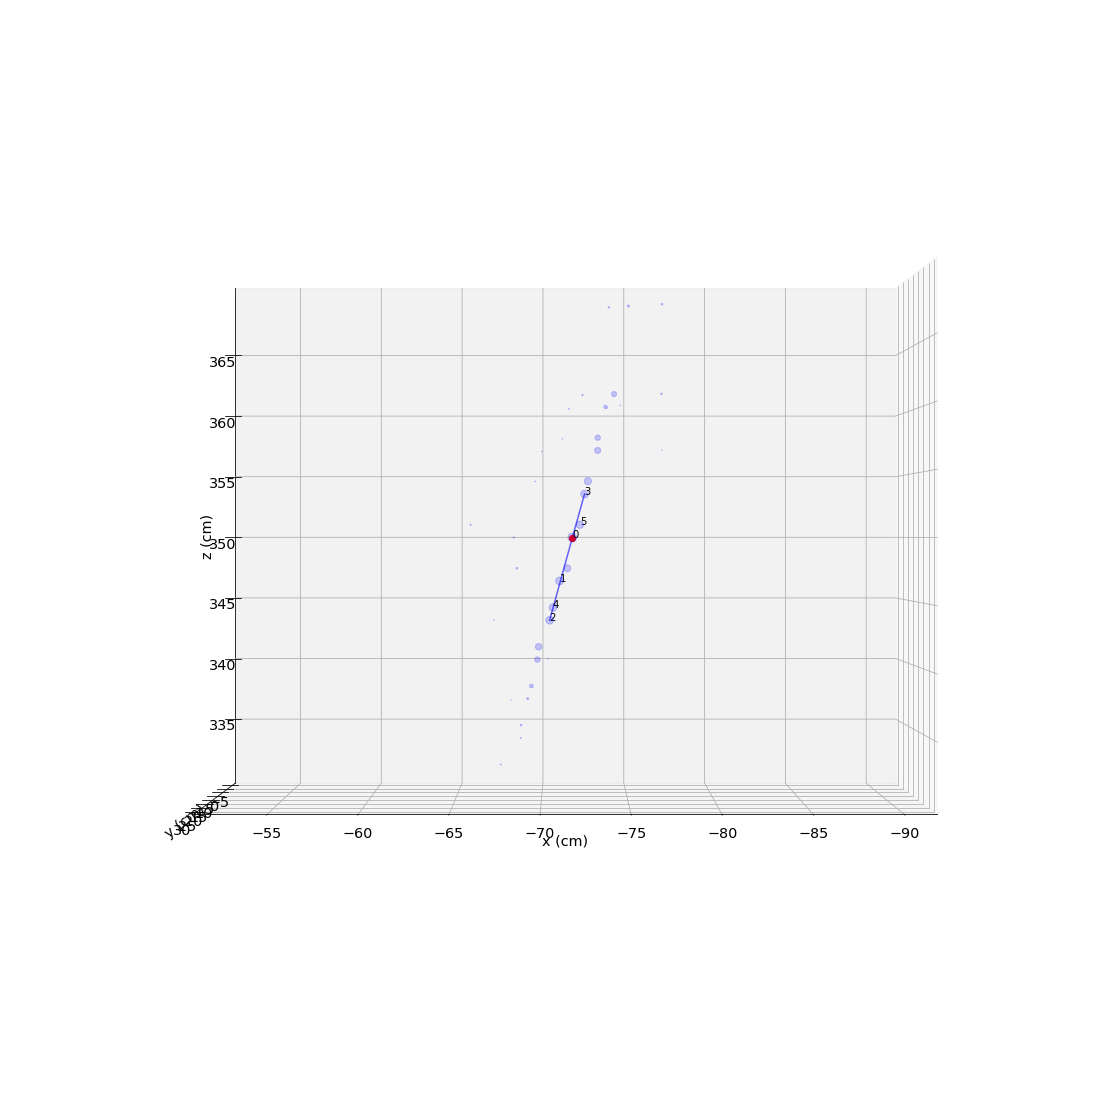

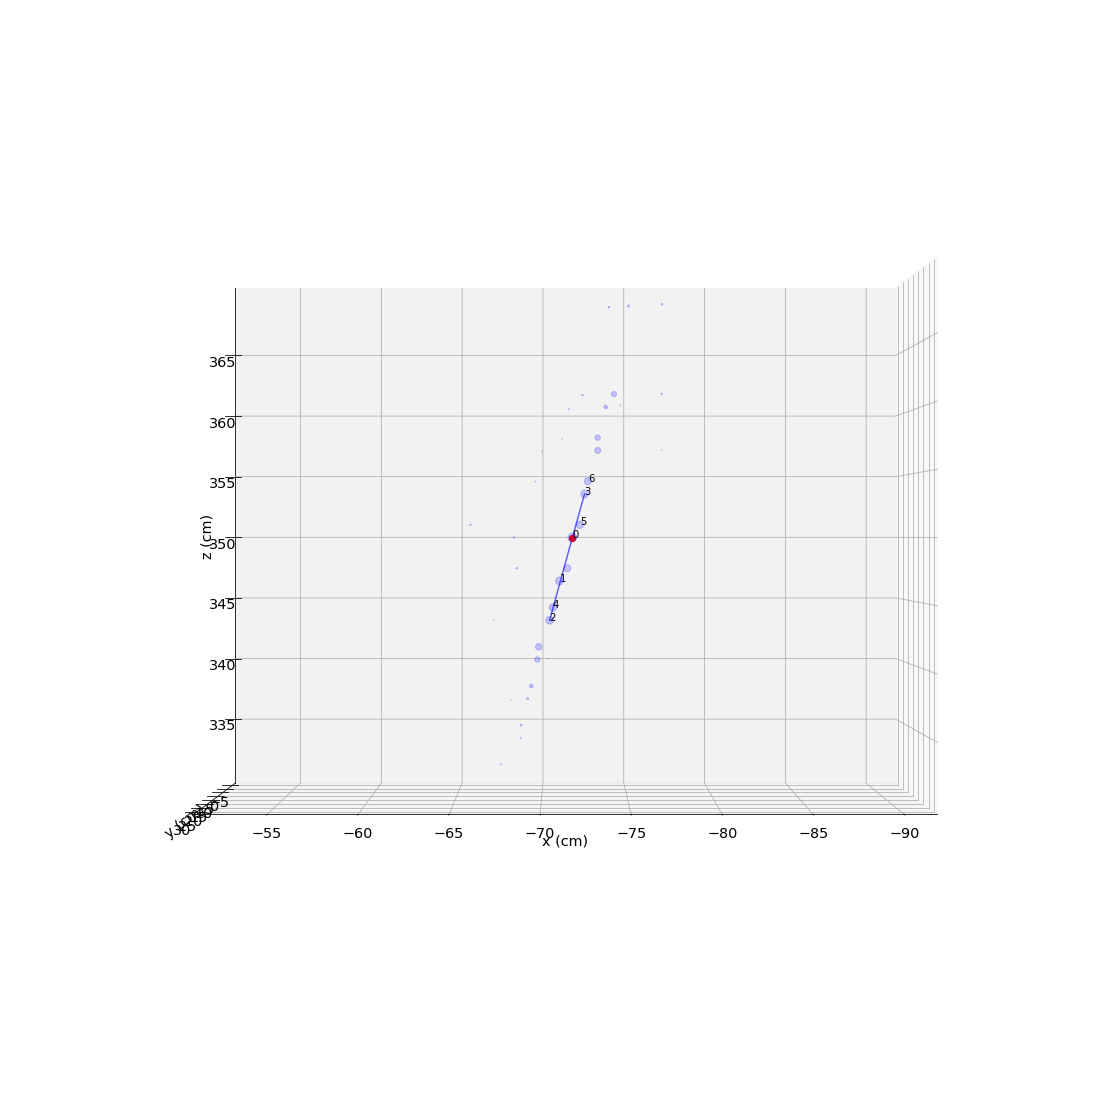

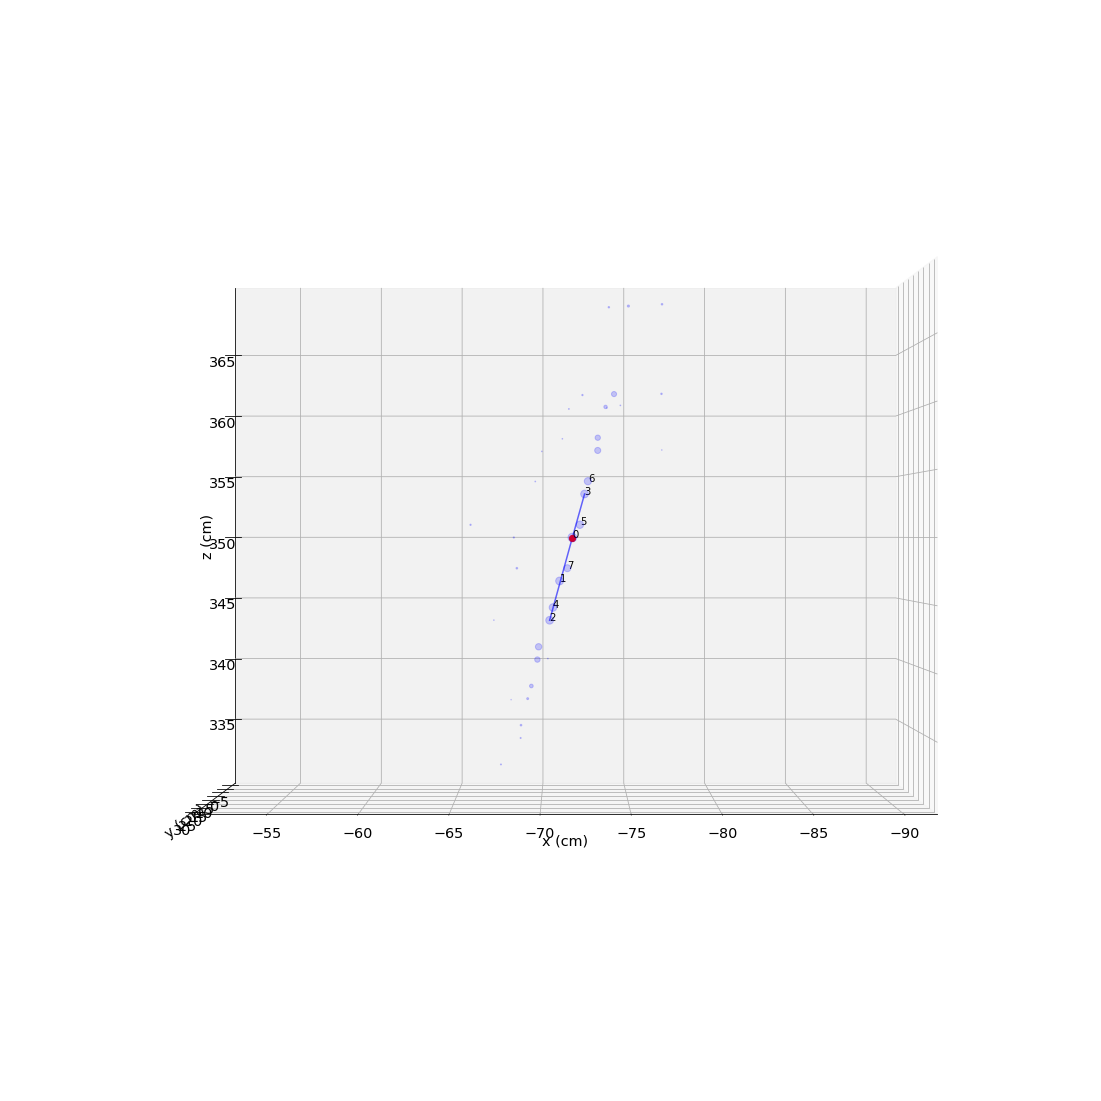

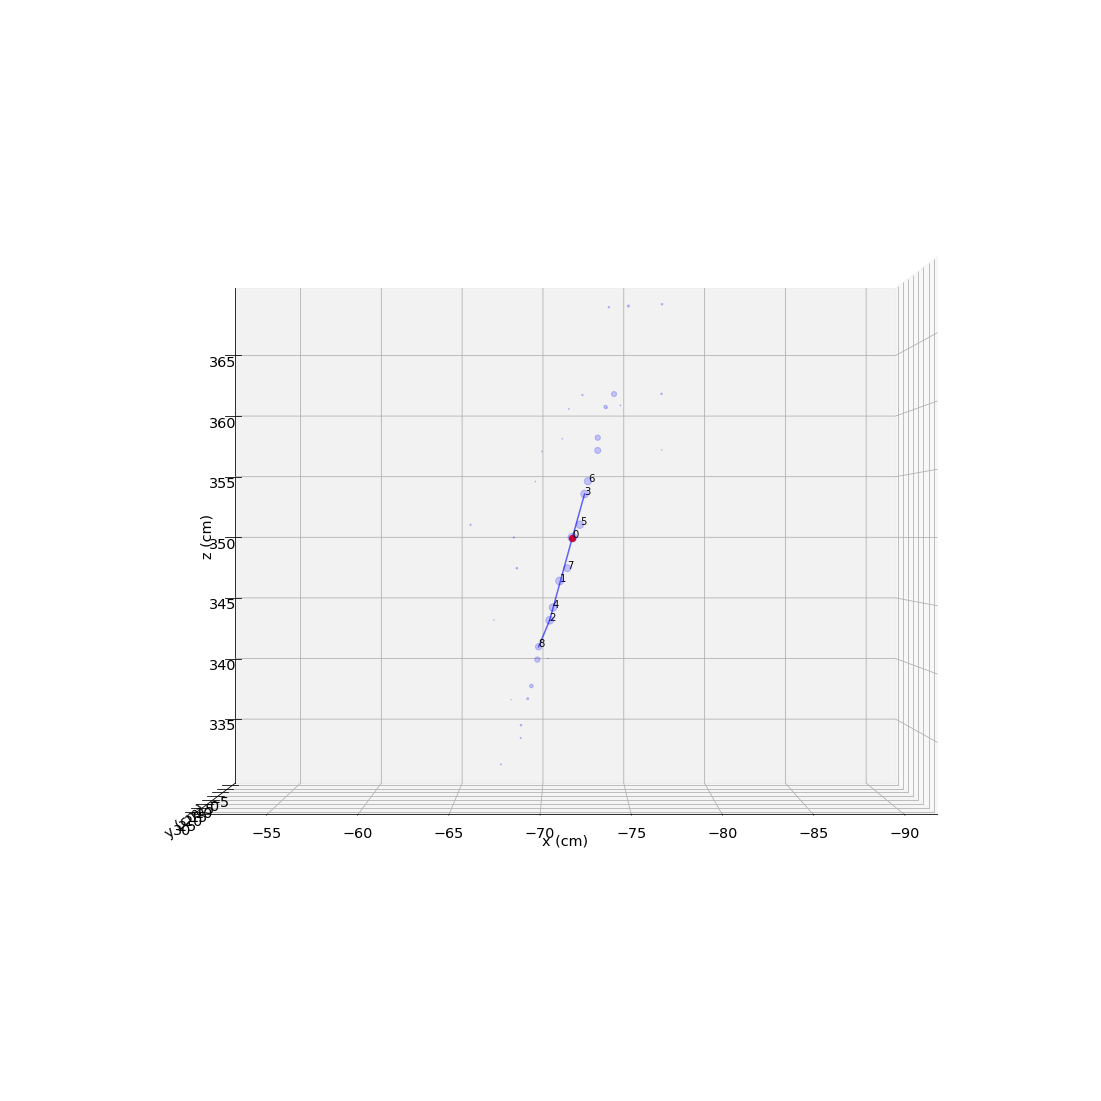

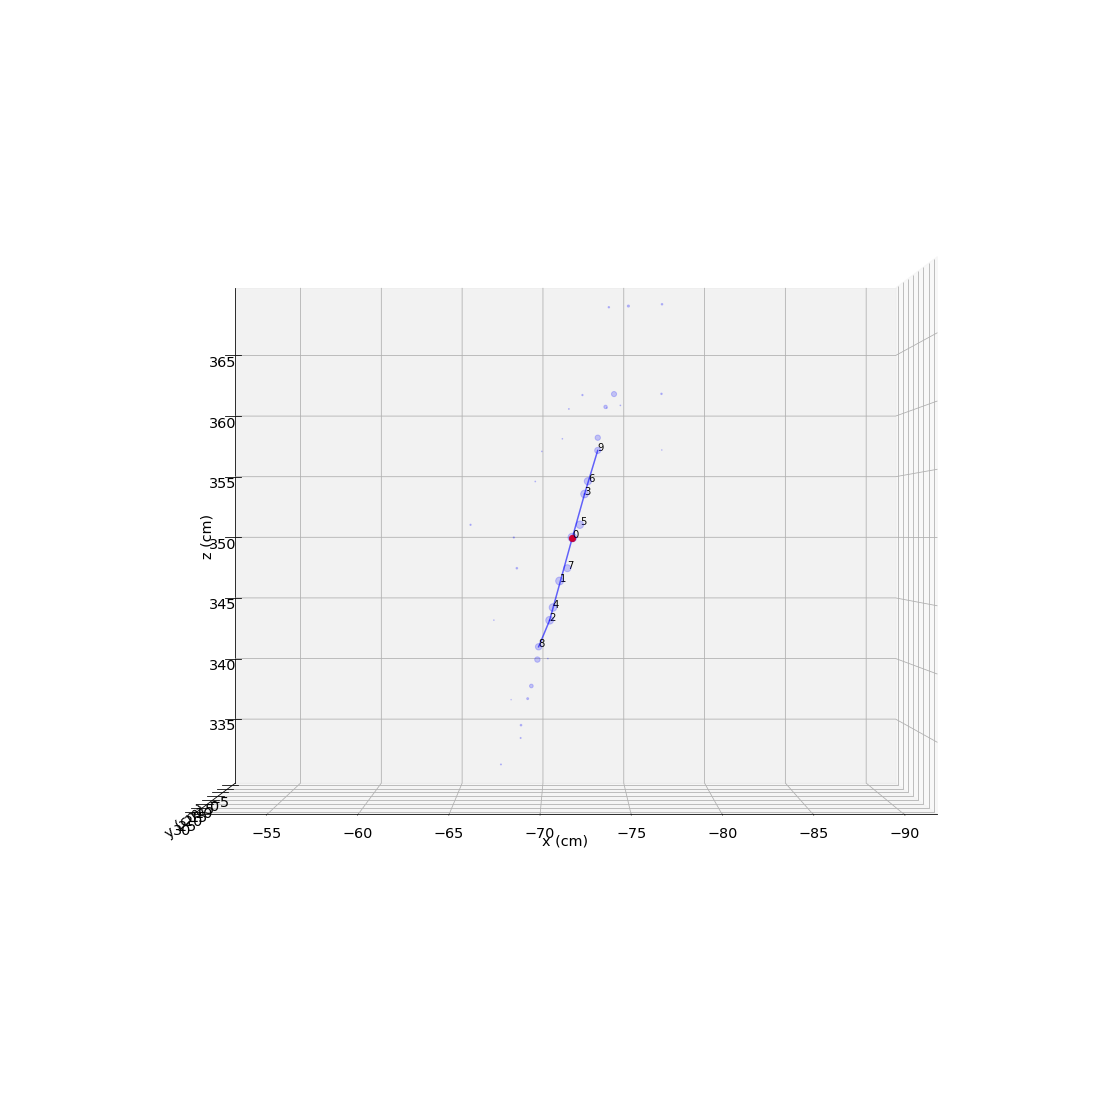

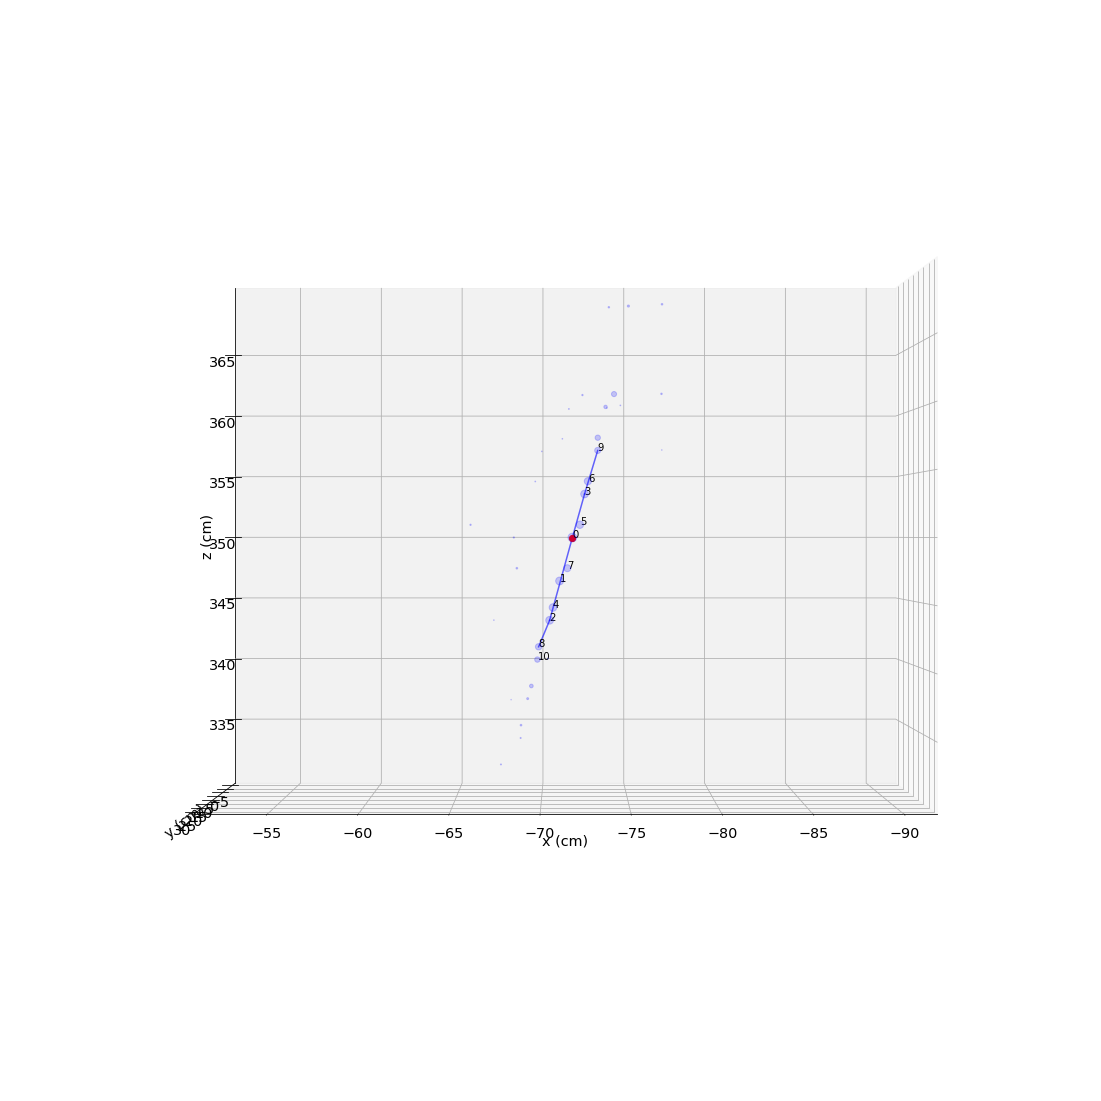

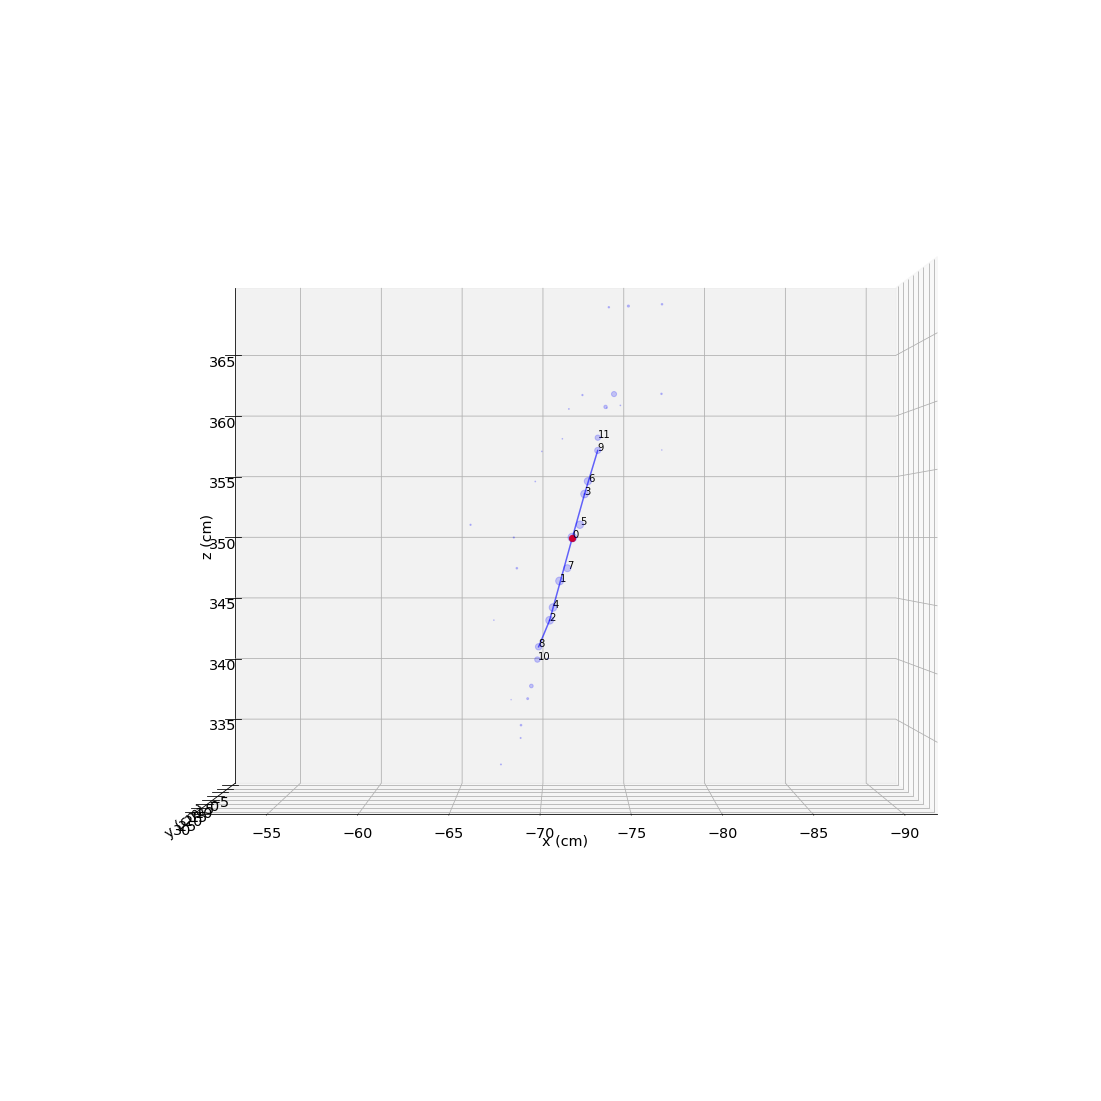

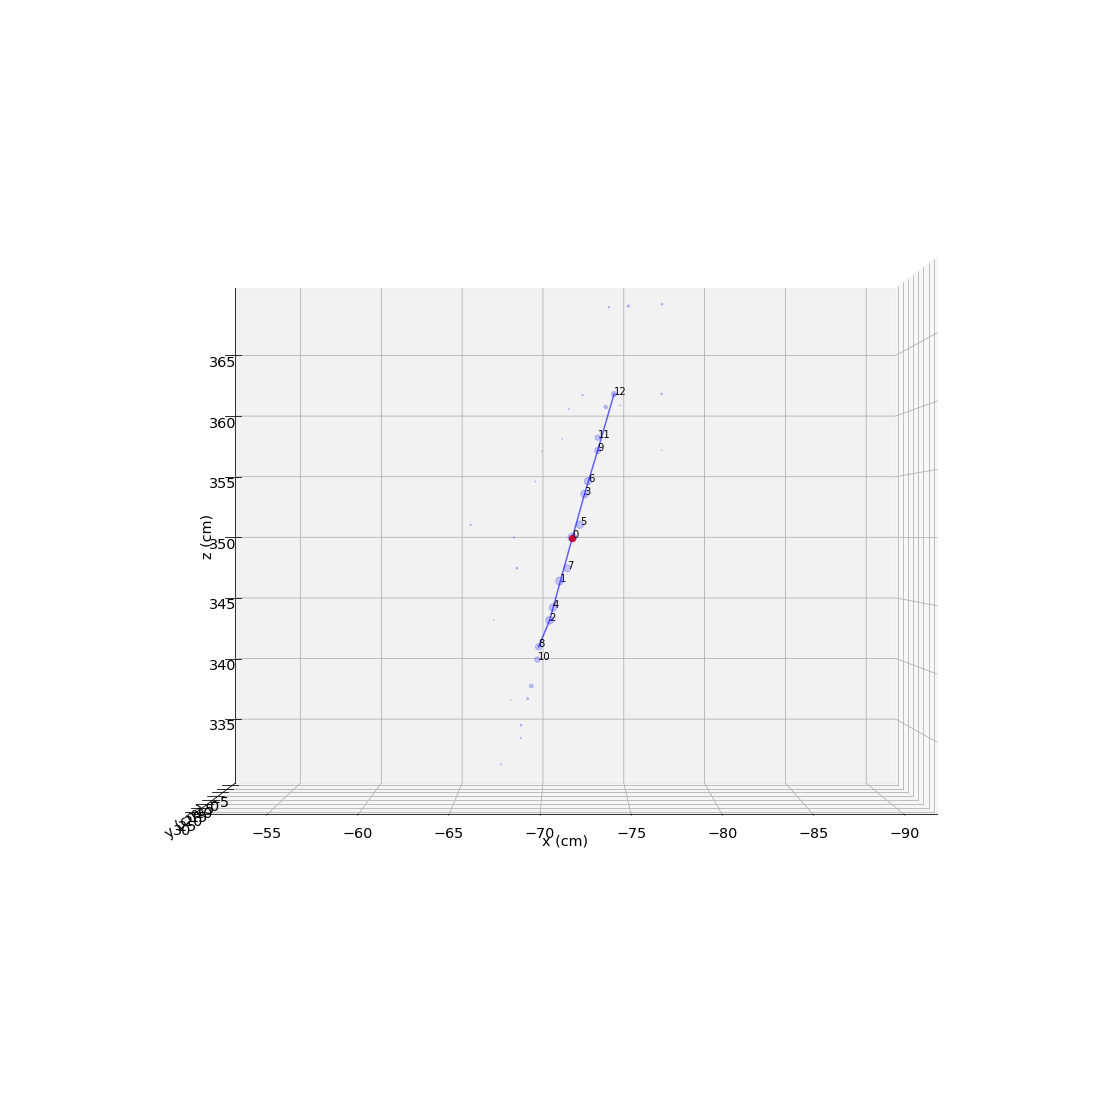

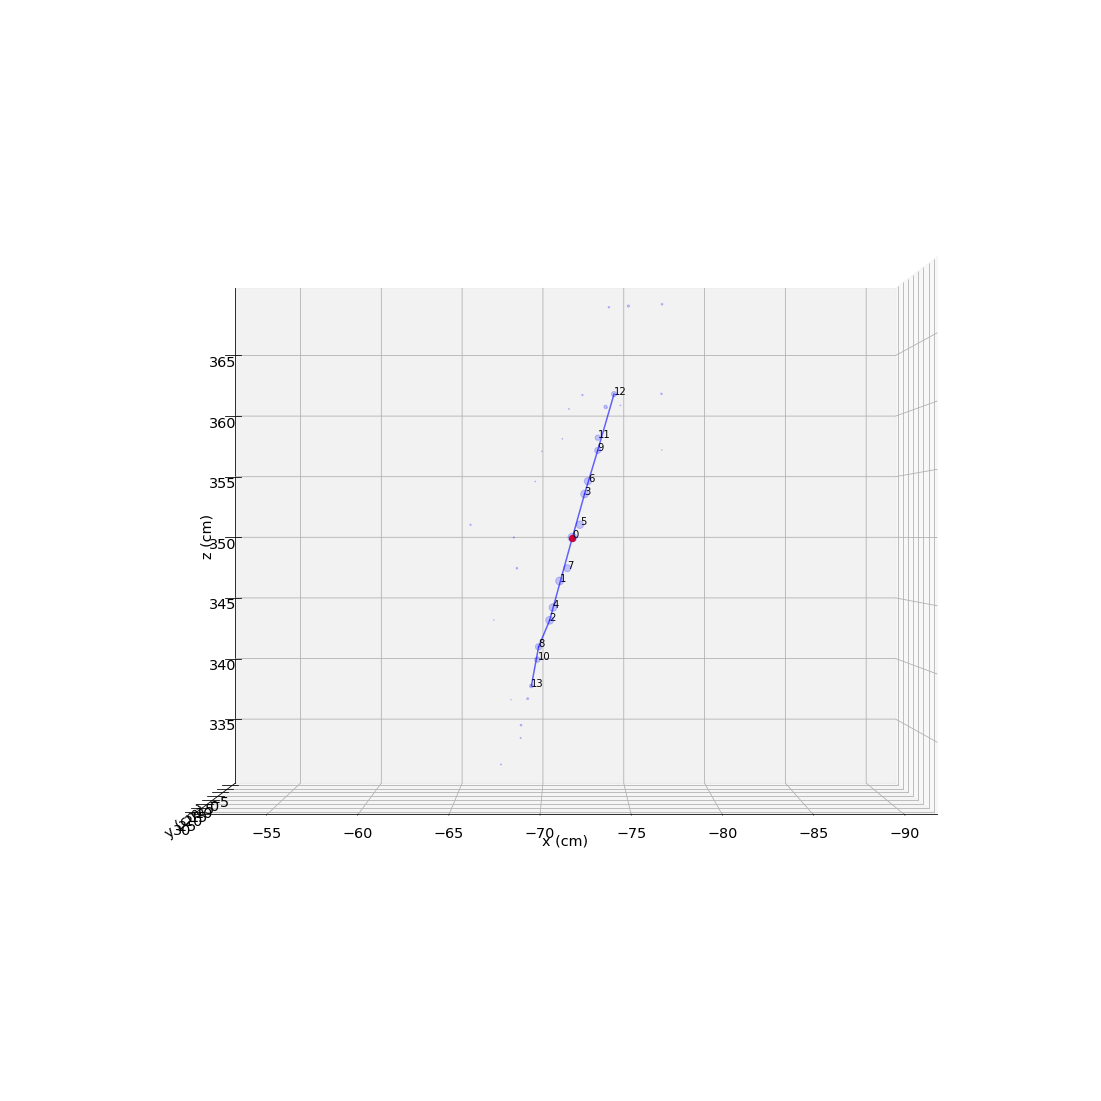

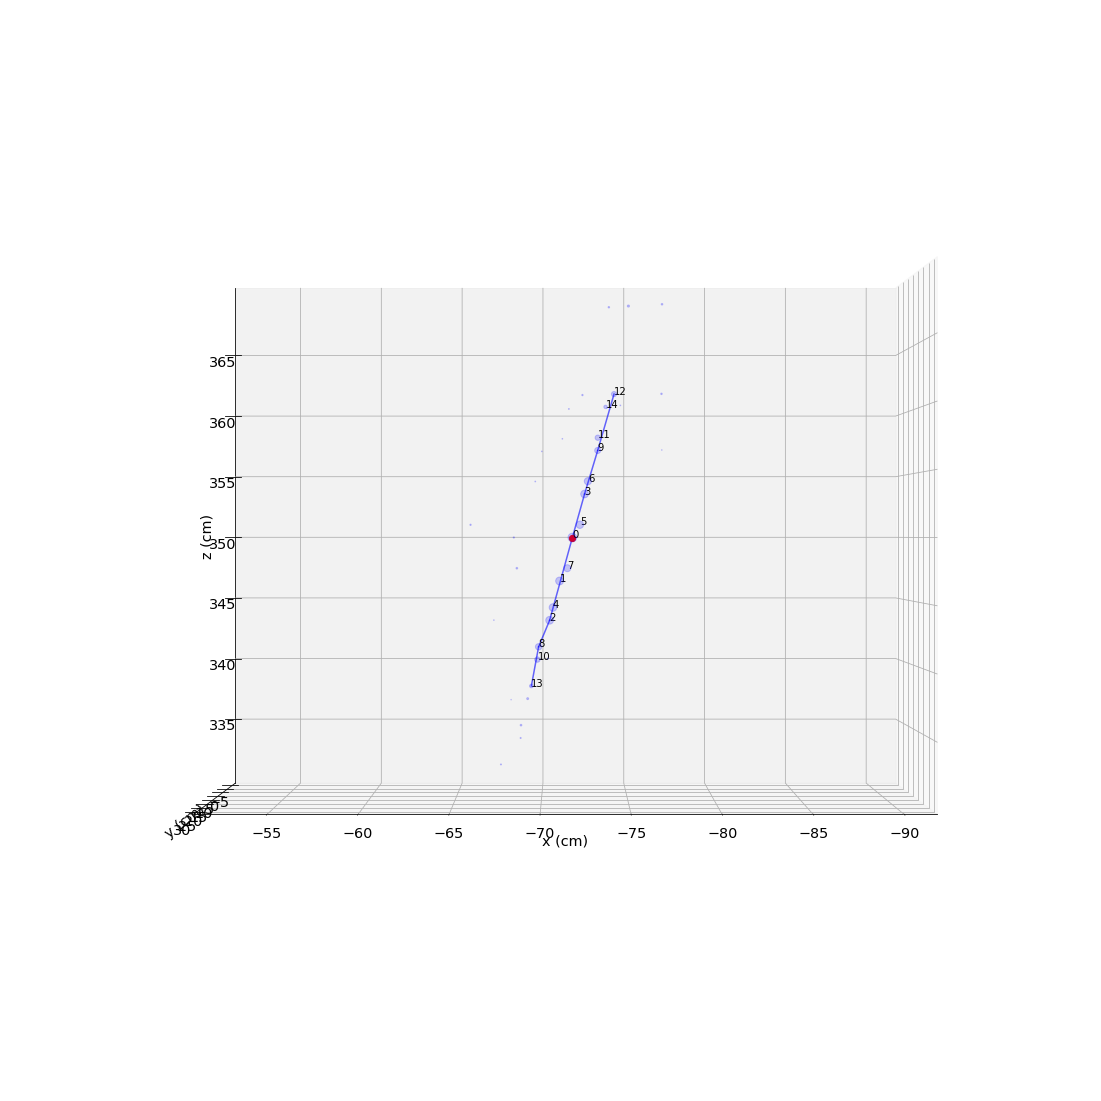

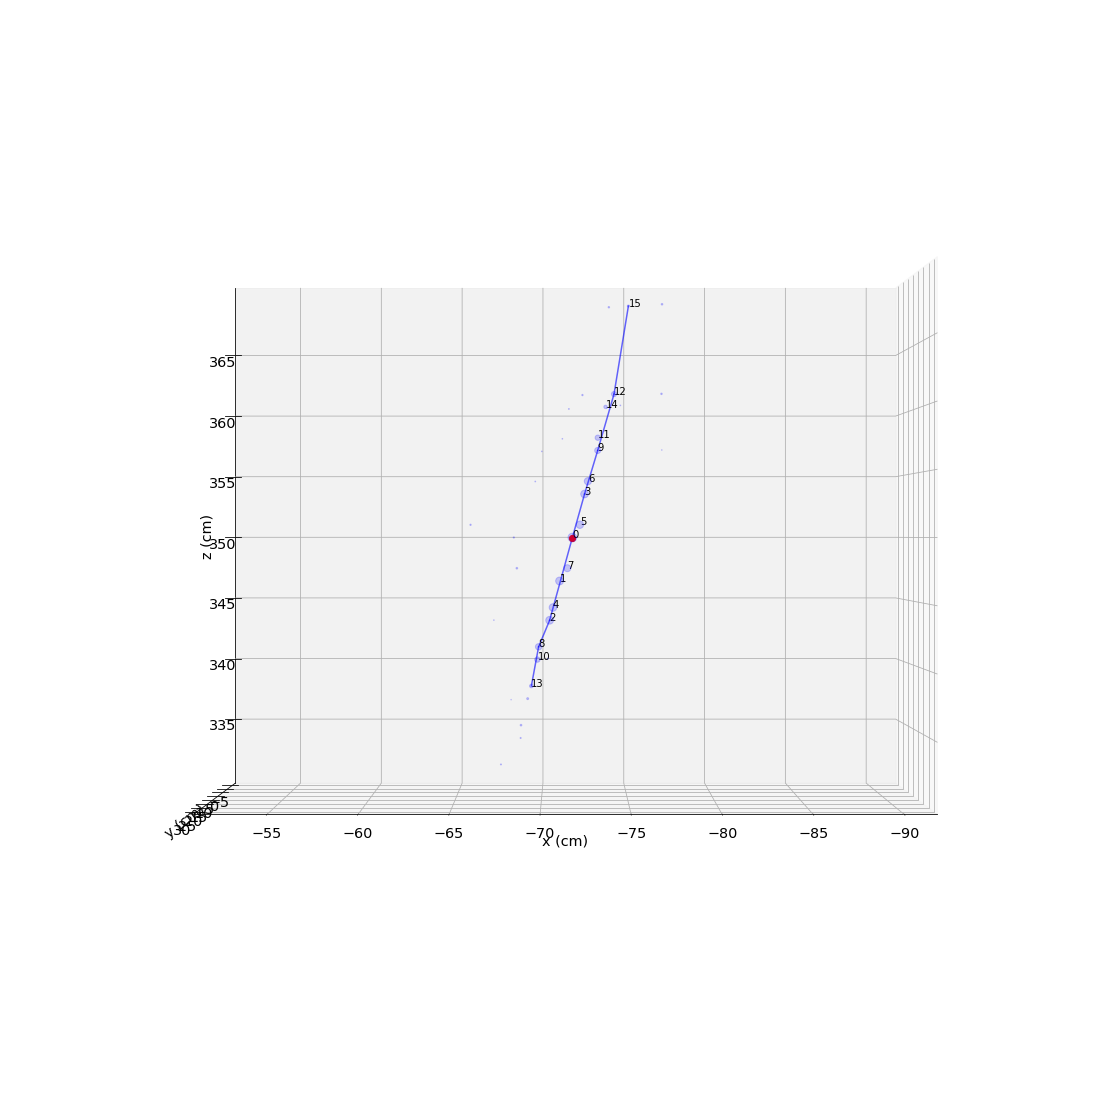

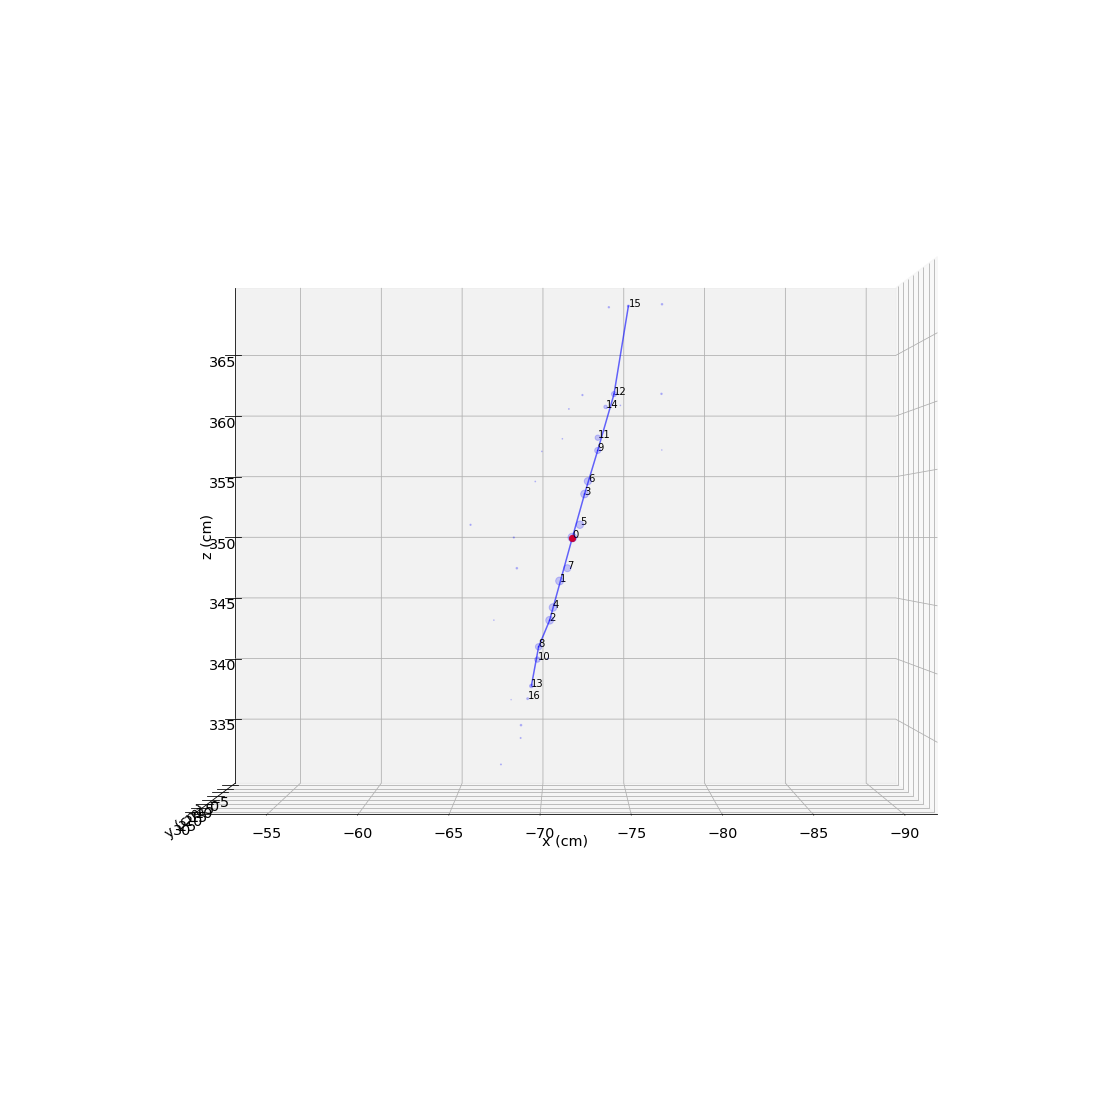

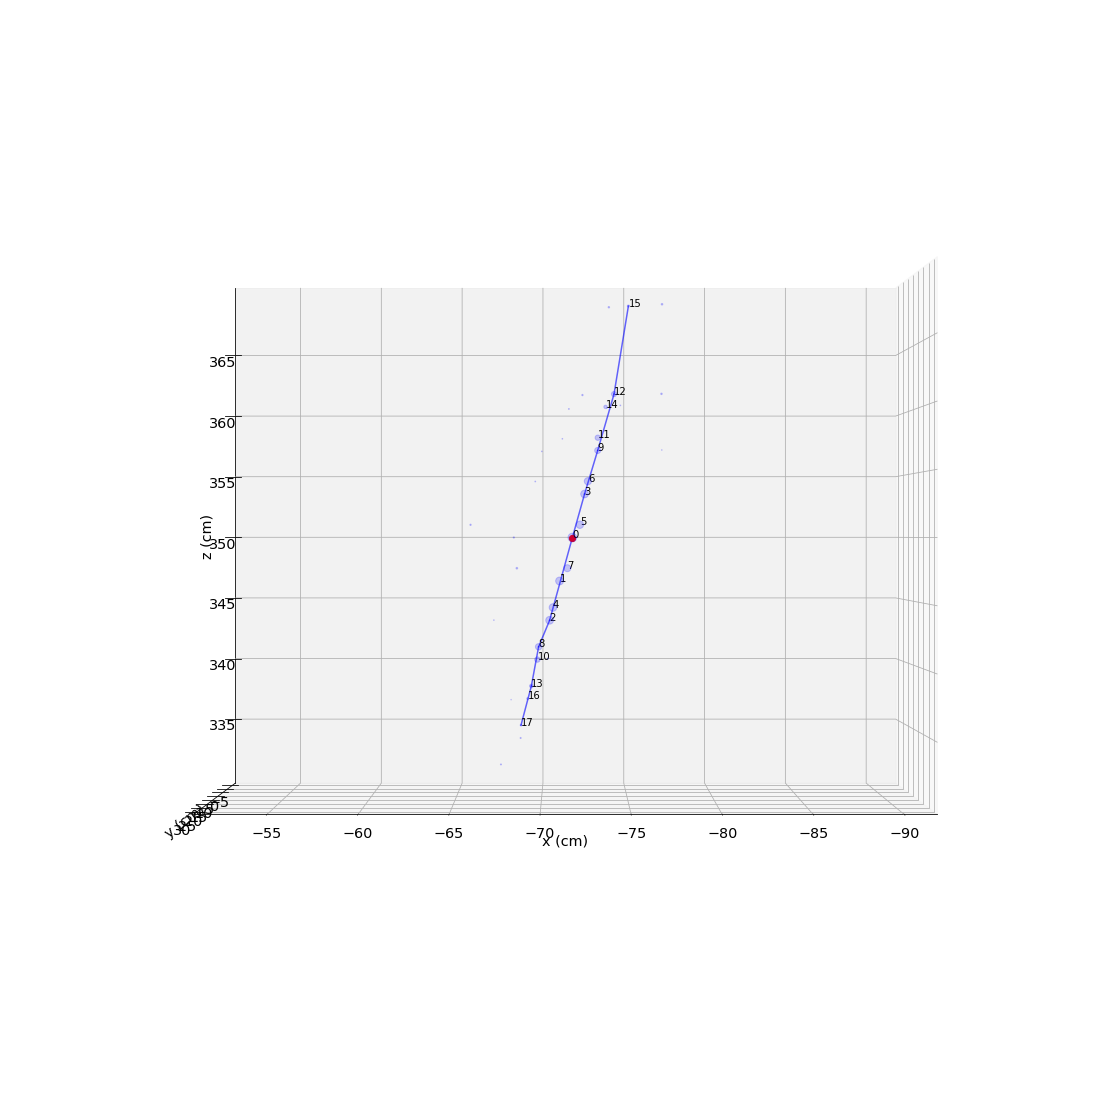

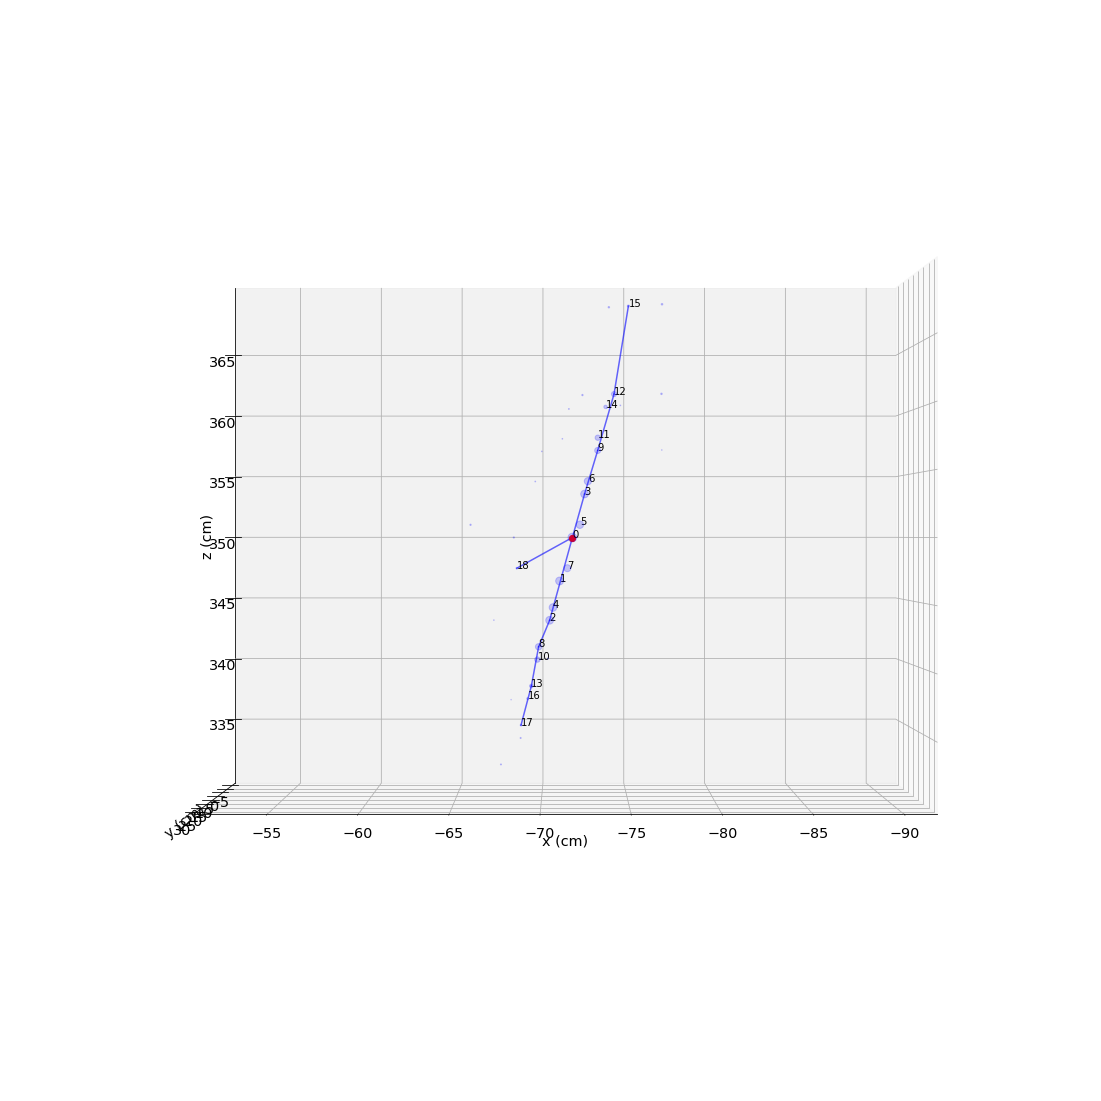

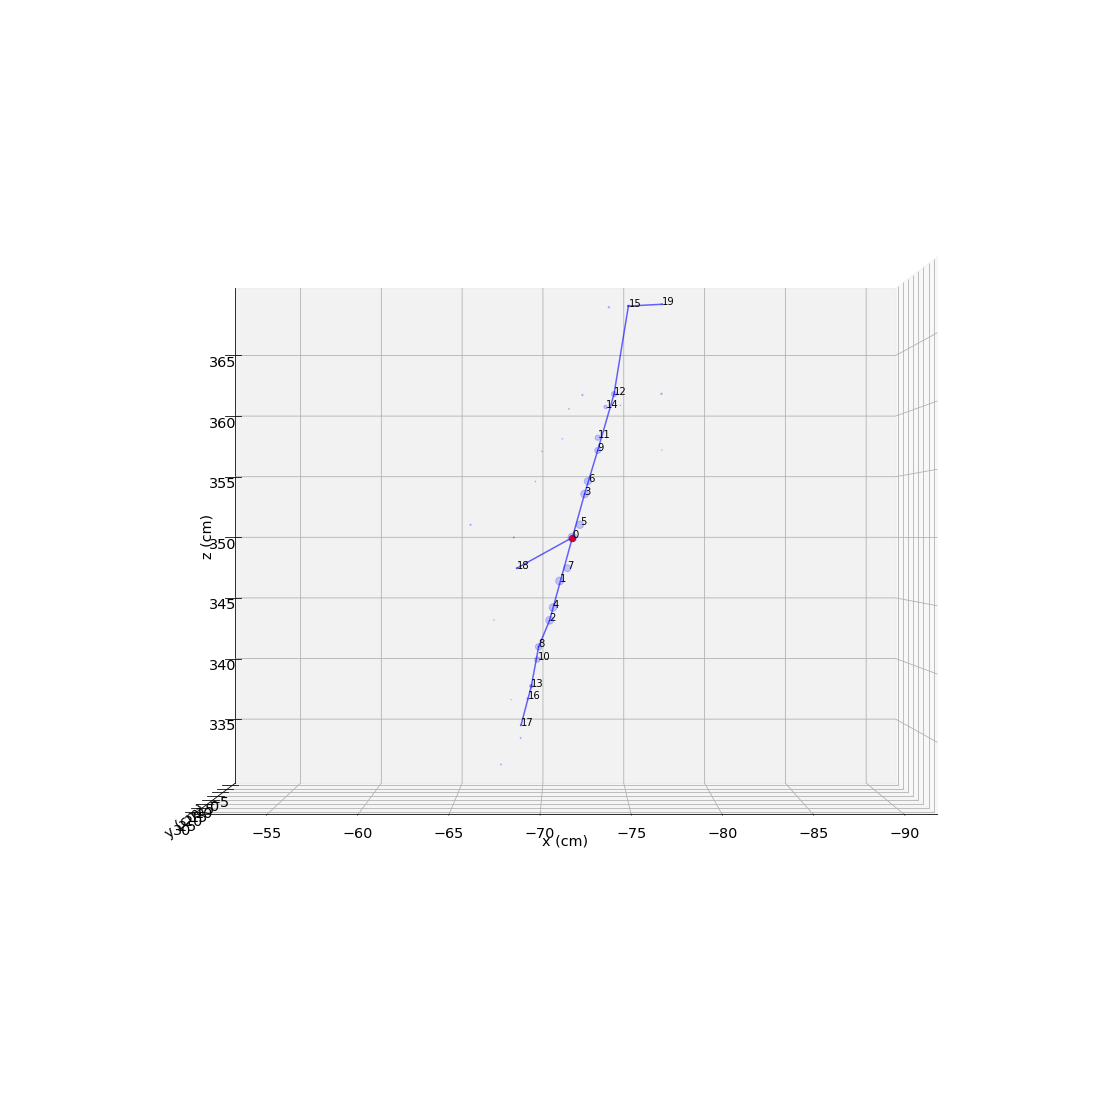

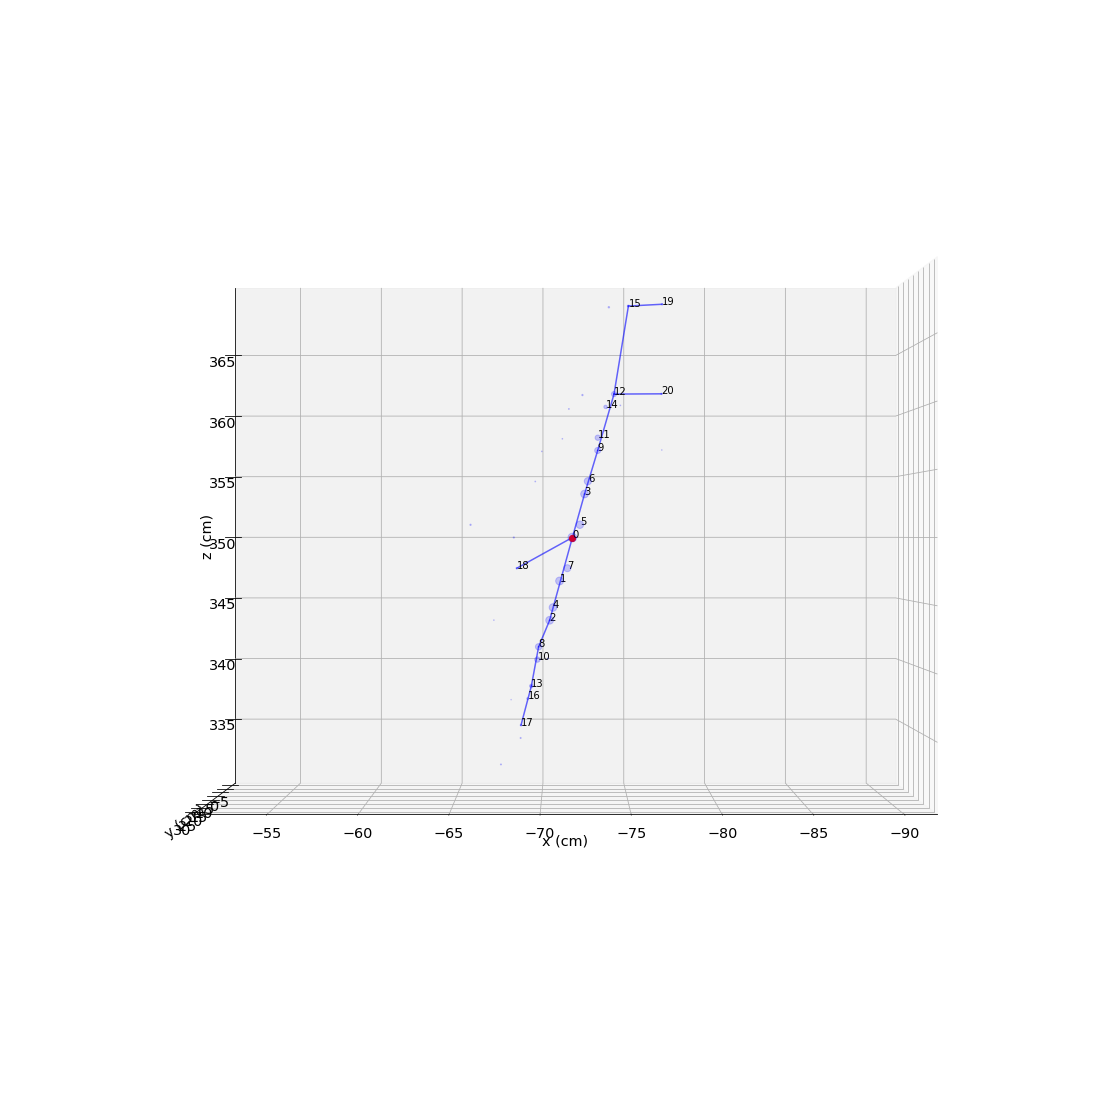

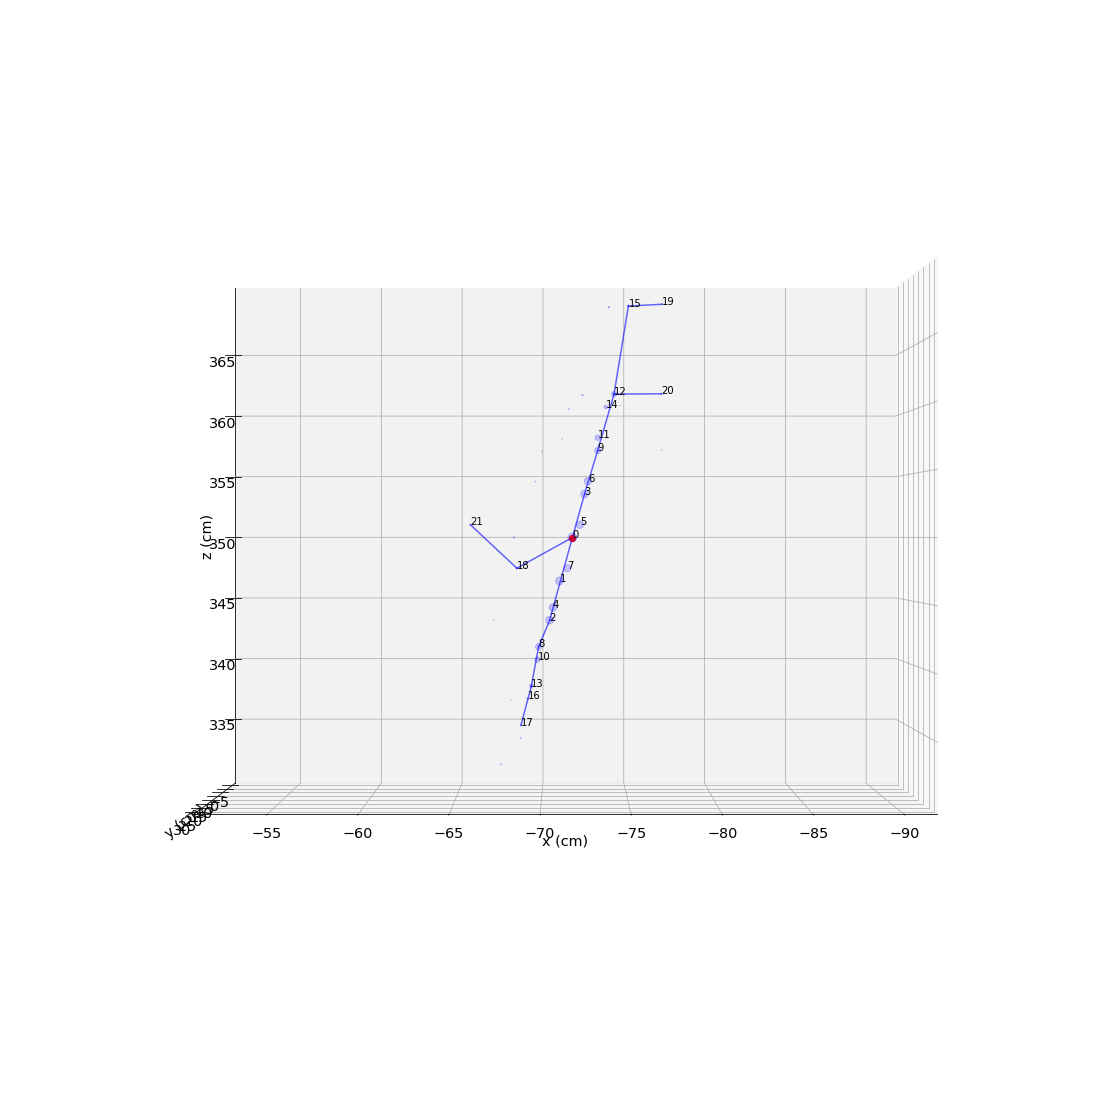

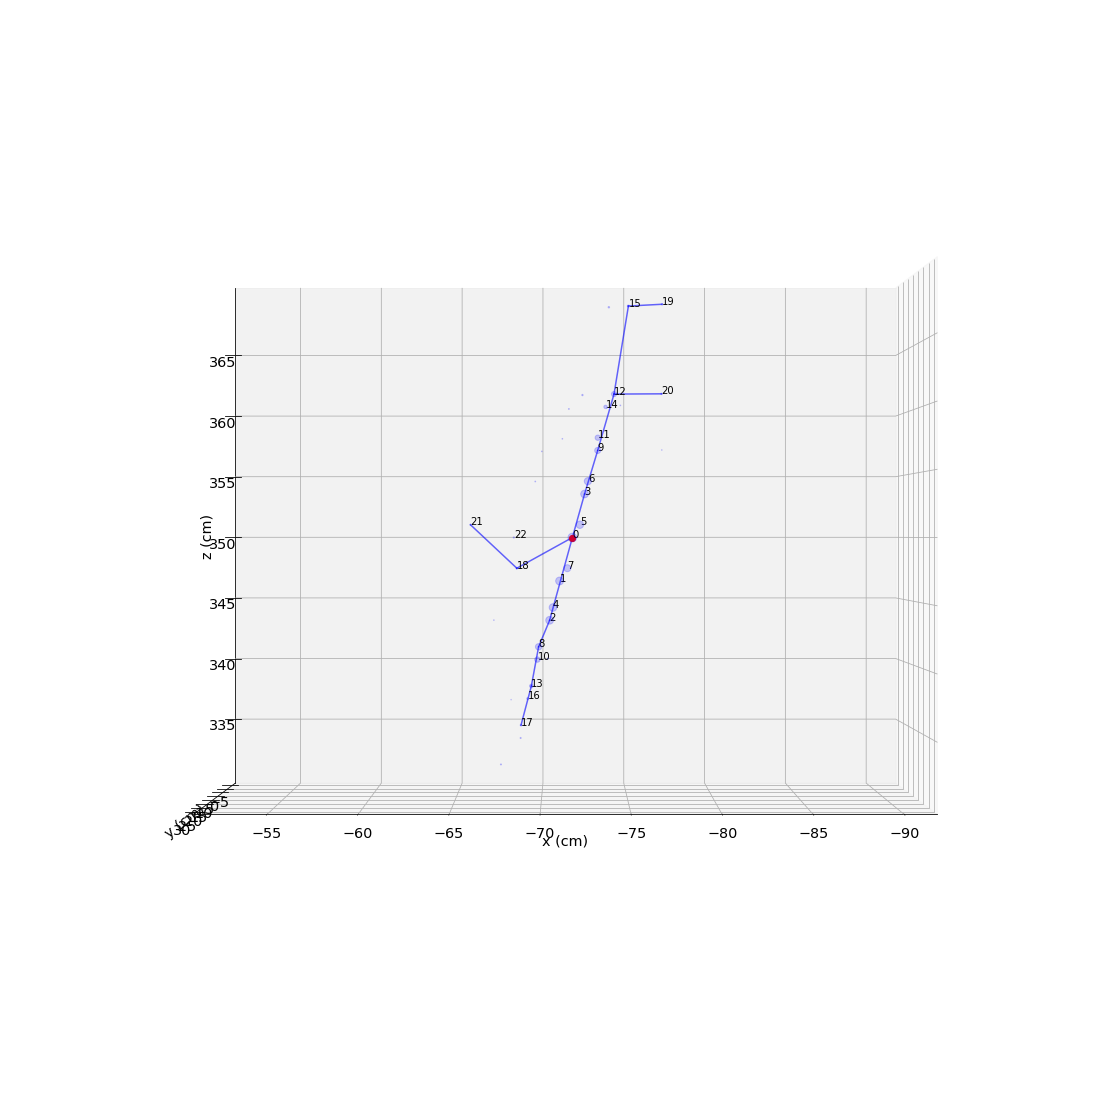

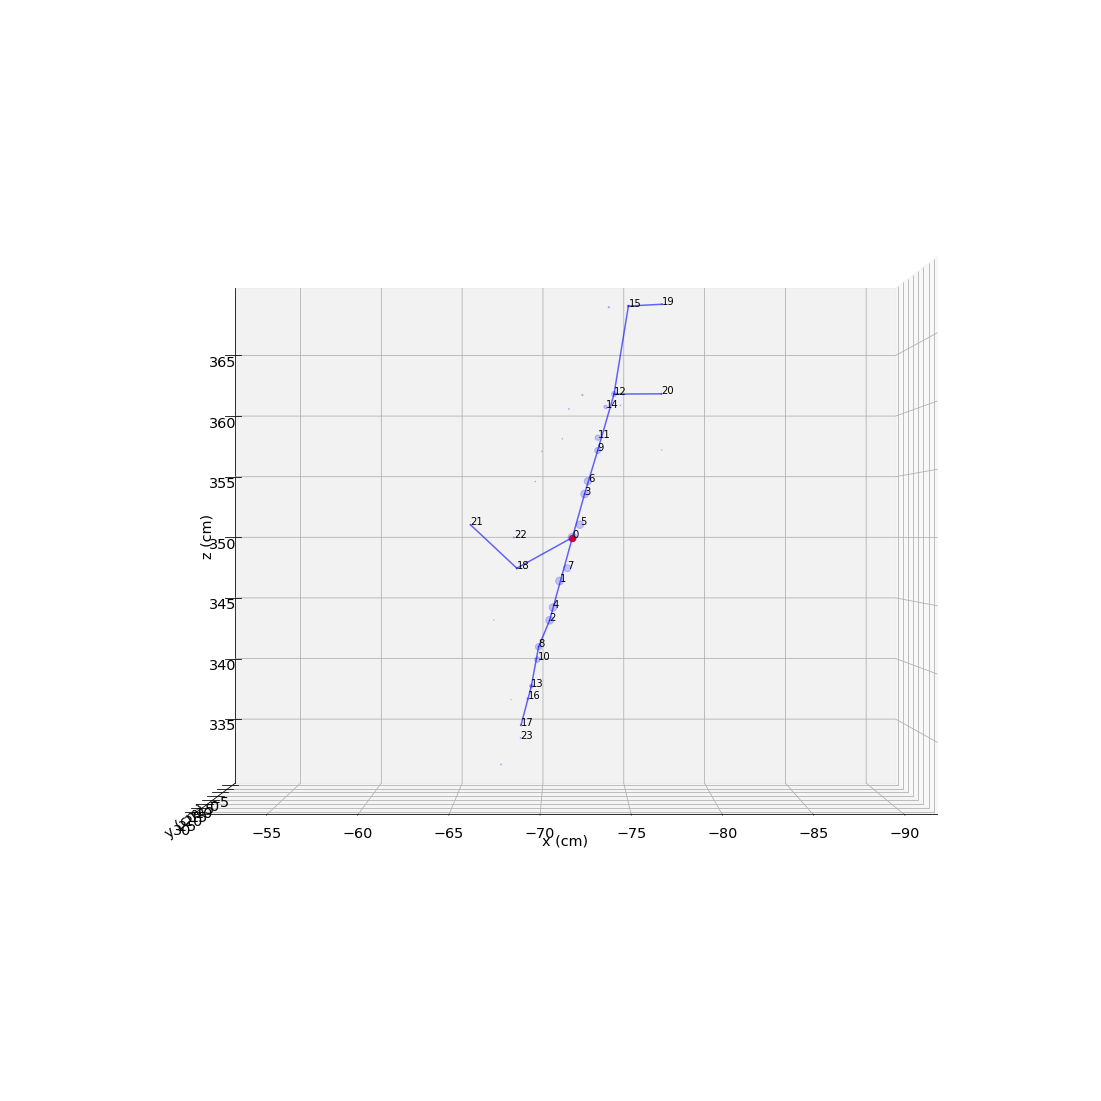

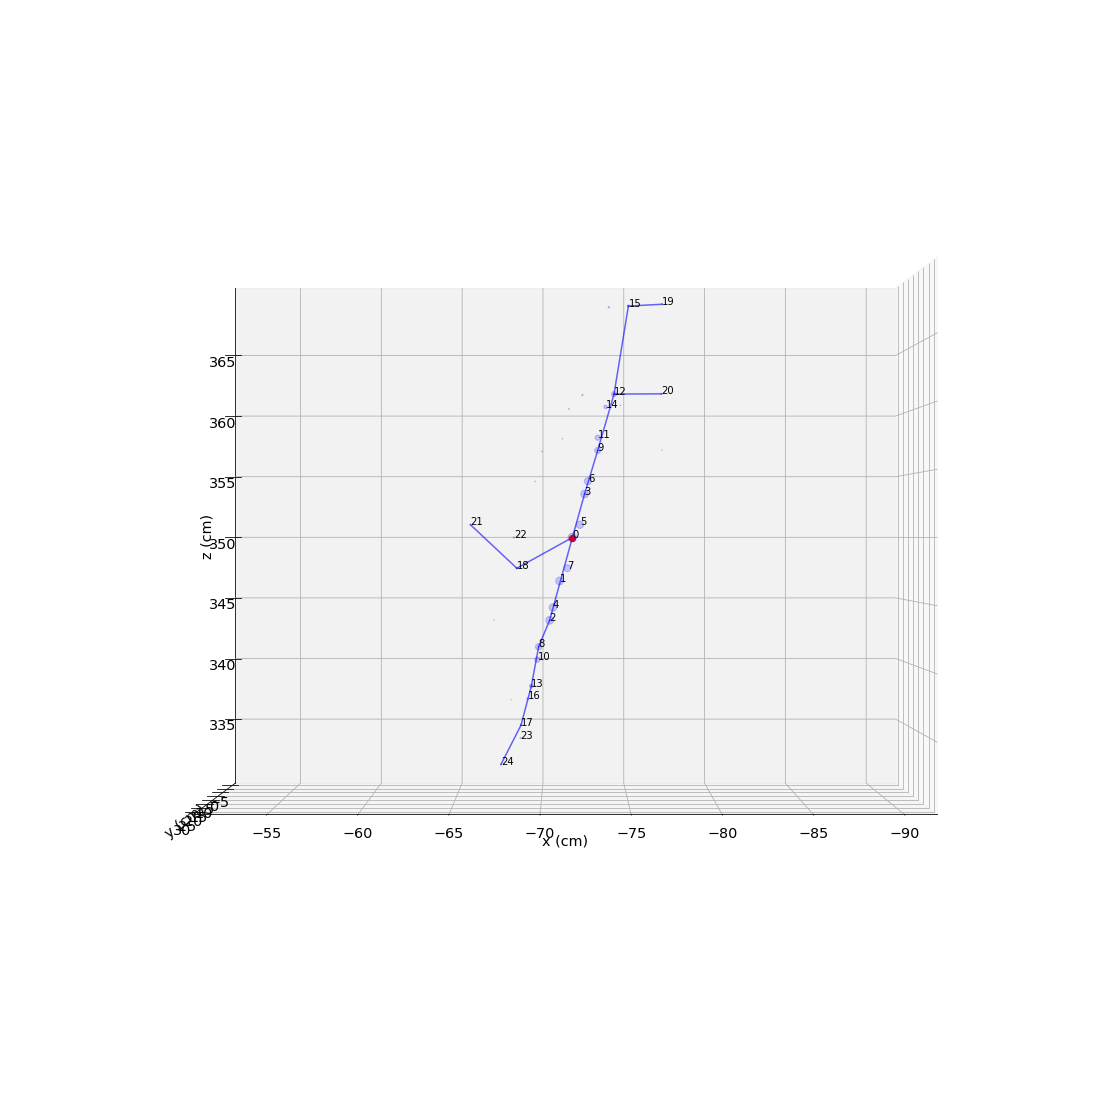

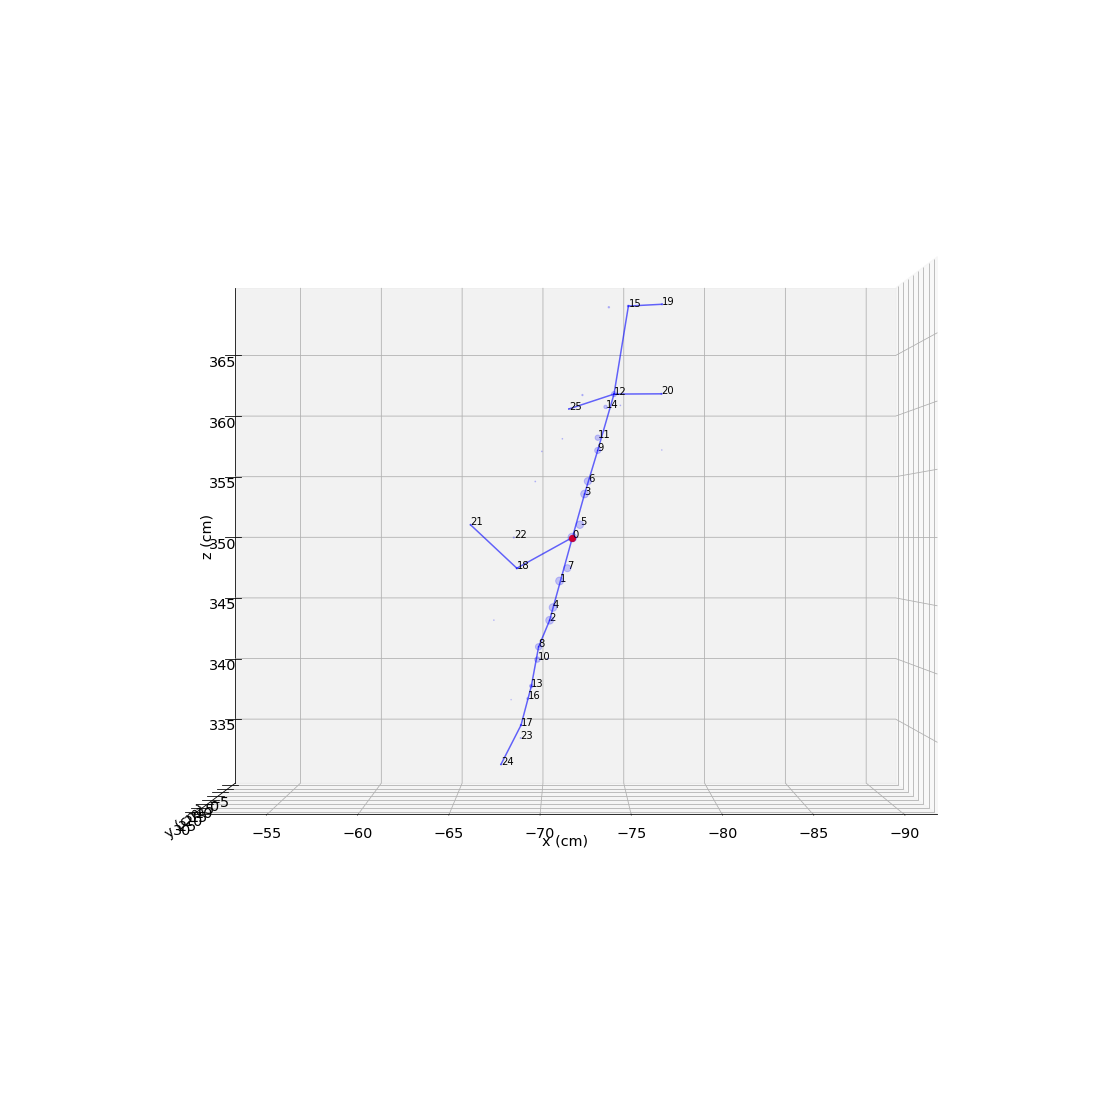

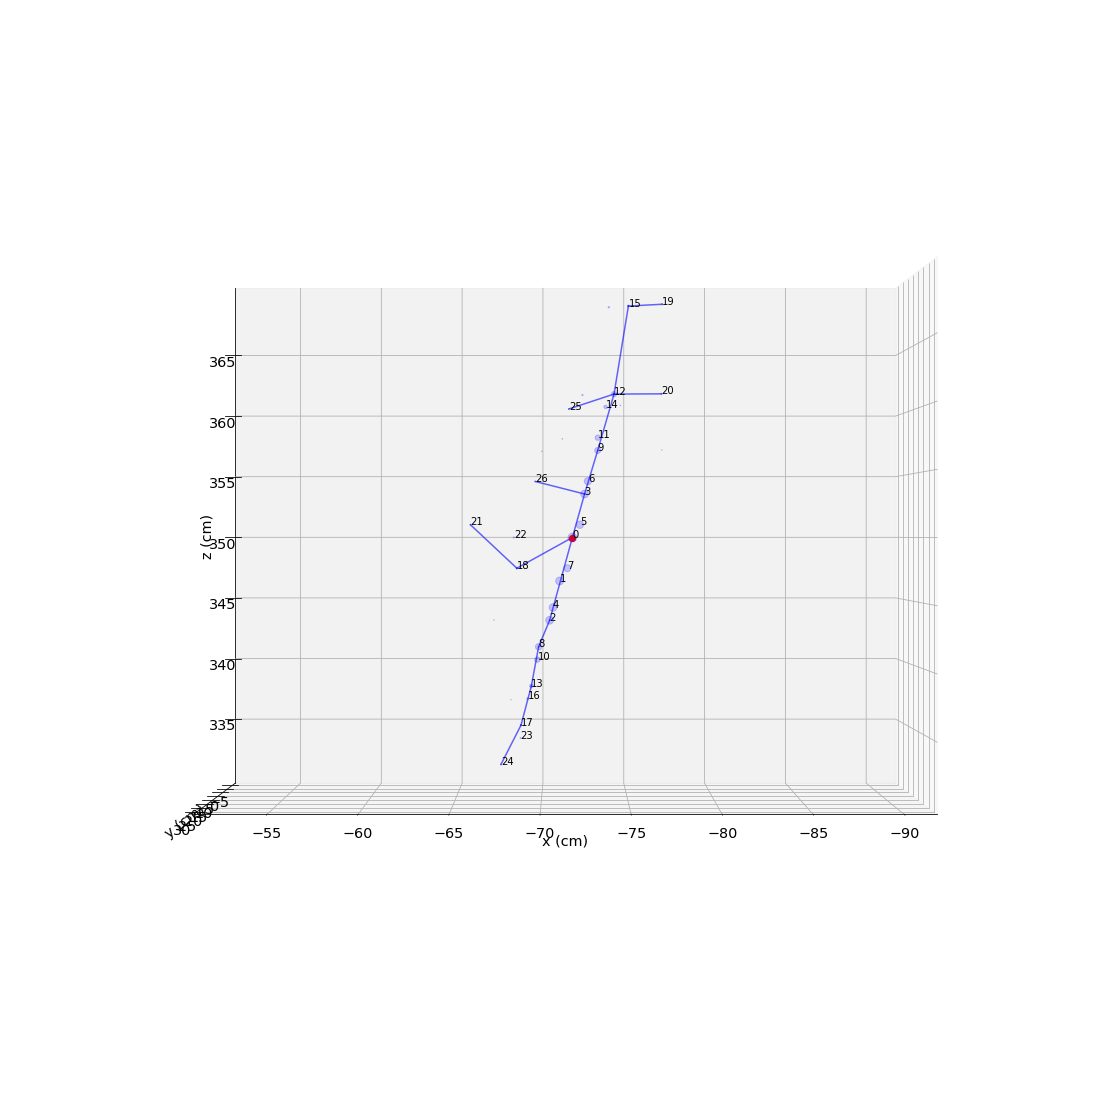

In [96]:
%matplotlib inline
MAX_ITER = 30
ANGLE_THR = 1.5 # ~ 85 degrees
DST_threshold = 2 # 2 cm - if the LC are further than 2 cm apart, we connect them with an edge
all_edges, all_nodes = [], []

for MAX_ITER in range(28):
    create_graph(lc_data, vx, vy, vz, ve, vi, DST_threshold=2, ANGLE_THR=1.5, sort_by_z=False, MAX_ITER=MAX_ITER)

In [97]:
%matplotlib widget

def create_graph_pca(vx, vy, vz, ve, vi, bx, by, bz, be, bigTracksters, ev=0, DST_threshold=2):
    # Project the poits on pca
    edges = {}
    lcx = lc_data.position_x[ev]
    lcy = lc_data.position_y[ev]
    lcz = lc_data.position_z[ev]
    lce = lc_data.energy[ev]
    
    bubble_size = 10
    pileup_alpha = 0.5
    noise_threshold = 0.2


    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Reconstruction of a pion in a high-pileup environment\nLayer Clusters")
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")

    for bigT in bigTracksters:

        vxt = vx[ev][bigT]
        vyt = vy[ev][bigT]
        vzt = vz[ev][bigT]
        vet = ve[ev][bigT]
        vit = vi[ev][bigT]

        bxt = bx[ev][bigT]
        byt = by[ev][bigT]
        bzt = bz[ev][bigT]
        bet = be[ev][bigT]

        pca = WPCA(n_components=3)
        positions = np.array((vxt, vyt, vzt)).T
        vet_array = np.array(vet).reshape(-1,1)
        vet_array = np.tile(vet_array,(1, 3))
        pca.fit(positions, weights = vet_array)
        components = pca.components_
        eigenvalues = pca.explained_variance_

        seed_lc_idx = trk_data.layer_cluster_seed[ev][bigT]
        seed_coord = np.array([lcx[seed_lc_idx], lcy[seed_lc_idx], lcz[seed_lc_idx]])
        edges[(-1, -1)] = (seed_coord, seed_coord)

        ax.scatter(vxt, vyt, vzt, s=vet*bubble_size, alpha=0.2, c="blue", zorder=-5, label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

        
        ax.scatter(bxt, byt, bzt, s=bet*bubble_size/5, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

        segment_start = np.array([bxt, byt, bzt])
        segment_end = np.array([bxt+components[0][0],
                                byt+components[0][1],
                                bzt+components[0][2]])

        data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]

        # project each LC to the principal component
        min_p, max_p = (0,0,99999), (0,0,-99999)
        for x,y,z,e,i,j in data:
            point = np.array([x, y, z])
            dist, closest_point = project_lc_to_pca(np.array([x,y,z]), segment_start, segment_end)

            z_cl = closest_point[2]
            if min_p[2] > z_cl:
                min_p = closest_point
            if max_p[2] < z_cl:
                max_p = closest_point
                
            if dist > DST_threshold:
                # find distance to closest edge
                min_dist, min_edge, closest_point_edge, closest_endpoint, closest_endpoint_id =  find_dist_to_closest_edge(np.array([x,y,z]), edges)
                if min_dist > DST_threshold:
                    # plot the new edge
                    edges[(closest_endpoint_id, j)] = (closest_point_edge, point)
                    ax.plot([x, closest_point[0]], [y, closest_point[1]], [z, z_cl], c='blue', alpha=0.4)
                    # add it to the edge list

        break

    ax.plot([min_p[0], max_p[0]], [min_p[1], max_p[1]], [min_p[2], max_p[2]], c='blue', alpha=0.4)

    set_axes_equal(ax)
    plt.show()


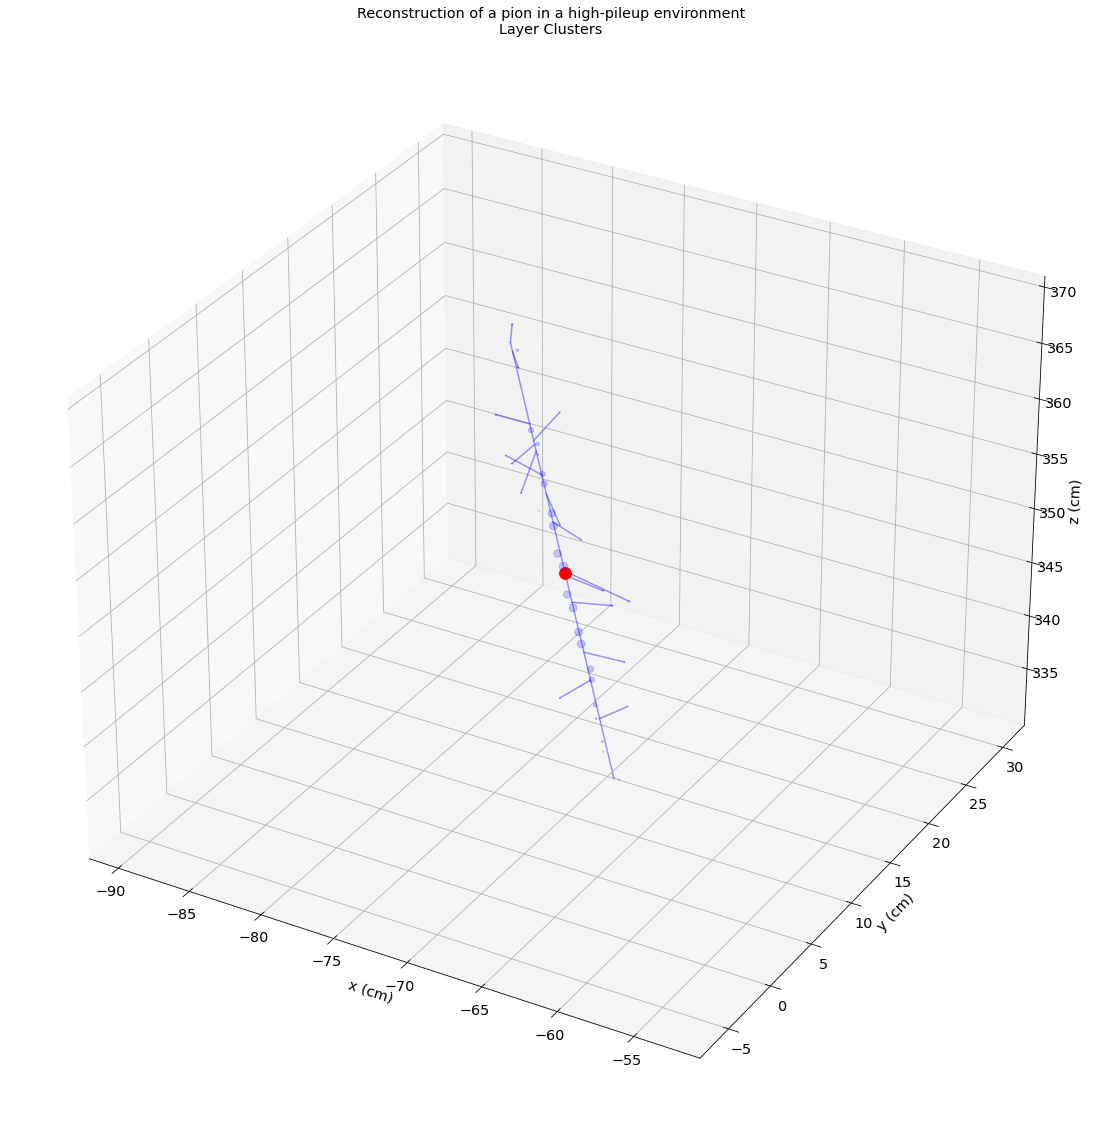

In [99]:
%matplotlib inline
create_graph_pca(vx, vy, vz, ve, vi, bx, by, bz, be, bigTracksters, DST_threshold=2)

# Hackathon Graph
Based on the distance VS energy "density" plots, we estimated that the threshold to use will be 0.1-0.2 m distance in x-y plane

In [123]:
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

def distance_matrix(trk_x, trk_y, trk_z):
    v_matrix = np.concatenate(([trk_x], [trk_y], [trk_z]))
    gram = v_matrix.T.dot(v_matrix)

    distance = np.zeros(np.shape(gram))
    for row in range(np.shape(distance)[0]):
        for col in range(np.shape(distance)[1]): #half of the matrix is sufficient, but then mask doesn't work properly
            distance[row][col] = (gram[row][row]-2*gram[row][col]+gram[col][col])**0.5 #= 0 if row==col else
    #print('\n'.join(['\t'.join([str("{:.2f}".format(cell)) for cell in row]) for row in distance]))
    return distance

def create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=0, DST_THR=2, pca_length=30, bubble_size = 10, NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.05):
    # Project the poits on pca
    edges = {}
    
    bigTracksters = get_major_PU_tracksters(
    zip(reco2sim_index[ev], reco2sim_sharedE[ev], reco2sim_score[ev]),
    sim_raw_energy[ev],
    )
    print(bigTracksters)
    
    
    pileup_alpha = 0.5
    noise_threshold = 0.2

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Reconstruction of a pion in a high-pileup environment\nLayer Clusters")
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")
    
    lcx = lc_data.position_x[ev]
    lcy = lc_data.position_y[ev]
    lcz = lc_data.position_z[ev]
    lce = lc_data.energy[ev]

    for bigT in bigTracksters:

        vxt = vx[ev][bigT]
        vyt = vy[ev][bigT]
        vzt = vz[ev][bigT]
        vet = ve[ev][bigT]
        vit = vi[ev][bigT]
        
        dist_matrix = distance_matrix(vxt, vyt, vzt)
        
        seed_lc_idx = trk_data.layer_cluster_seed[ev][bigT]
        
        seed_x = lcx[seed_lc_idx]
        seed_y = lcy[seed_lc_idx]
        seed_z = lcz[seed_lc_idx]
        seed_e = lce[seed_lc_idx]
        
        vz_seed = lc_data.position_z[ev][seed_lc_idx]
        pca_lower_z = WPCA(n_components=3)
        pca_higher_z = WPCA(n_components=3)
        
        positions_higher_z = np.array((vxt[vzt >= vz_seed], vyt[vzt >= vz_seed], vzt[vzt >= vz_seed])).T
        positions_lower_z = np.array((vxt[vzt <= vz_seed], vyt[vzt <= vz_seed], vzt[vzt <= vz_seed])).T
        
        vet_array_higher_z = np.array(vet[vzt >= vz_seed]).reshape(-1,1)
        vet_array_higher_z = np.tile(vet_array_higher_z,(1, 3))
        
        vet_array_lower_z = np.array(vet[vzt <= vz_seed]).reshape(-1,1)
        vet_array_lower_z = np.tile(vet_array_lower_z,(1, 3))
        
        pca_lower_z.fit(positions_lower_z, weights = vet_array_lower_z)
        pca_higher_z.fit(positions_higher_z, weights = vet_array_higher_z)
        
        components_lower_z = pca_lower_z.components_
        eigenvalues_lower_z = pca_lower_z.explained_variance_
        
        components_higher_z = pca_higher_z.components_
        eigenvalues_higher_z = pca_higher_z.explained_variance_
        
        seed_coord = np.array([lcx[seed_lc_idx], lcy[seed_lc_idx], lcz[seed_lc_idx]])
        edges[(-1, -1)] = (seed_coord, seed_coord)

        ax.scatter(vxt, vyt, vzt, s=vet*bubble_size, alpha=0.2, c="blue", zorder=-5, label=f"{len(vet)} LC: {sum(vet):.2f} GeV")
        ax.scatter(seed_x, seed_y, seed_z, s=seed_e*bubble_size/2, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

        if components_lower_z[0][2] < 0:
#             ax.plot([seed_x, seed_x+pca_length*components_lower_z[0][0]],
#              [seed_y, seed_y+pca_length*components_lower_z[0][1]],
#              [seed_z, seed_z+pca_length*components_lower_z[0][2]], c='red')
            
            lower_segment_end = np.array([seed_x+components_lower_z[0][0],
                                seed_y+components_lower_z[0][1],
                                seed_z+components_lower_z[0][2]])
        else:
#             ax.plot([seed_x, seed_x-pca_length*components_lower_z[0][0]],
#              [seed_y, seed_y-pca_length*components_lower_z[0][1]],
#              [seed_z, seed_z-pca_length*components_lower_z[0][2]], c='red')
            
            lower_segment_end = np.array([seed_x-components_lower_z[0][0],
                                seed_y-components_lower_z[0][1],
                                seed_z-components_lower_z[0][2]])
            
        if components_higher_z[0][2] < 0:        
#             ax.plot([seed_x, seed_x-pca_length*components_higher_z[0][0]],
#              [seed_y, seed_y-pca_length*components_higher_z[0][1]],
#              [seed_z, seed_z-pca_length*components_higher_z[0][2]], c='green')
            
            higher_segment_end = np.array([seed_x-components_higher_z[0][0],
                                seed_y-components_higher_z[0][1],
                                seed_z-components_higher_z[0][2]])
            
        else:
#             ax.plot([seed_x, seed_x+pca_length*components_higher_z[0][0]],
#              [seed_y, seed_y+pca_length*components_higher_z[0][1]],
#              [seed_z, seed_z+pca_length*components_higher_z[0][2]], c='green')
            
            higher_segment_end = np.array([seed_x+components_higher_z[0][0],
                                seed_y+components_higher_z[0][1],
                                seed_z+components_higher_z[0][2]])

        segment_start = np.array([seed_x, seed_y, seed_z])

        data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]

        # project each LC to the principal component
        min_p, max_p = (0,0,99999), (0,0,-99999)
        
        for x,y,z,e,i,j in data:
            
            point = np.array([x, y, z])
            # if energy density is low: don't do anything for now 
            # else - create main edges
            
           

            if z > seed_z:
                dist, closest_point = project_lc_to_pca(point, segment_start, higher_segment_end)
            else:
                dist, closest_point = project_lc_to_pca(point, segment_start, lower_segment_end)

            

            z_cl = closest_point[2]
            if min_p[2] > z_cl:
                min_p = closest_point
            if max_p[2] < z_cl:
                max_p = closest_point
                
            #ax.text(x, y, z, str(j))
            
            print(j, e/seed_e, dist)
            if e / seed_e > ENERGY_RATIO_THR and dist > DST_THR:
                # and not covered by any other edges
                min_dist, min_edge, closest_point_edge, closest_endpoint, closest_endpoint_id =  find_dist_to_closest_edge(point, edges)
                if min_dist < DST_THR:
                    continue
                
                print(f"big: {dist}")
                
                # find neares higher
                # go through all points, if the point is within the Neighbour_threshold = 10
                distances = dist_matrix[j]
                indices = np.argsort(distances)
                for idx in indices:
                
                    if distances[idx] < NEIGHBOUR_THR and vet[idx] > e and abs(vzt[idx]) < abs(z):
                        # found the nearest higher
                        # create an edge - to projection of the nearest higher to the pca
                        #edges[(idx, j)] = (np.array([vxt[idx], vyt[idx], vzt[idx]]), point)
                        #ax.plot([vxt[idx], x], [vyt[idx], y], [vzt[idx], z], c='blue')
                        nearest_higher = np.array([vxt[idx], vyt[idx], vzt[idx]])
                        if z > seed_z:
                            dist, closest_point = project_lc_to_pca(nearest_higher, segment_start, higher_segment_end)
                        else:
                            dist, closest_point = project_lc_to_pca(nearest_higher, segment_start, lower_segment_end)
                            
                        edges[(idx, j)] = (closest_point, point)
                        ax.plot([closest_point[0], x], [closest_point[1], y], [closest_point[2], z], c='blue')

                        break
        
        ax.plot([seed_x, min_p[0]], [seed_y, min_p[1]], [seed_z, min_p[2]], c='red')
        ax.plot([seed_x, max_p[0]], [seed_y, max_p[1]], [seed_z, max_p[2]], c='green')
        
        break

    set_axes_equal(ax)
    plt.show()
    return edges


[0]
0 0.015385856990380482 0.2463720035305108
1 0.01658355666825614 0.44941827858235334
2 0.03952414205918285 0.30703869014196983
3 0.052146079117794945 0.3619846981048715
4 0.004330150918663854 1.9917342934236615
5 0.1797933918049629 0.19086735650272843
6 0.008476040573591649 2.7647485442608715
7 0.3885159025164216 0.10901848537714943
8 0.5387813128914931 0.07800065162027305
9 0.797530887942643 0.1097761580602169
10 0.006172768434662038 3.1291996736752634
11 0.7553349346296906 0.08439002867577834
12 0.8151739773688665 0.07569933610311608
13 0.6513874501895003 0.23428324609462917
14 0.039117130983910516 2.6487258710580903
15 1.0 0.0
16 0.02163461508439153 3.5781920204121827
17 0.024475521869035573 6.643272520393853
18 0.7326266172722693 0.23885093451709338
19 0.7781357977910404 0.061229686806153004
20 0.6889202689798205 0.07868907326012811
21 0.009506118069149826 3.4683192839030363
22 0.005463285730735922 4.252618346713634
23 0.4875983314778378 0.181269819923183
24 0.00721153771097883 

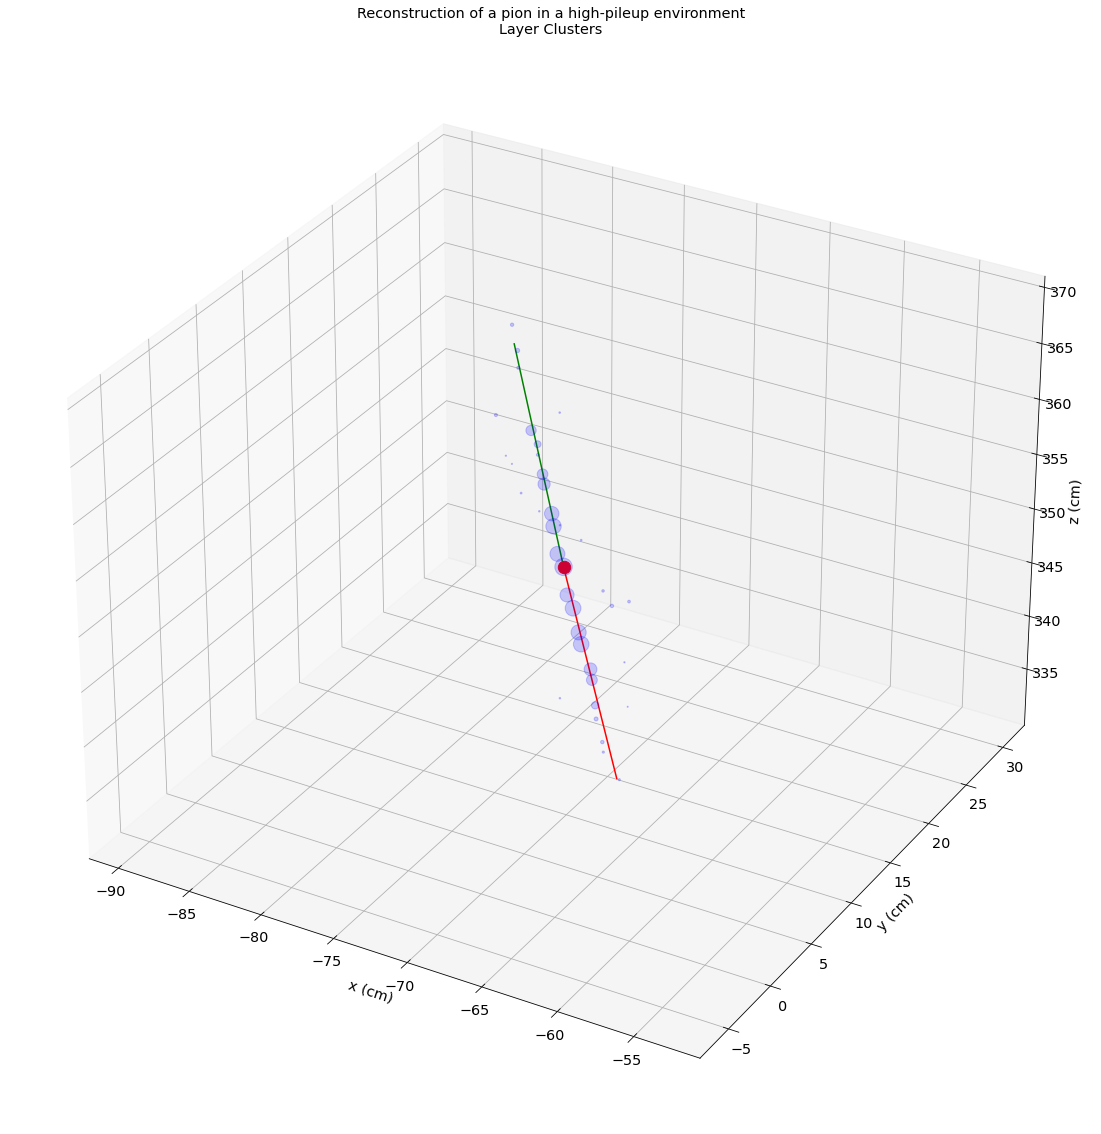

In [124]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=0, DST_THR=2, bubble_size=40, ENERGY_RATIO_THR=0.05)
plt.show()

[0]
0 0.0010185227176101389 0.7972362446128951
1 0.01944838365279939 0.2583903086023571
2 0.034251685296607756 0.20511046807706076
3 0.10225735537408283 0.25321655246756664
4 0.22651717462879248 0.19786384049627034
5 0.39330409272301026 0.02240061292080083
6 0.5210477471997201 0.10745000433941773
7 0.8111260637583293 0.0368295181399942
8 0.8125265125542349 0.08164682119770021
9 1.0 0.0
10 0.8045636219765275 0.1438824308264616
11 0.7959598767678477 0.11129408353497969
12 0.6160674355839794 0.03629269954081107
13 0.5471125220862946 0.15964102742025904
14 0.42136460244599205 0.06424374934750482
15 0.3579243002291701 0.14681190385955092
16 0.24668291722844984 0.07683440800184745
17 0.18135287744647033 0.08336986113375297
18 0.10550357916393673 0.1389252473987377
19 0.08630445720113976 0.8117416289342655
20 0.04707350111281251 0.501374056104041
21 0.043806963826586914 0.40528581766345867
22 0.05336742441596845 0.7572901439849345


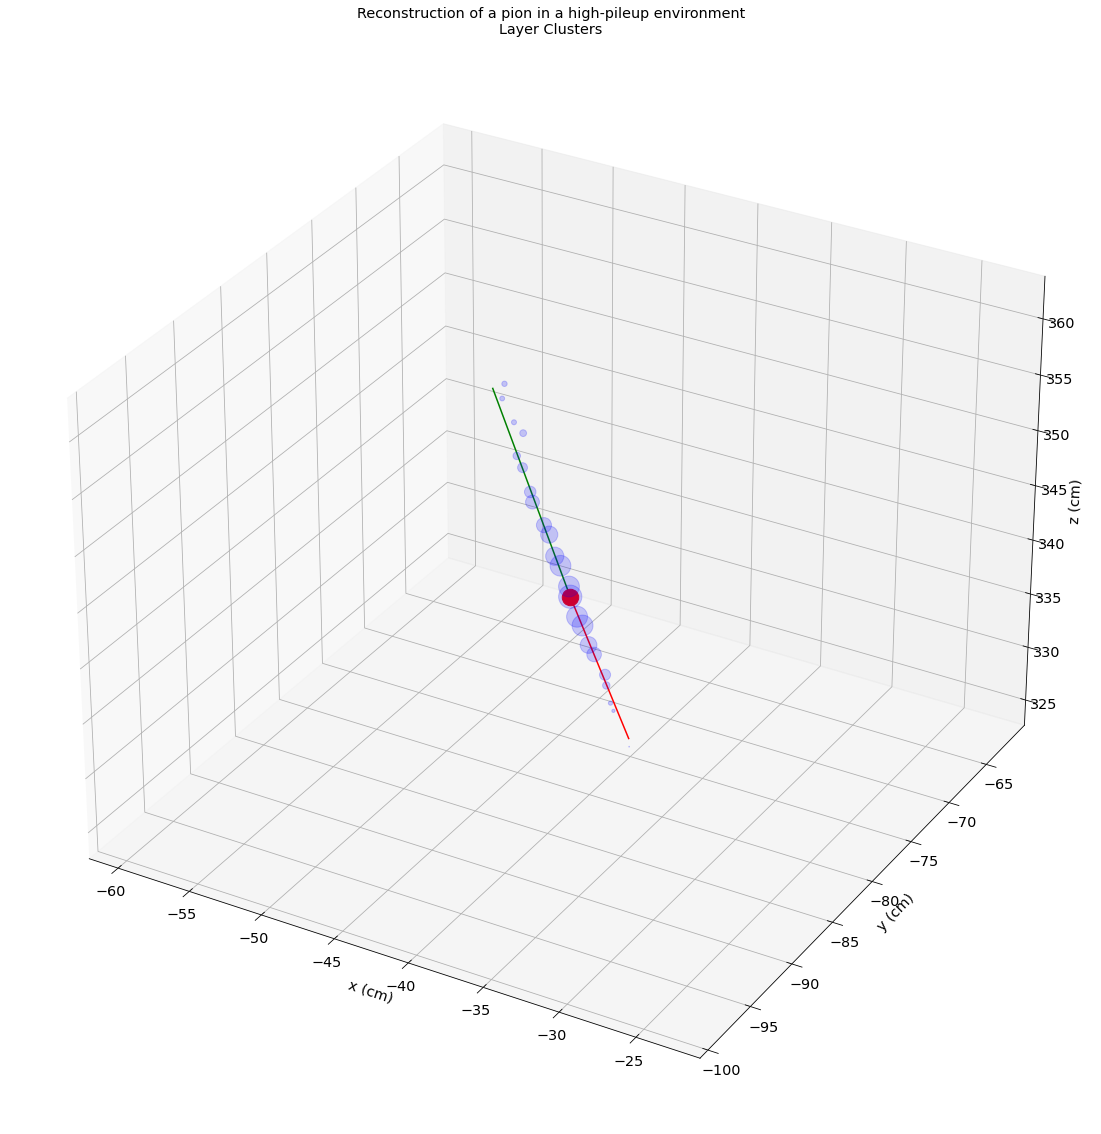

{(-1, -1): (array([-41.29122925, -80.07343292, 340.49700928]),
  array([-41.29122925, -80.07343292, 340.49700928]))}

In [125]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=1, DST_THR=2, ENERGY_RATIO_THR=0.05)

[2]
0 0.013394251038734852 1.2669776022981387
1 0.004130215919596658 5.151306202806275
2 0.08667663086761439 0.9032323167425425
3 0.0029722112231033554 4.110283927183918
4 0.0025090094262663083 3.1980753108698714
5 0.20448429072477958 0.49529502327788294
6 0.008453432690075762 2.6020051898513876
7 0.008762233887967126 5.477171267220206
8 0.30511487567100987 0.22304980110704195
9 0.0021230081333027885 2.8485212989263036
10 0.010036037705065233 4.19835276684555
11 0.0037056139658950033 5.6003347625716815
12 0.008993834581984965 2.9028895712531537
13 0.5429303970728933 0.2752730233053497
14 0.004825018410451543 2.9787949182735414
15 0.621944834393714 0.3640798068397284
16 0.016327862009901443 3.654908400722363
17 0.6110129755256047 1.0078946628473326
18 0.004284616518542341 5.104859554169825
19 0.00451621762136155 3.1652066358275532
20 0.611498880106629 1.165172706943536
21 0.4893549954193316 1.4697503846859208
22 1.0 0.0
23 0.009379836283749856 2.457342562619169
24 0.002547609678203072 4

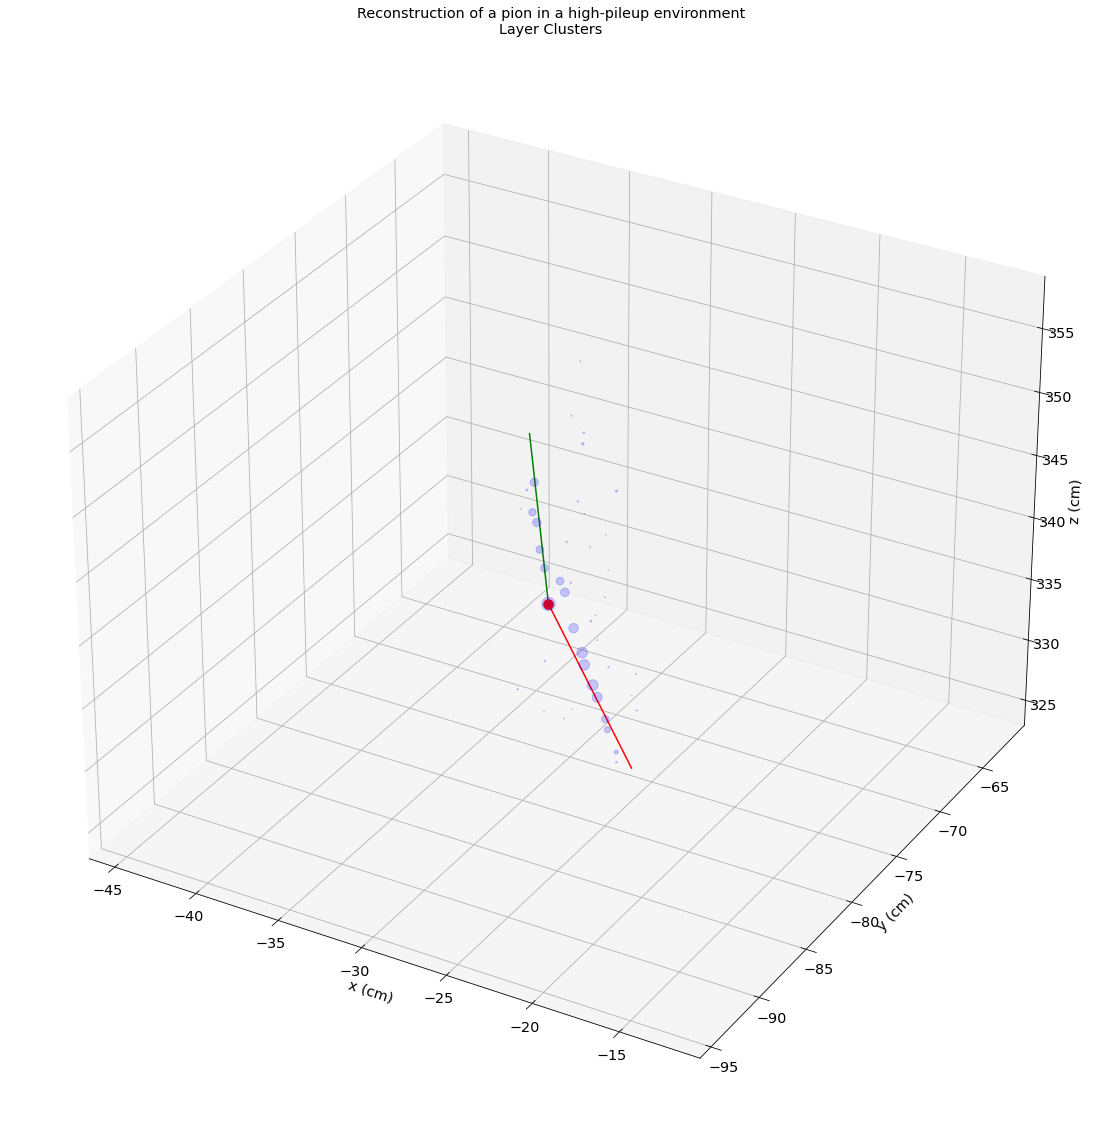

{(-1, -1): (array([-29.10081482, -78.79649353, 338.43399048]),
  array([-29.10081482, -78.79649353, 338.43399048]))}

In [126]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=2, DST_THR=2, ENERGY_RATIO_THR=0.05)

[1, 5]
0 0.015809321506311712 1.3089600417656804
1 0.00477038849526199 1.751482678556038
2 0.006618207659155517 0.7628214297540516
3 0.325348025564743 0.05944788541603976
4 1.0 0.0
5 0.7798548939005214 0.30580942106528
6 0.5465865873495298 0.21555170314533076
7 0.17573132296222294 0.8383706907443815


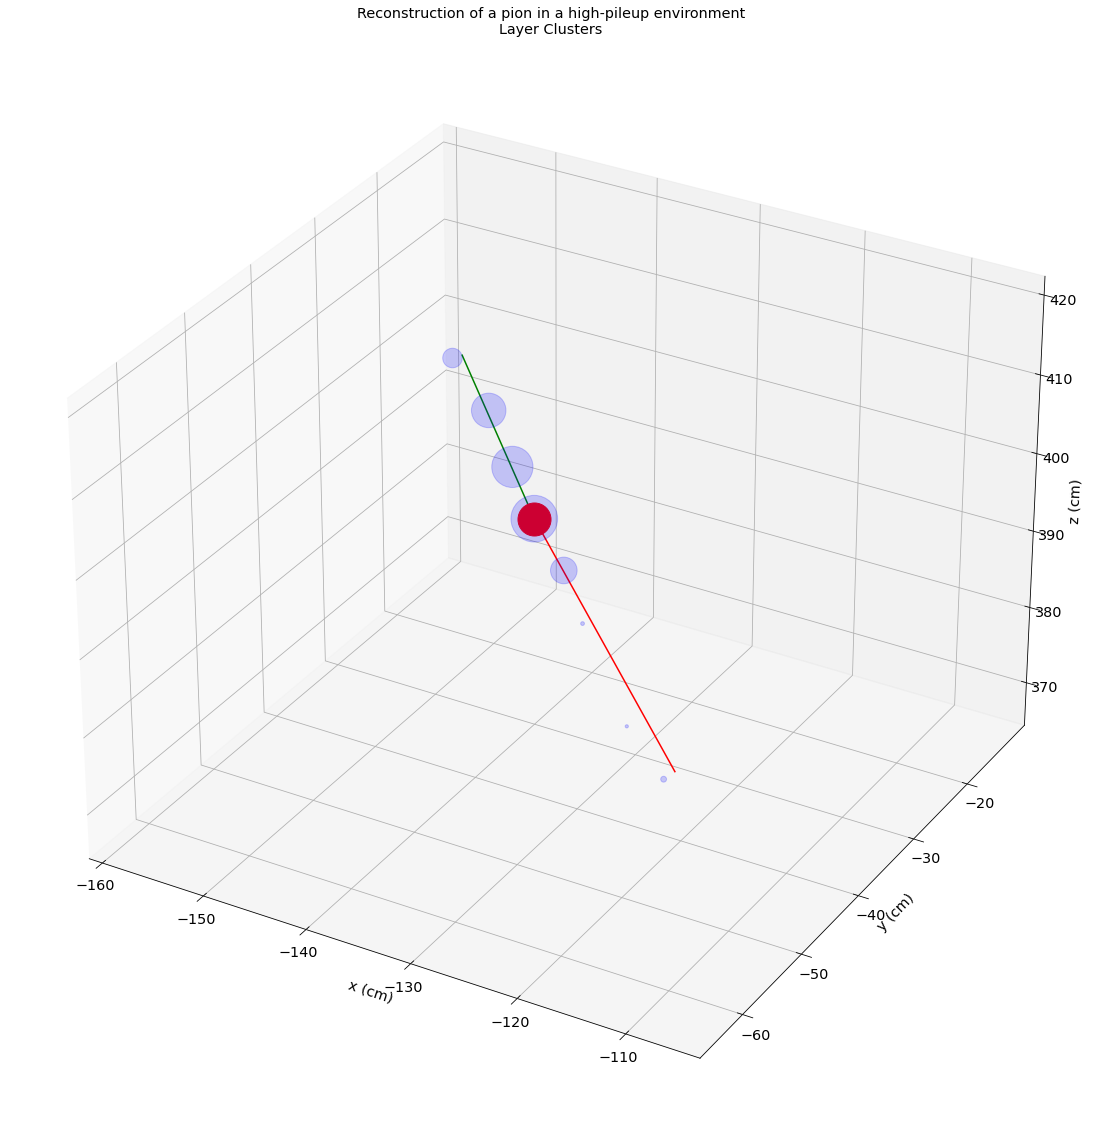

{(-1, -1): (array([-134.6091156 ,  -39.14060974,  399.50100708]),
  array([-134.6091156 ,  -39.14060974,  399.50100708]))}

In [127]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=3, DST_THR=2, ENERGY_RATIO_THR=0.05, bubble_size=30)

[4]
0 0.0006508763764398626 3.522502598822308
1 0.04921684144492921 1.0273747650408143
2 0.0009536096148608198 3.4322286382488407
3 0.010050741864410174 0.40090001079531495
4 0.0064330809858114514 2.4680608862203925
5 0.001407709412377003 5.158685745727621
6 0.005080368853903779 0.5714098980279951
7 0.010053025923394904 1.3250148707214142
8 0.009424711562721712 0.12745724179149534
9 0.047410785605075924 0.28333223645435196
10 0.07756986978755424 0.2366215349685063
11 0.104650201483499 0.03852158105850776
12 0.17748978383122005 0.14034560166137203
13 0.15545390092343594 0.1553946730075808
14 0.2025146163359551 0.10310449077320417
15 0.7729913454350379 0.09402073163366853
16 1.0 0.0
17 1.0092254129886435 1.1244059454751556
18 0.5309258046946279 0.5627900872201569
19 0.01529625837845673 0.7831517326681599
20 0.03773076664848927 1.5214962975776272
21 0.01959377755747303 0.7580171660381794
22 0.02818881719796435 3.1114992954643306
23 0.012773851875237819 4.82362997247418


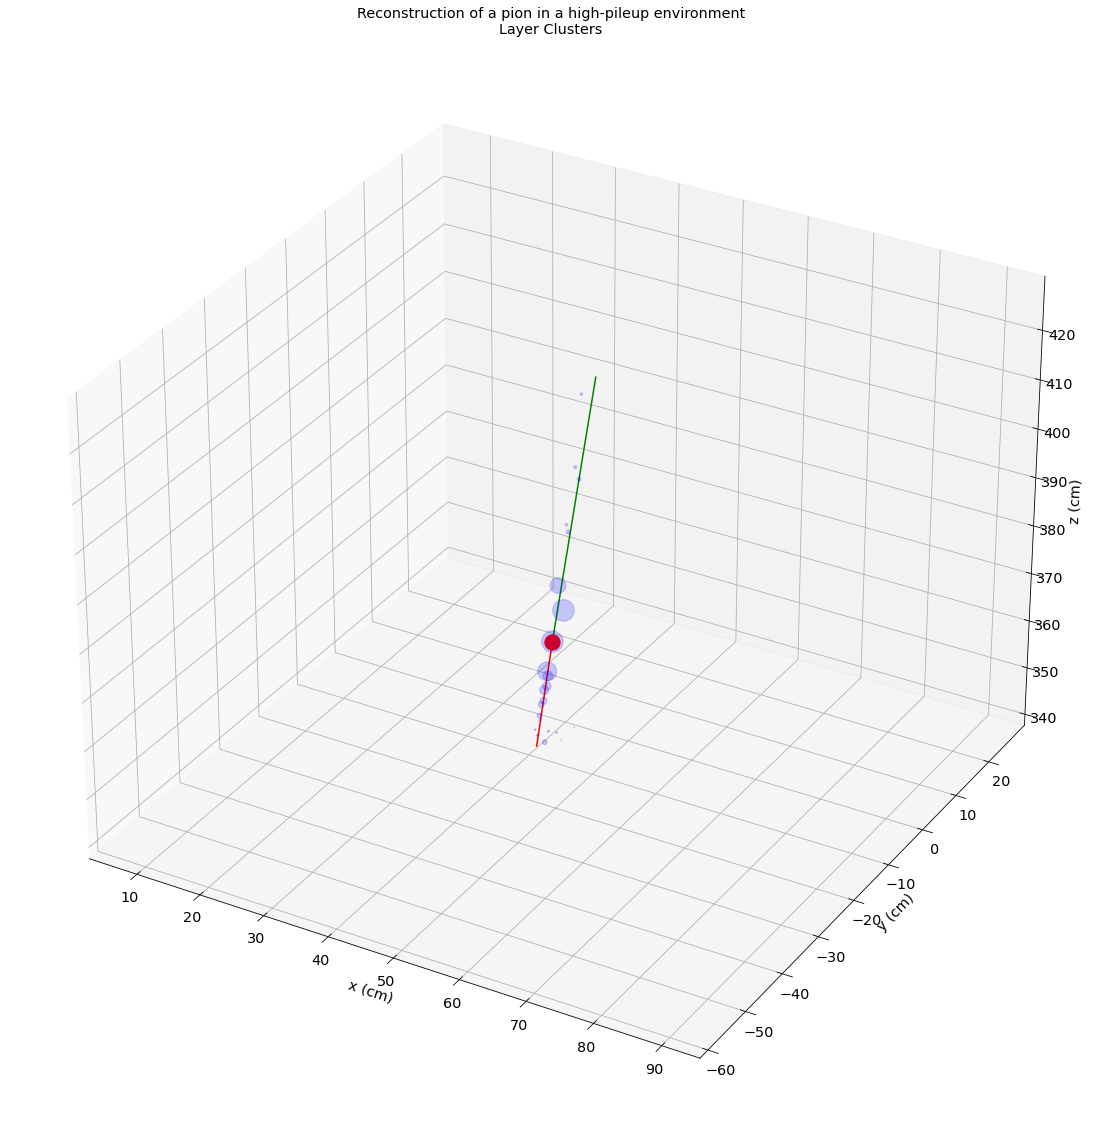

{(-1, -1): (array([ 46.70983505, -15.13011837, 367.97601318]),
  array([ 46.70983505, -15.13011837, 367.97601318]))}

In [128]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=4, DST_THR=2, ENERGY_RATIO_THR=0.05)

[0]
0 0.016763983682562128 1.384307374566307
1 0.04480840526242628 1.644156504571555
2 0.0636091284541867 0.18188336961266274
3 0.23328569151485373 0.16103509275605193
4 0.4680555925756921 0.09066524430881906
5 0.005640218948651012 4.057005670558479
6 0.661115026691135 0.10454277193901214
7 0.8733754162906984 0.11960744180586502
8 1.0 0.0
9 0.011593784224083836 2.49259753525062
10 0.7071674689387485 0.2411859946434547
11 0.7744176177950953 0.89864753875849
12 0.5012635931304456 0.7114394331552417
13 0.015510601693973015 2.445767730341835
14 0.8508626128395886 1.247572416505287
15 0.6761053147901563 0.2471421757343668
16 0.019510190142147058 2.0507388272556204
17 0.5626456108165017 0.25595538543017254
18 0.03405372668116346 4.729559735050536
19 0.5758529147437287 0.29382655633636134
20 0.00892027034245296 4.3933044221904165
21 1.0352500961845095 1.4724891645211544
22 0.035861586614854286 6.9504464008936955
23 0.011706113421580608 3.7513569231911017
24 0.5543901498566869 0.44207063380805

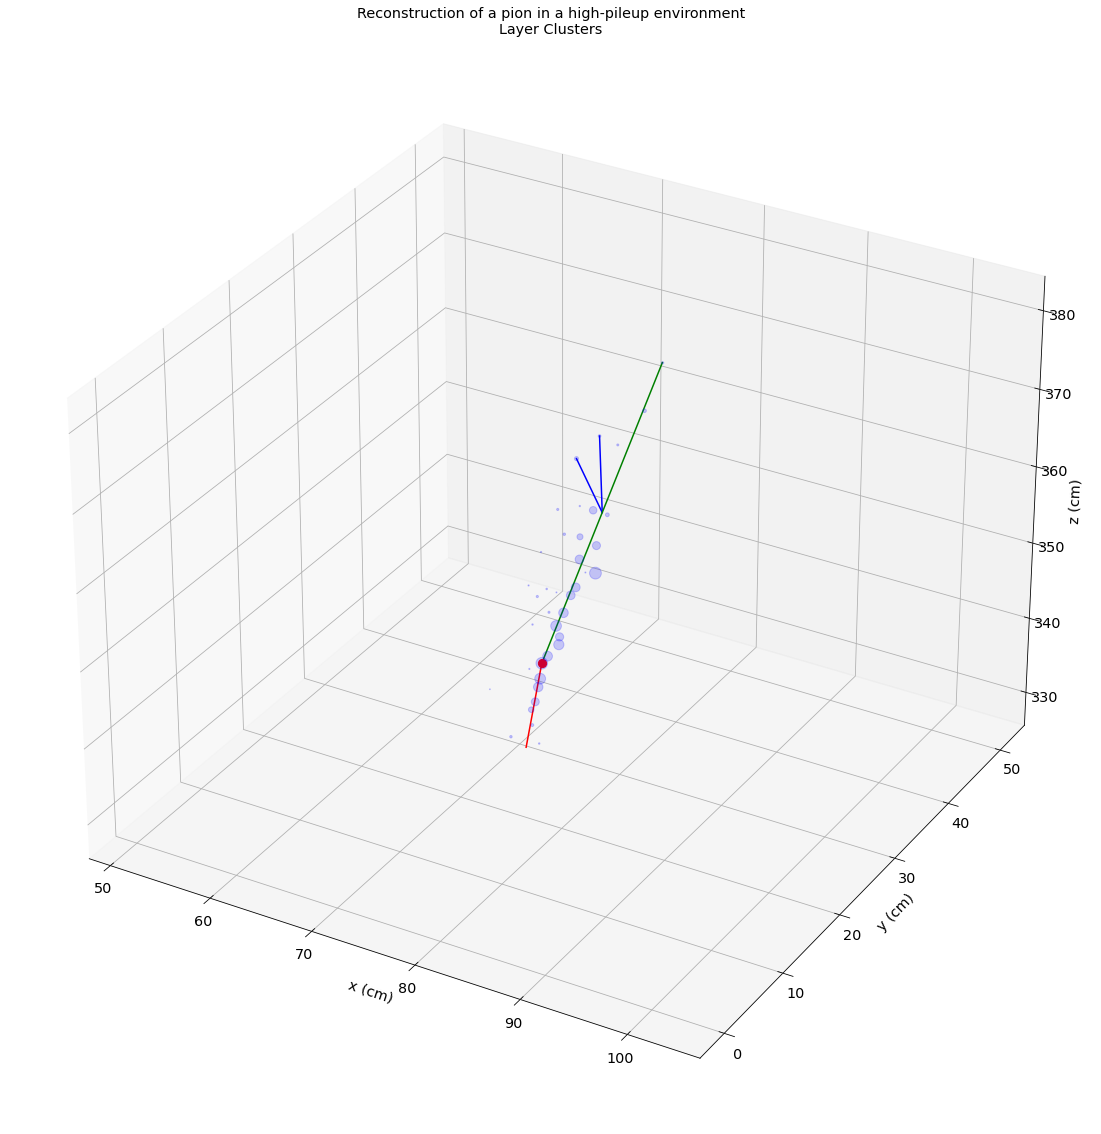

{(-1, -1): (array([ 74.23290253,  26.58647346, 340.49700928]),
  array([ 74.23290253,  26.58647346, 340.49700928])),
 (33, 34): (array([ 79.14625582,  28.28792073, 360.93686369]),
  array([ 77.37234497,  27.02744293, 367.97601318])),
 (33, 35): (array([ 79.14625582,  28.28792073, 360.93686369]),
  array([ 77.09253693,  31.40253067, 367.97601318]))}

In [129]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=6, DST_THR=2, ENERGY_RATIO_THR=0.05, bubble_size=30)

[2]
0 0.08485086077347893 0.599310739605376
1 0.31465230431681956 0.10777736578606147
2 0.5261722498864734 0.09321518047064707
3 1.0 0.0
4 0.33117413029264114 0.6906788376668666
5 0.18986199691332498 0.7142642113339095
6 0.1617018709651243 0.1986463701075814
7 0.16320829282527516 0.20731103339085635
8 0.18345080670204847 0.22874585415781418
9 0.11023724132711421 0.6248896333967727
10 0.005759118775153359 2.2332587044695886
11 0.008072679136971595 1.894228155477075
12 0.004671234803626297 2.4016059355065584


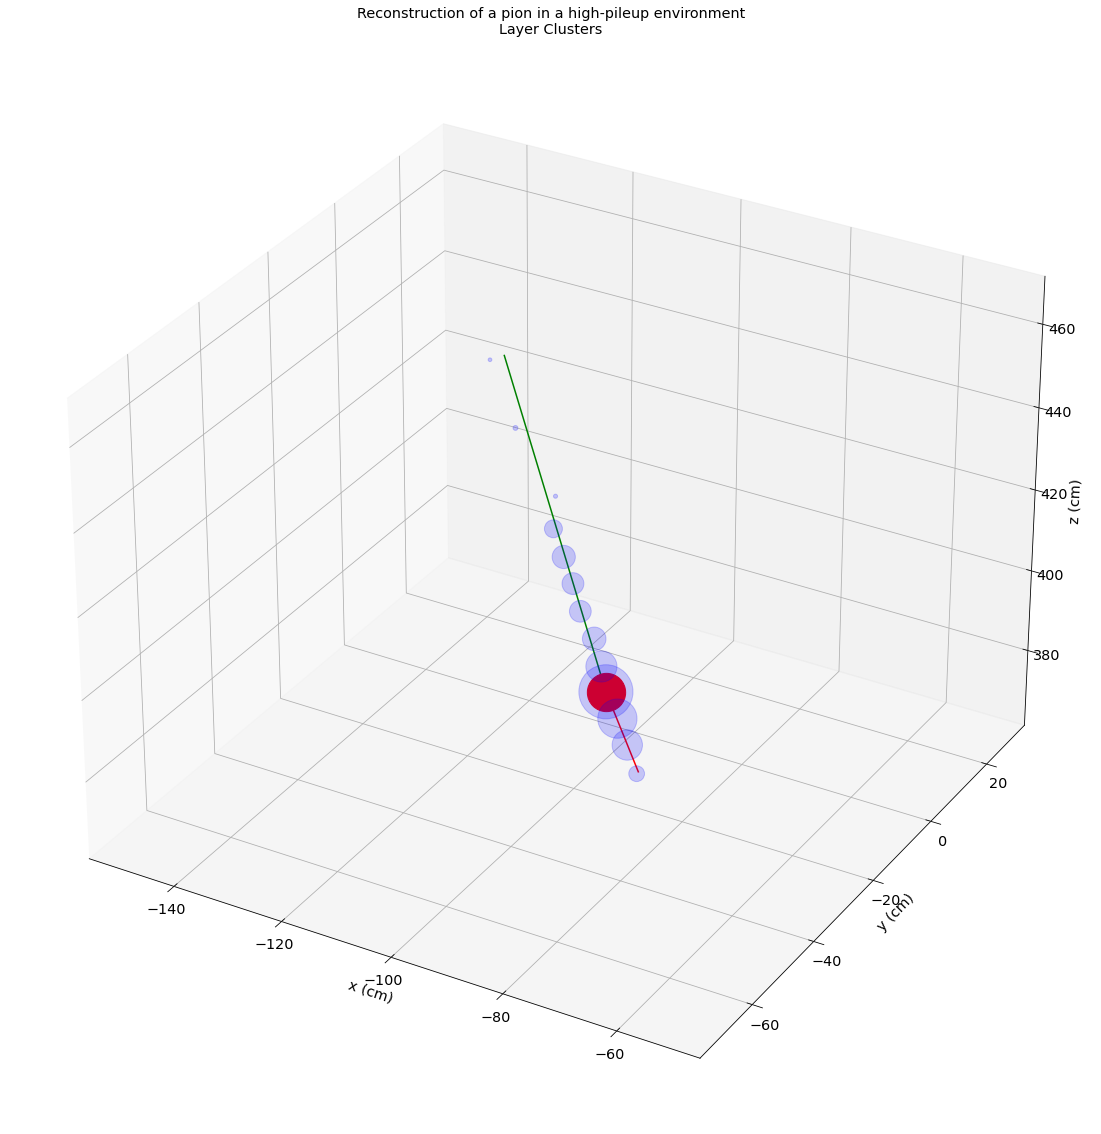

{(-1, -1): (array([-94.57395172, -19.18592262, 386.89099121]),
  array([-94.57395172, -19.18592262, 386.89099121]))}

In [130]:
create_skeletons(vx, vy, vz, ve, vi, bx, by, bz, be, ev=7, DST_THR=2, ENERGY_RATIO_THR=0.05, bubble_size=30)

# Event Graph Creation

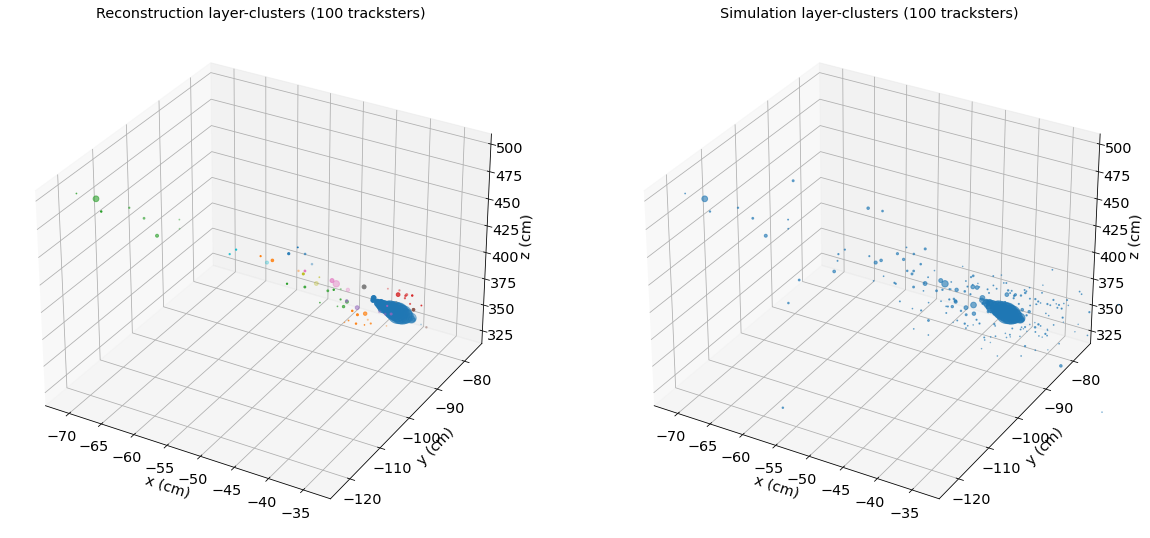

In [175]:
eid = 1

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121, projection='3d')

ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
ax1.set_zlabel("z (cm)")

for x, y, z, e in zip(vx[eid], vy[eid], vz[eid], ve[eid]):
    ax1.scatter(x, y, z, s=8*e)

ax1.set_title(f"Reconstruction layer-clusters ({len(vx)} tracksters)")


ax2 = fig.add_subplot(122, projection='3d')
ax2.set_xlabel("x (cm)")
ax2.set_ylabel("y (cm)")
ax2.set_zlabel("z (cm)")
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
ax2.set_zlim(ax1.get_zlim())

for x, y, z, e in zip(vx_sim[eid], vy_sim[eid], vz_sim[eid], ve_sim[eid]):
    ax2.scatter(x, y, z, s=8*e, alpha=0.6)

ax2.set_title(f"Simulation layer-clusters ({len(vx_sim)} tracksters)")

plt.show()

In [189]:
def find_dist_to_closest_edge_set(point, edges):
    """
    point: np.array (x,y,z)
    edges: set
    
    """
    min_dist = np.inf
    min_edge = None
    closest_point = None
    closest_endpoint = None
    point = np.array(point)
    
    for (segment_start, segment_end) in edges:
        
        segment_start, segment_end = np.array(segment_start), np.array(segment_end)
        dist, closest_point_tmp, closest_endpoint_tmp = distance_point_to_segment_set(point, segment_start, segment_end)
        
        if dist < min_dist:
            min_dist = dist
            closest_point = closest_point_tmp
            closest_endpoint = closest_endpoint_tmp
            
    return min_dist, min_edge, closest_point, closest_endpoint

def distance_point_to_segment_set(point, segment_start, segment_end):
    """
    `point` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    point_vector = point - segment_start
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    if projection <= 0:
        
        return np.linalg.norm(point_vector), segment_start, segment_start
    elif projection > 1:
            
        return np.linalg.norm(point - segment_end), segment_end, segment_end
    else:
        closest_point = segment_start + projection * segment_vector
        closest_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else segment_end
        
        return np.linalg.norm(point - closest_point), closest_point, closest_endpoint

def create_tr_skeletons(vx, vy, vz, ve, vi, ev, tr_id, DST_THR=2, bubble_size=10, NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.05):
    # Project the poits on pca
    edges = set()
    nodes = set()

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Reconstruction of a pion in a high-pileup environment\nLayer Clusters")
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")
    
    lcx = lc_data.position_x[ev]
    lcy = lc_data.position_y[ev]
    lcz = lc_data.position_z[ev]
    lce = lc_data.energy[ev]

    vxt = vx[ev][tr_id]
    vyt = vy[ev][tr_id]
    vzt = vz[ev][tr_id]
    vet = ve[ev][tr_id]
    vit = vi[ev][tr_id]

    dist_matrix = distance_matrix(vxt, vyt, vzt)

    seed_lc_idx = trk_data.layer_cluster_seed[ev][tr_id]

    seed_x = lcx[seed_lc_idx]
    seed_y = lcy[seed_lc_idx]
    seed_z = lcz[seed_lc_idx]
    seed_e = lce[seed_lc_idx]

    vz_seed = lc_data.position_z[ev][seed_lc_idx]
    pca_lower_z = WPCA(n_components=3)
    pca_higher_z = WPCA(n_components=3)

    positions_higher_z = np.array((vxt[vzt >= vz_seed], vyt[vzt >= vz_seed], vzt[vzt >= vz_seed])).T
    positions_lower_z = np.array((vxt[vzt <= vz_seed], vyt[vzt <= vz_seed], vzt[vzt <= vz_seed])).T

    vet_array_higher_z = np.array(vet[vzt >= vz_seed]).reshape(-1,1)
    vet_array_higher_z = np.tile(vet_array_higher_z,(1, 3))

    vet_array_lower_z = np.array(vet[vzt <= vz_seed]).reshape(-1,1)
    vet_array_lower_z = np.tile(vet_array_lower_z,(1, 3))

    pca_lower_z.fit(positions_lower_z, weights = vet_array_lower_z)
    pca_higher_z.fit(positions_higher_z, weights = vet_array_higher_z)

    components_lower_z = pca_lower_z.components_
    eigenvalues_lower_z = pca_lower_z.explained_variance_

    components_higher_z = pca_higher_z.components_
    eigenvalues_higher_z = pca_higher_z.explained_variance_

    seed_coord = np.array([lcx[seed_lc_idx], lcy[seed_lc_idx], lcz[seed_lc_idx]])
    edges.add((tuple(seed_coord), tuple(seed_coord)))
    nodes.add(tuple(seed_coord))

    ax.scatter(vxt, vyt, vzt, s=vet*bubble_size, alpha=0.2, c="blue", zorder=-5, label=f"{len(vet)} LC: {sum(vet):.2f} GeV")
    ax.scatter(seed_x, seed_y, seed_z, s=seed_e*bubble_size/2, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

    if components_lower_z[0][2] < 0:

        lower_segment_end = np.array([seed_x+components_lower_z[0][0],
                            seed_y+components_lower_z[0][1],
                            seed_z+components_lower_z[0][2]])
    else:
        lower_segment_end = np.array([seed_x-components_lower_z[0][0],
                            seed_y-components_lower_z[0][1],
                            seed_z-components_lower_z[0][2]])

    if components_higher_z[0][2] < 0:
        higher_segment_end = np.array([seed_x-components_higher_z[0][0],
                            seed_y-components_higher_z[0][1],
                            seed_z-components_higher_z[0][2]])

    else:
        higher_segment_end = np.array([seed_x+components_higher_z[0][0],
                            seed_y+components_higher_z[0][1],
                            seed_z+components_higher_z[0][2]])

    segment_start = np.array([seed_x, seed_y, seed_z])

    data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]

    # project each LC to the principal component
    min_p, max_p = (0,0,99999), (0,0,-99999)

    for x,y,z,e,i,j in data:

        point = np.array([x, y, z])
        # if energy density is low: don't do anything for now 
        # else - create main edges
        if z > seed_z:
            dist, closest_point = project_lc_to_pca(point, segment_start, higher_segment_end)
        else:
            dist, closest_point = project_lc_to_pca(point, segment_start, lower_segment_end)

        z_cl = closest_point[2]
        if min_p[2] > z_cl:
            min_p = closest_point
        if max_p[2] < z_cl:
            max_p = closest_point

        #ax.text(x, y, z, str(j))

        print(j, e/seed_e, dist)
        if e / seed_e > ENERGY_RATIO_THR and dist > DST_THR:
            # and not covered by any other edges
            min_dist, min_edge, closest_point_edge, closest_endpoint =  find_dist_to_closest_edge_set(point, edges)
            if min_dist < DST_THR:
                continue

            #print(f"big: {dist}")

            # find neares higher
            # go through all points, if the point is within the Neighbour_threshold = 10
            distances = dist_matrix[j]
            indices = np.argsort(distances)
            for idx in indices:

                if distances[idx] < NEIGHBOUR_THR and vet[idx] > e and abs(vzt[idx]) < abs(z):
                    # found the nearest higher
                    # create an edge - to projection of the nearest higher to the pca
                    #edges[(idx, j)] = (np.array([vxt[idx], vyt[idx], vzt[idx]]), point)
                    #ax.plot([vxt[idx], x], [vyt[idx], y], [vzt[idx], z], c='blue')
                    nearest_higher = np.array([vxt[idx], vyt[idx], vzt[idx]])
                    if z > seed_z:
                        dist, closest_point = project_lc_to_pca(nearest_higher, segment_start, higher_segment_end)
                    else:
                        dist, closest_point = project_lc_to_pca(nearest_higher, segment_start, lower_segment_end)

                    edges.add((tuple(closest_point), tuple(point)))
                    nodes.add(tuple(closest_point))
                    nodes.add(tuple(point))
                    ax.plot([closest_point[0], x], [closest_point[1], y], [closest_point[2], z], c='blue')

                    break

    ax.plot([seed_x, min_p[0]], [seed_y, min_p[1]], [seed_z, min_p[2]], c='red')
    ax.plot([seed_x, max_p[0]], [seed_y, max_p[1]], [seed_z, max_p[2]], c='green')

    set_axes_equal(ax)
    plt.show()
    return edges, nodes


0 0.0010185227176101389 0.7972362446128951
1 0.01944838365279939 0.2583903086023571
2 0.034251685296607756 0.20511046807706076
3 0.10225735537408283 0.25321655246756664
4 0.22651717462879248 0.19786384049627034
5 0.39330409272301026 0.02240061292080083
6 0.5210477471997201 0.10745000433941773
7 0.8111260637583293 0.0368295181399942
8 0.8125265125542349 0.08164682119770021
9 1.0 0.0
10 0.8045636219765275 0.1438824308264616
11 0.7959598767678477 0.11129408353497969
12 0.6160674355839794 0.03629269954081107
13 0.5471125220862946 0.15964102742025904
14 0.42136460244599205 0.06424374934750482
15 0.3579243002291701 0.14681190385955092
16 0.24668291722844984 0.07683440800184745
17 0.18135287744647033 0.08336986113375297
18 0.10550357916393673 0.1389252473987377
19 0.08630445720113976 0.8117416289342655
20 0.04707350111281251 0.501374056104041
21 0.043806963826586914 0.40528581766345867
22 0.05336742441596845 0.7572901439849345


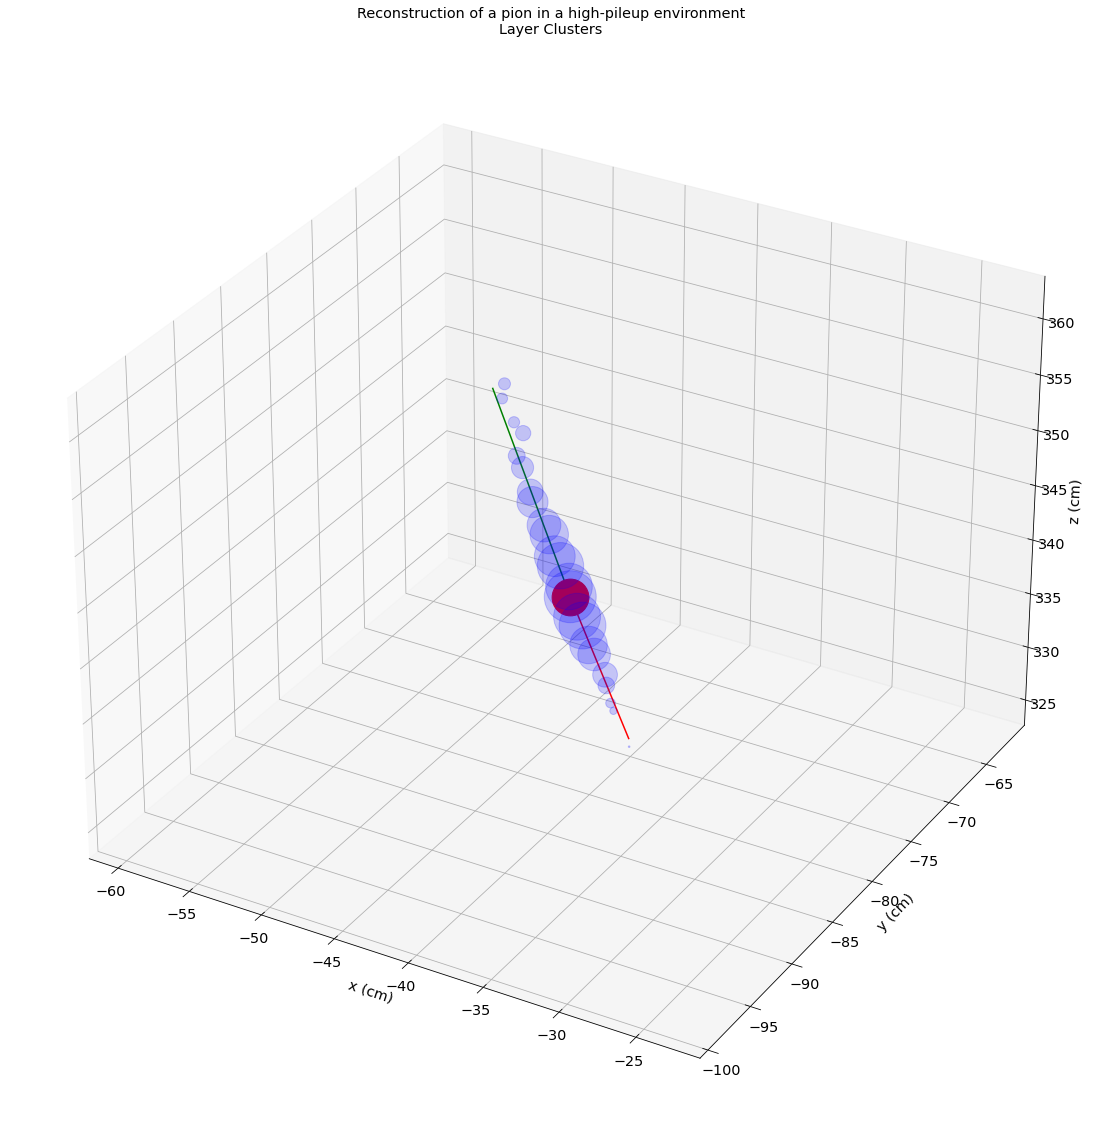

0 0.04582060546869573 3.970181003743514
1 0.11718967160878595 2.2742299599168634
2 0.1316301145313297 0.9086289899449858
3 0.020827548165873486 3.023082249728876
4 0.07858928263910266 2.3848101564537107
5 0.17300750793822567 2.585324343301179
6 0.026936960408871124 2.76764947673121
7 1.0 0.0
8 0.33857023728889457 0.47661147828688155
9 0.18476448997619624 0.6728004289079093


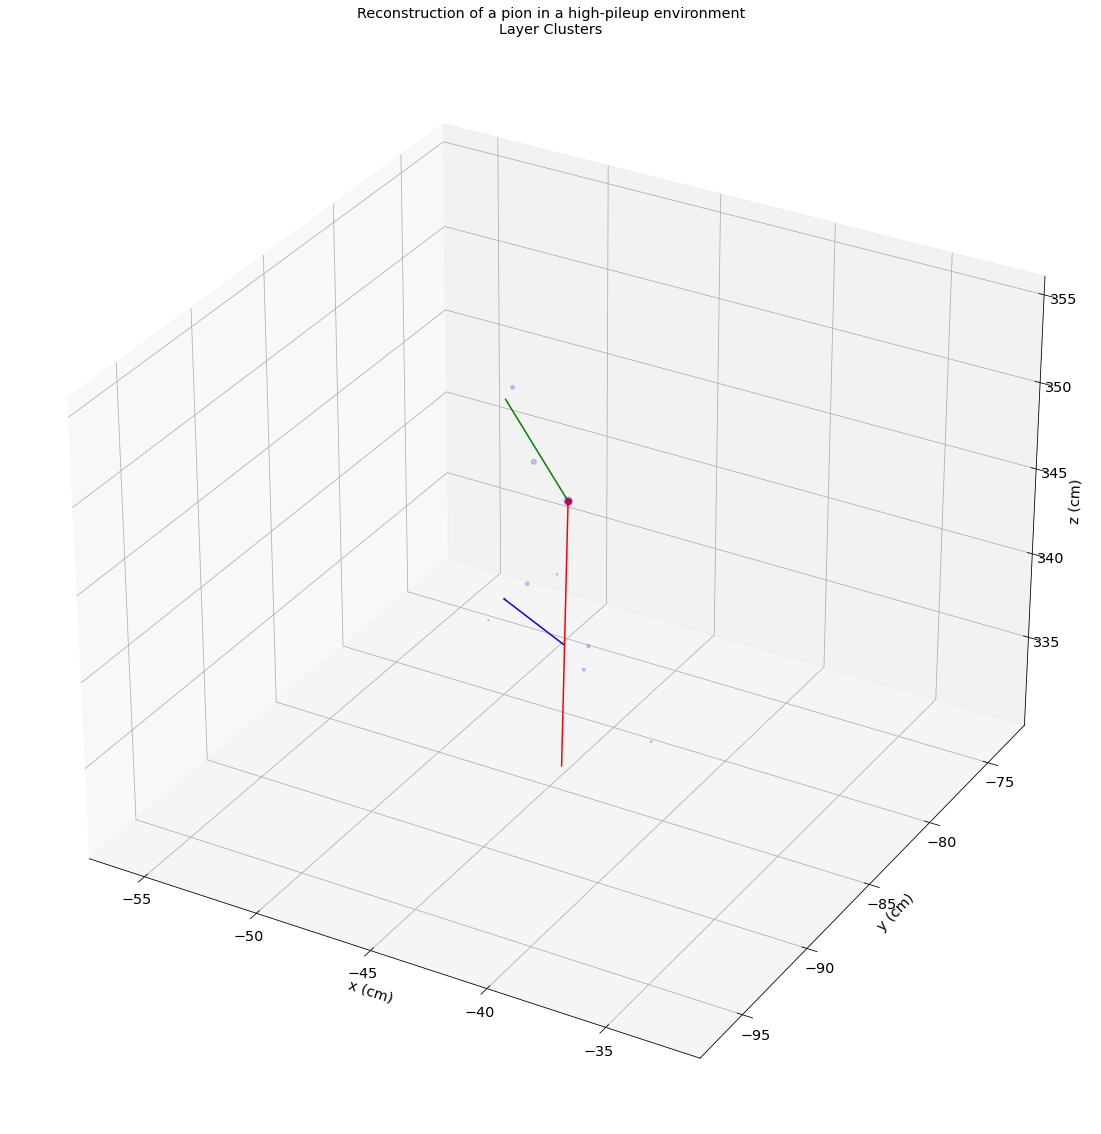

0 0.077635638226037 2.1570527046774046
1 0.6612262430861088 0.11883713994164725
2 1.0 0.0
3 0.06489992337216902 3.255424093736549
4 0.15480716020406016 3.2847245783362946
5 0.20511946965799488 0.16614492152982707
6 0.38327106834679336 0.8304255105019684
7 0.40580979007207013 0.7820687763946473
8 0.2407967646168704 3.068243215265449
9 0.18701473559782789 1.5568227792223444


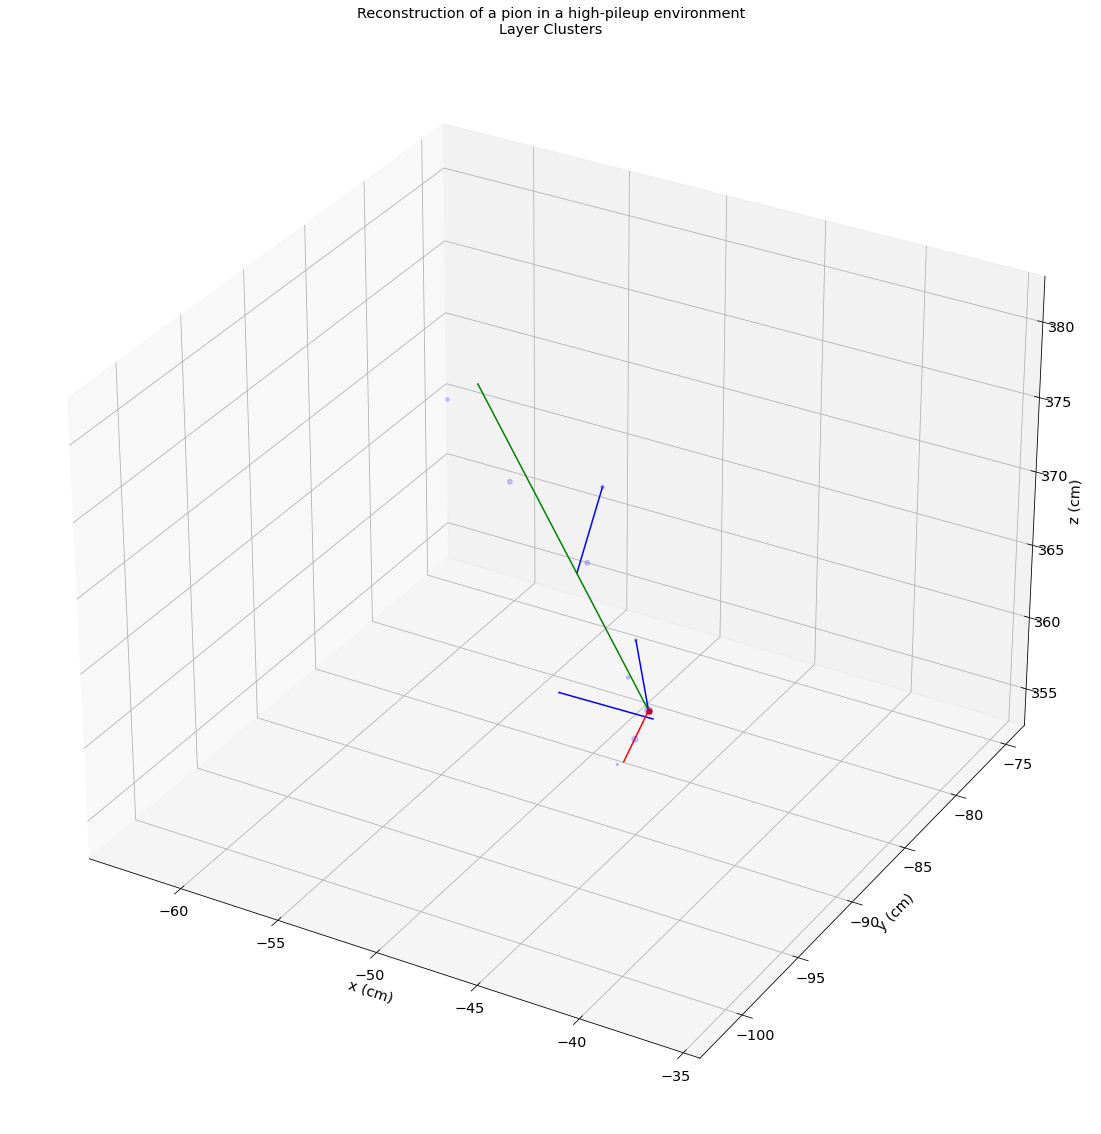

0 0.074315666281133 3.059761969402879
1 0.1614443613125534 1.6336430553698875
2 0.09196919048223742 2.510100646827595
3 0.32886817837053106 0.3432511863542072
4 0.12044261439882487 0.8968889741419467
5 0.21896072361353738 0.4033632309473834
6 0.06168381118917119 3.7324761598714438
7 1.0 0.0
8 0.15453370445239917 7.105427357601002e-15


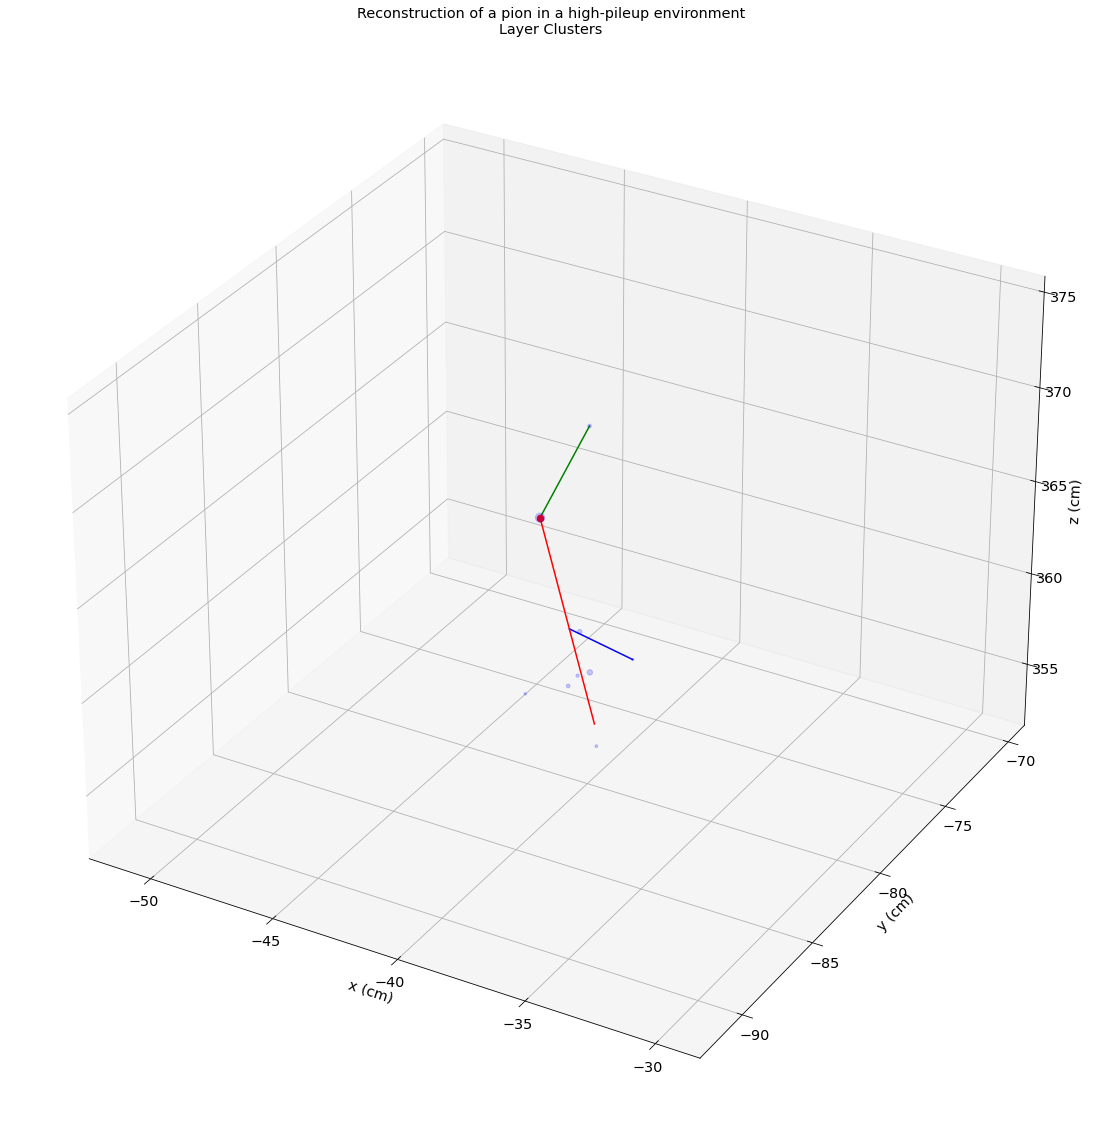

0 0.31290666656747057 1.2673668533178377
1 0.2154103652562607 0.27601028185387866
2 0.2806305241427469 4.272008826120696
3 1.0 0.0
4 0.4356898904387708 0.8959488040910175
5 0.09509981777848811 5.4993500468441825


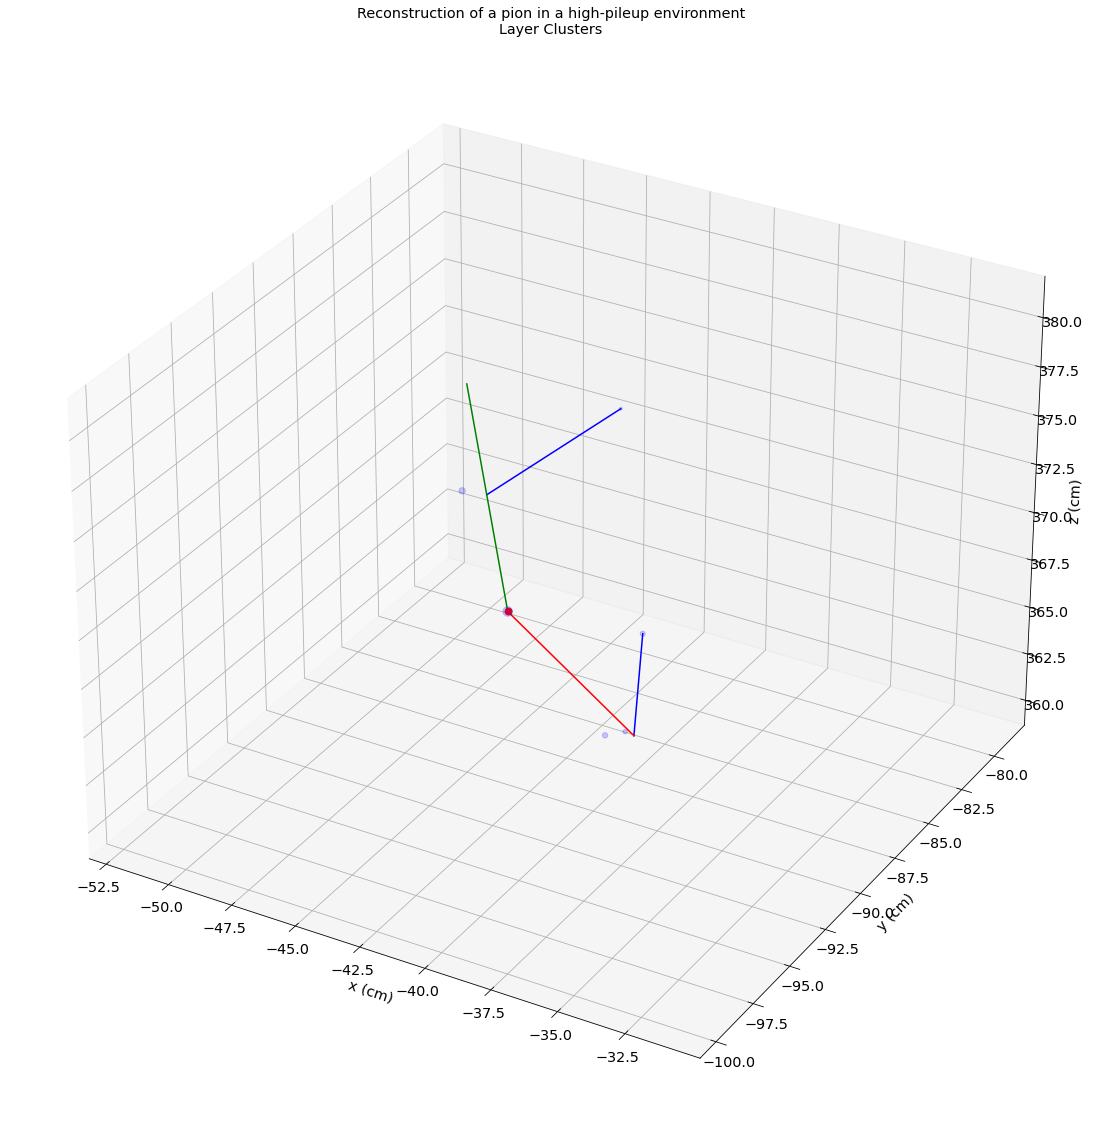

/eos/user/j/jejarosl/.local/lib/python3.9/site-packages/wpca/wpca.py:108: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = evals[::-1] / covar.trace()


0 0.34687084486699993 7.553172887309252e-14
1 1.0 0.0


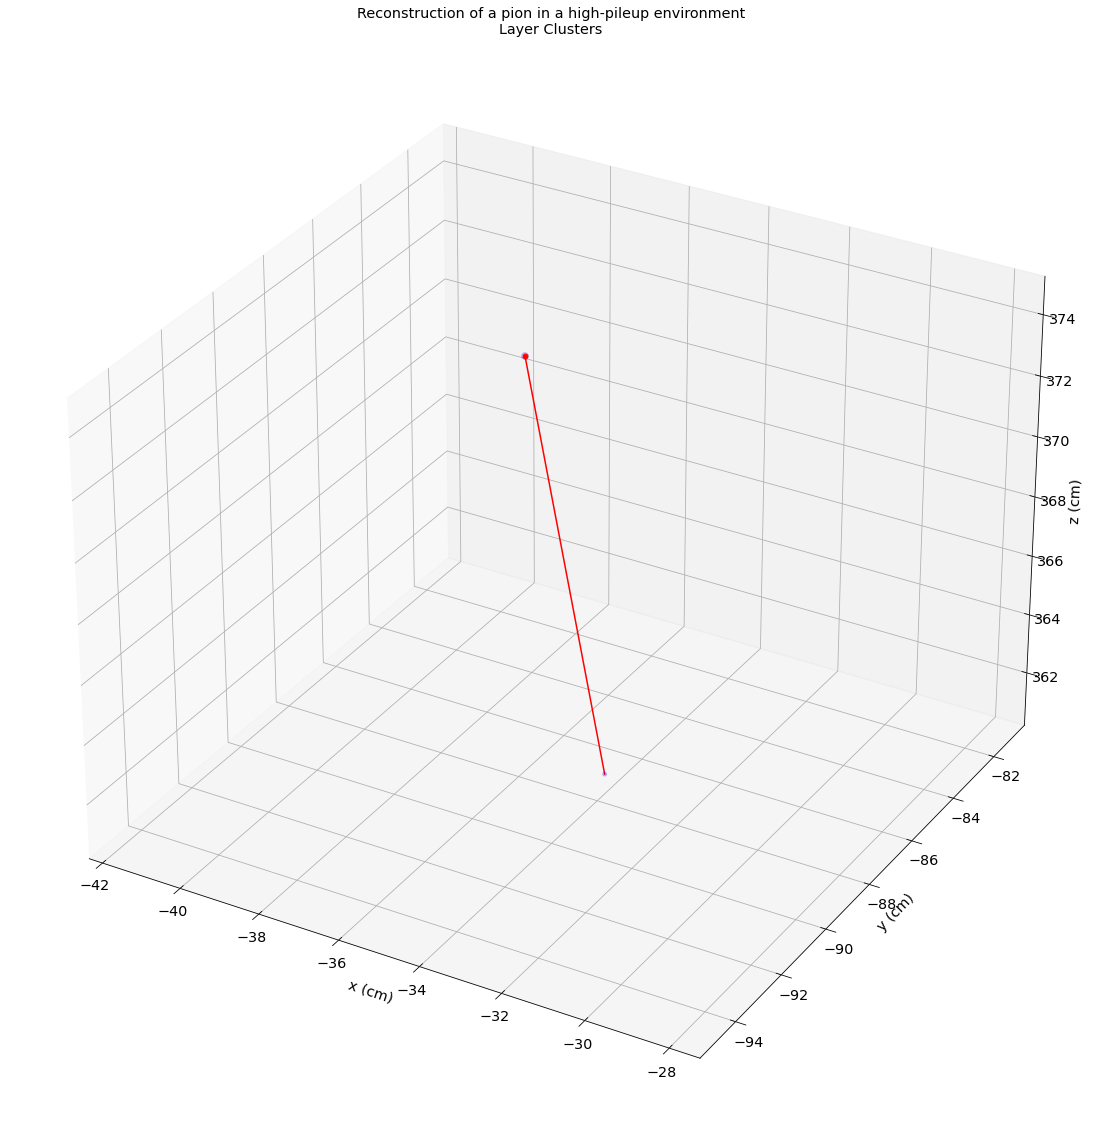

0 0.2798934814313277 4.0194366942304644e-14
1 1.0 0.0
2 0.3829560744702314 0.30851498496311675
3 0.07643142754195283 1.623126172022579


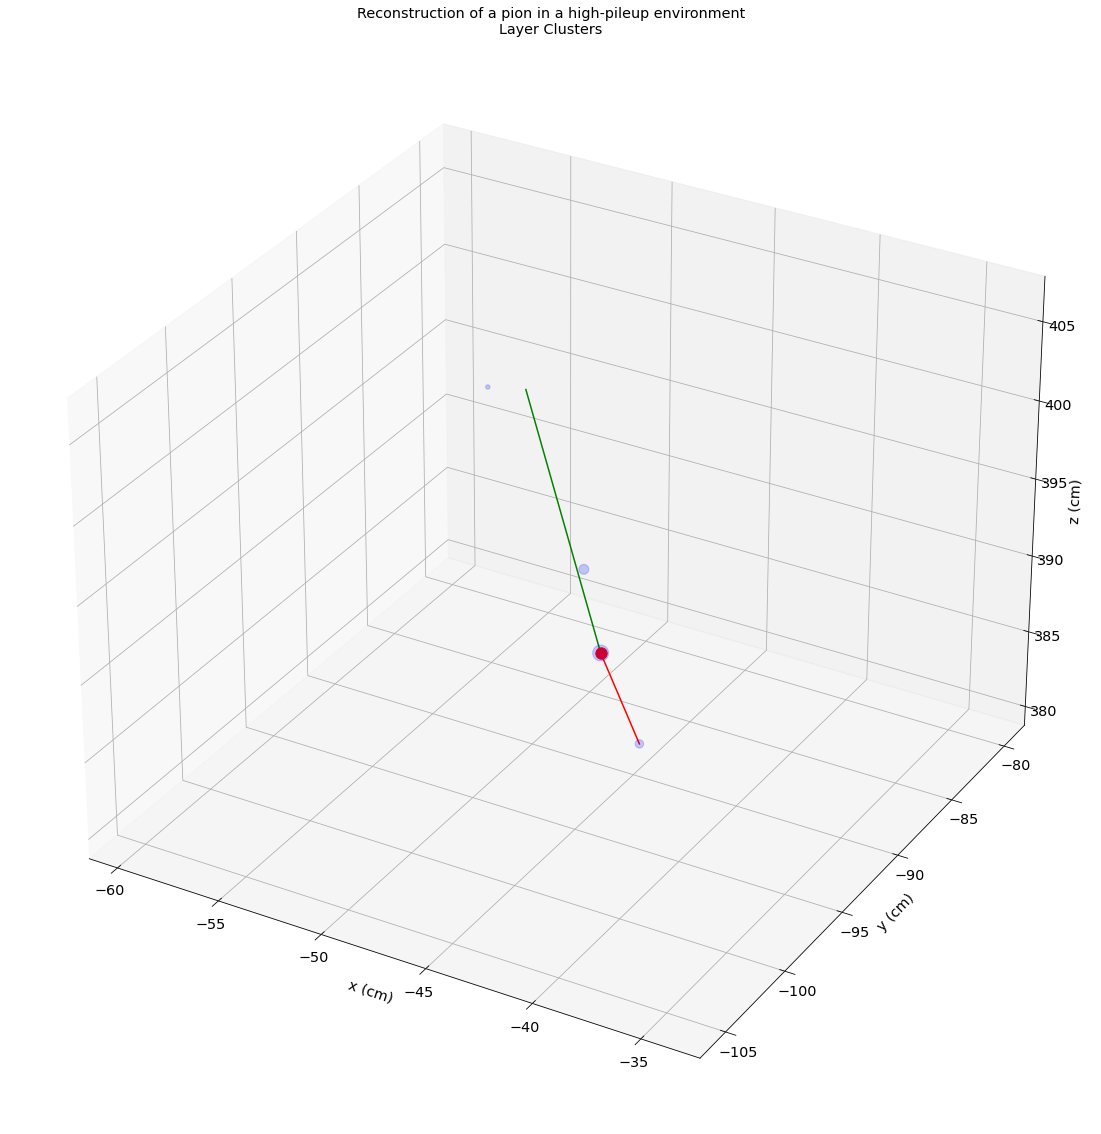

/eos/user/j/jejarosl/.local/lib/python3.9/site-packages/wpca/wpca.py:108: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = evals[::-1] / covar.trace()


0 0.07281902945427658 6.029155041345696e-14
1 1.0 0.0


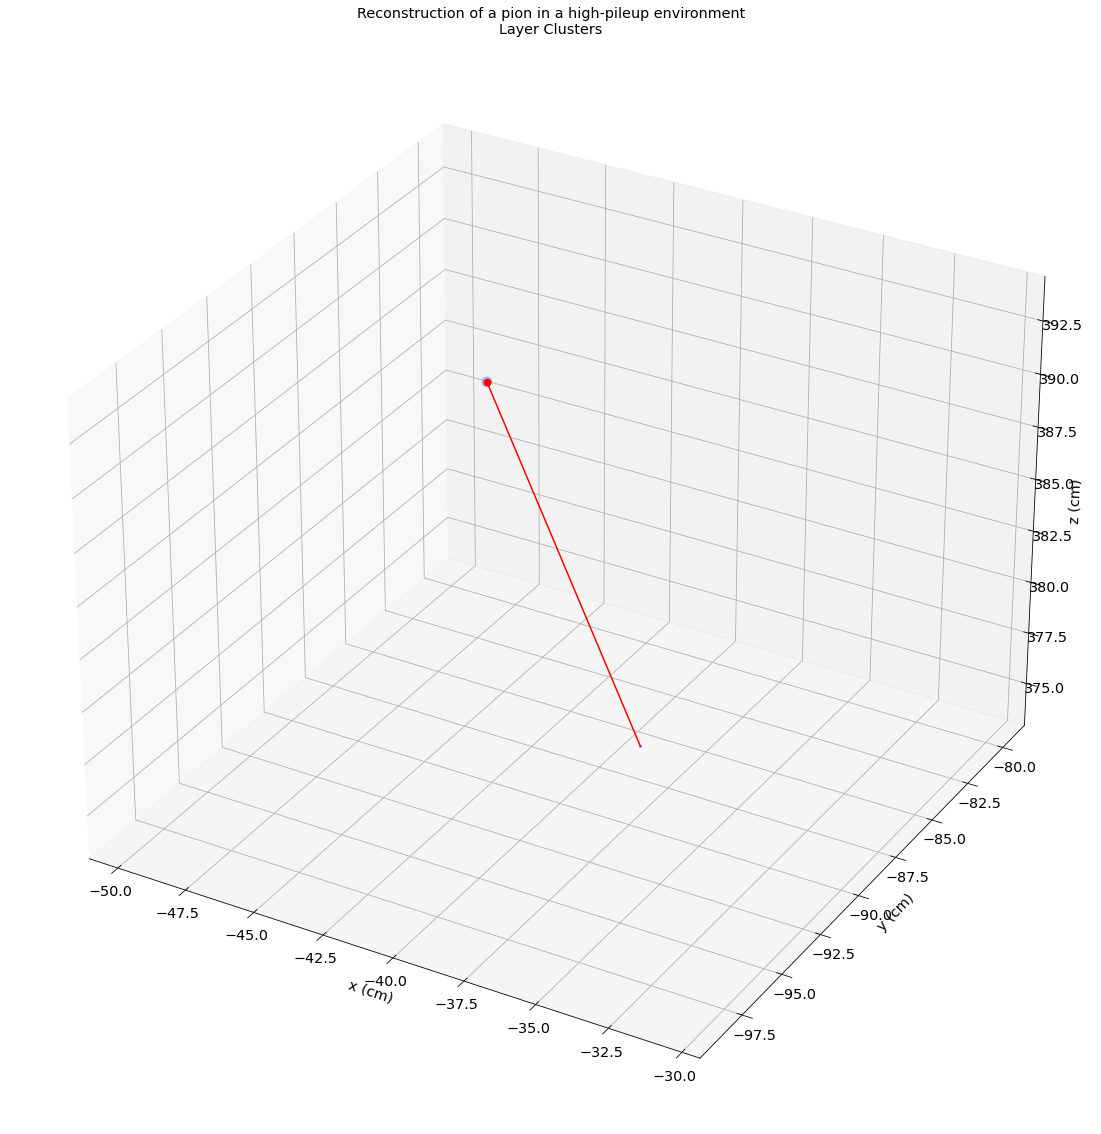

/eos/user/j/jejarosl/.local/lib/python3.9/site-packages/wpca/wpca.py:108: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = evals[::-1] / covar.trace()


0 1.0 0.0
1 0.05559619143493211 1.404952983254065
2 0.27651789845858765 0.11645059751232115


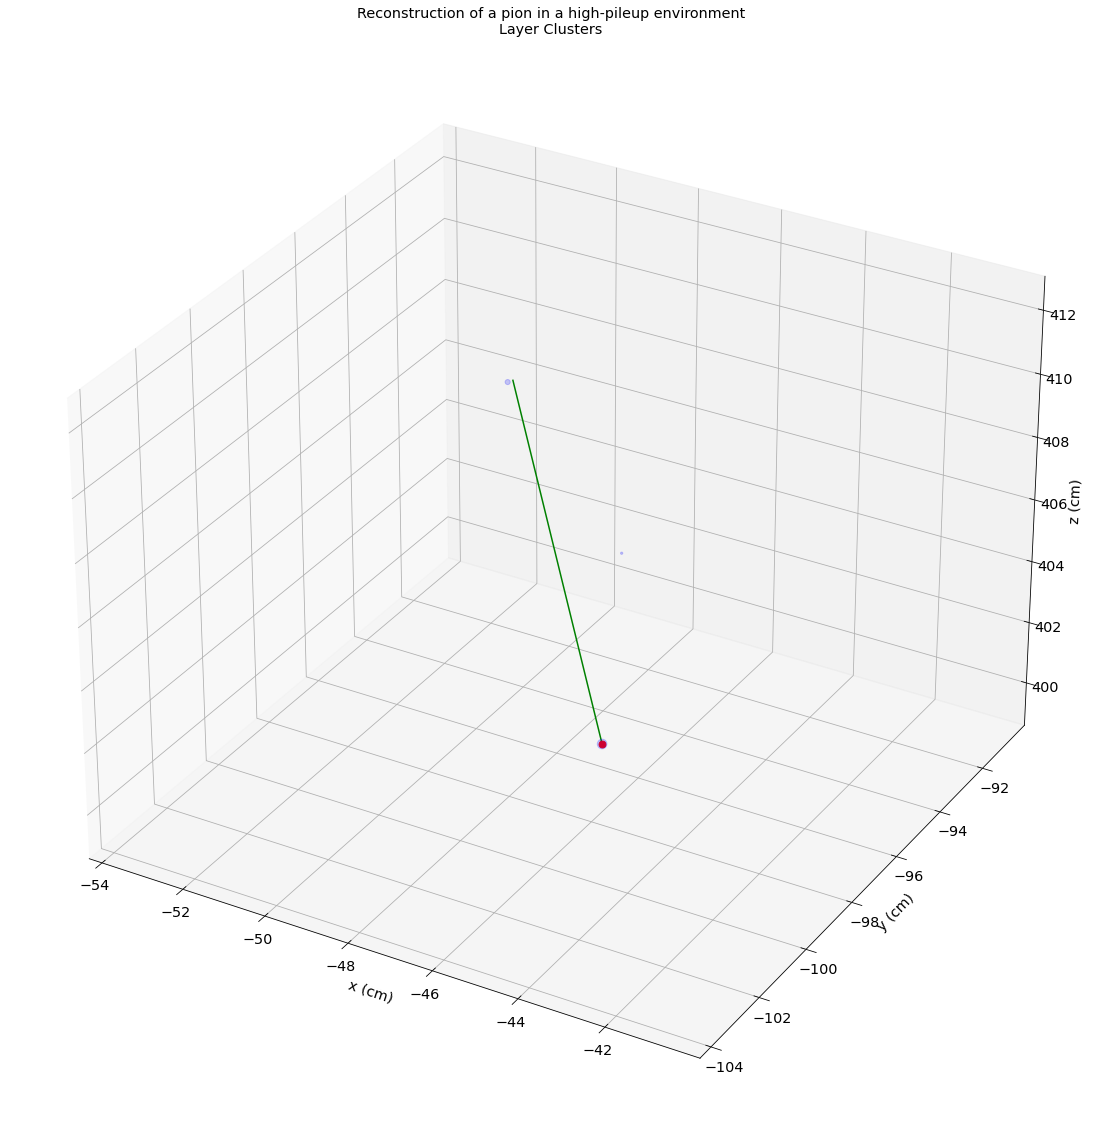

/eos/user/j/jejarosl/.local/lib/python3.9/site-packages/wpca/wpca.py:108: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = evals[::-1] / covar.trace()


0 1.0 0.0
1 0.1844215463948963 1.3705934470914483
2 0.16686707864852782 1.2794022355283206


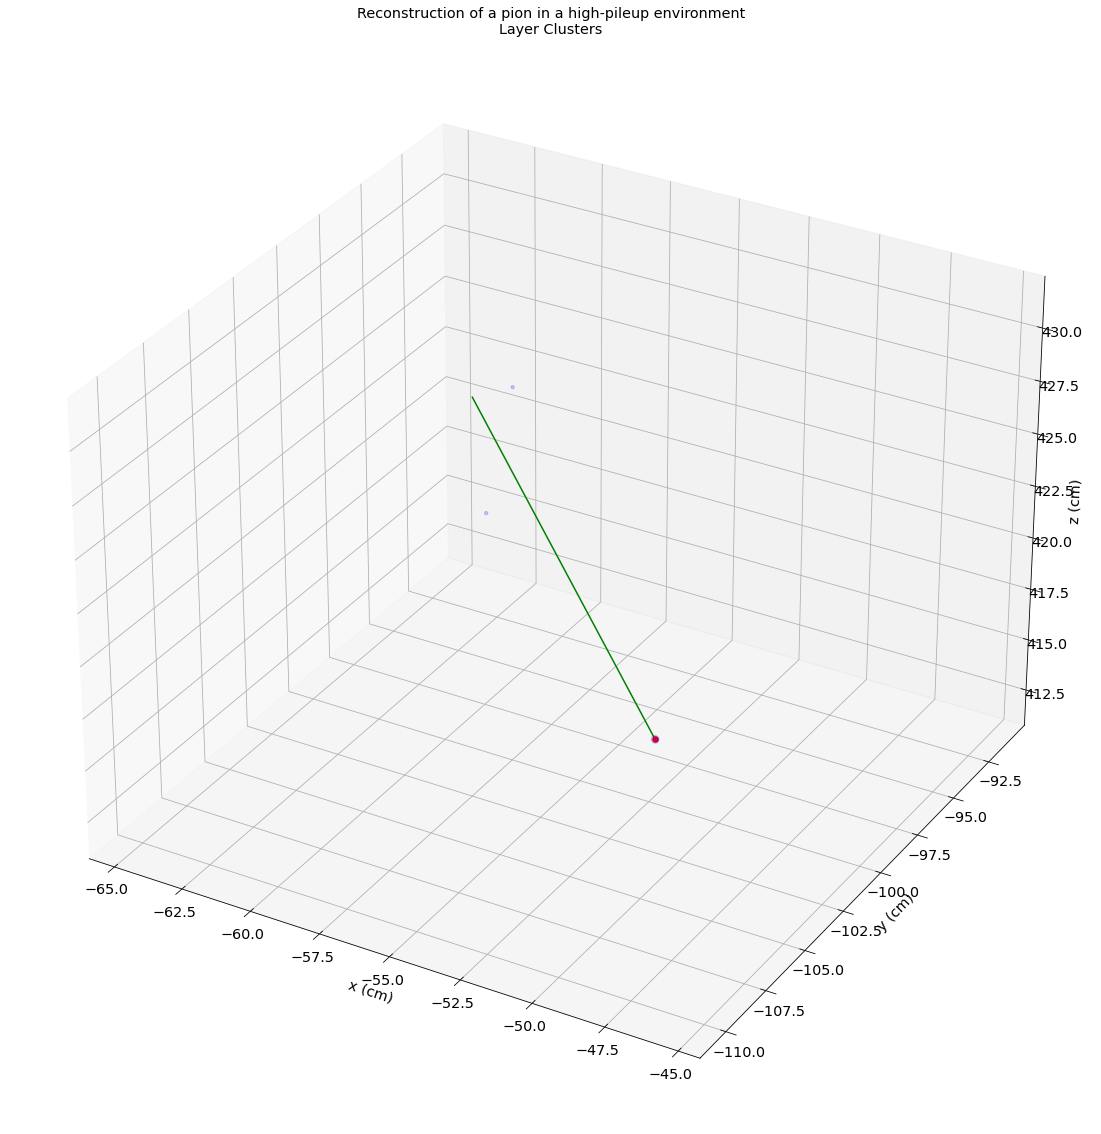

0 0.5678733269915539 0.25020231758682204
1 0.5542986320691305 1.5732833046189476
2 1.0 0.0
3 0.16515836586398477 1.5888218580782548e-14


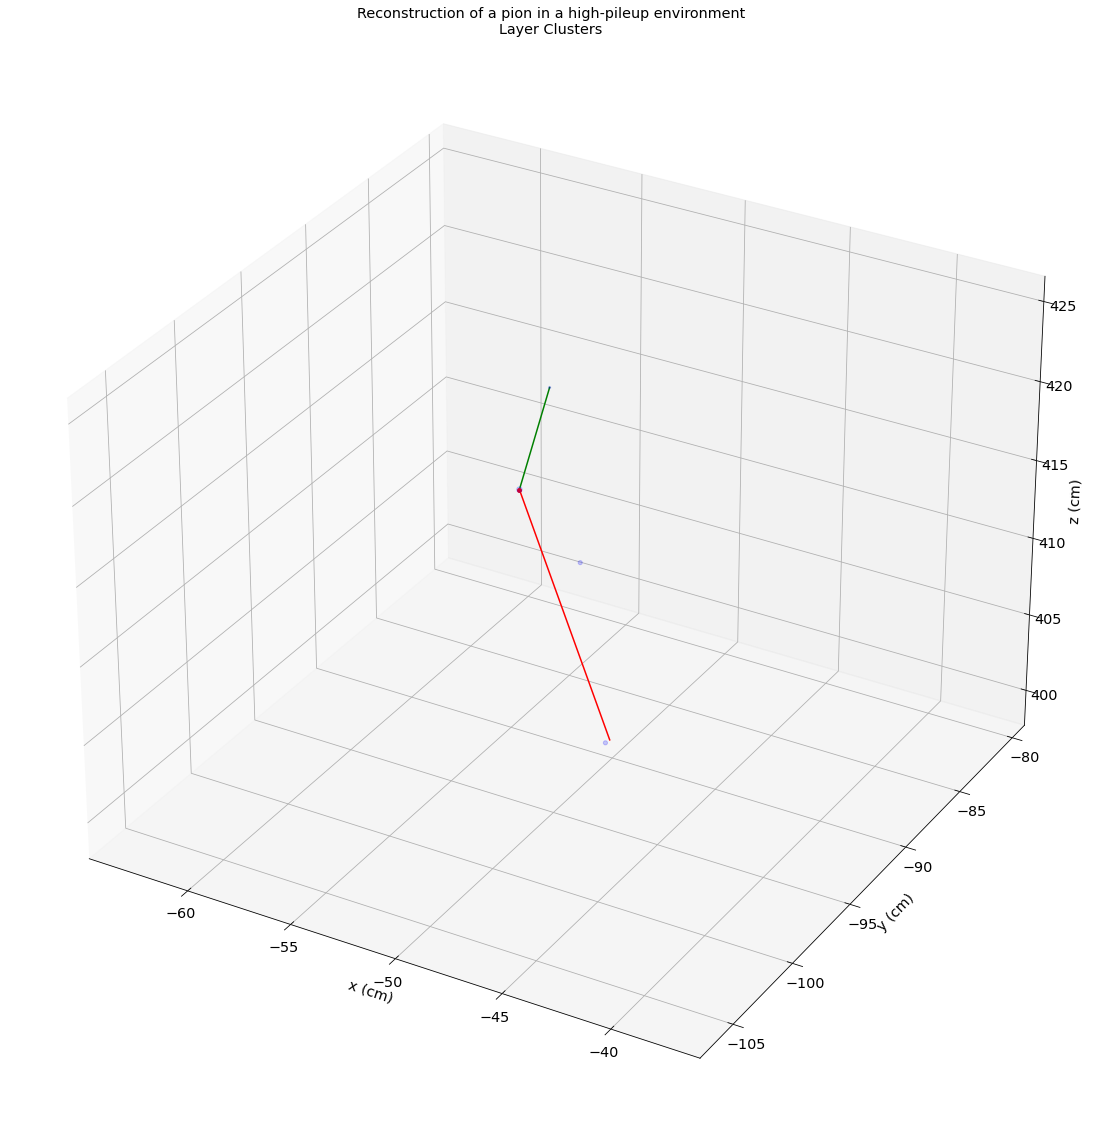

0 0.3758064390520981 7.140866117879973e-14
1 1.0 0.0
2 0.2080645203159673 1.4210854715202004e-14


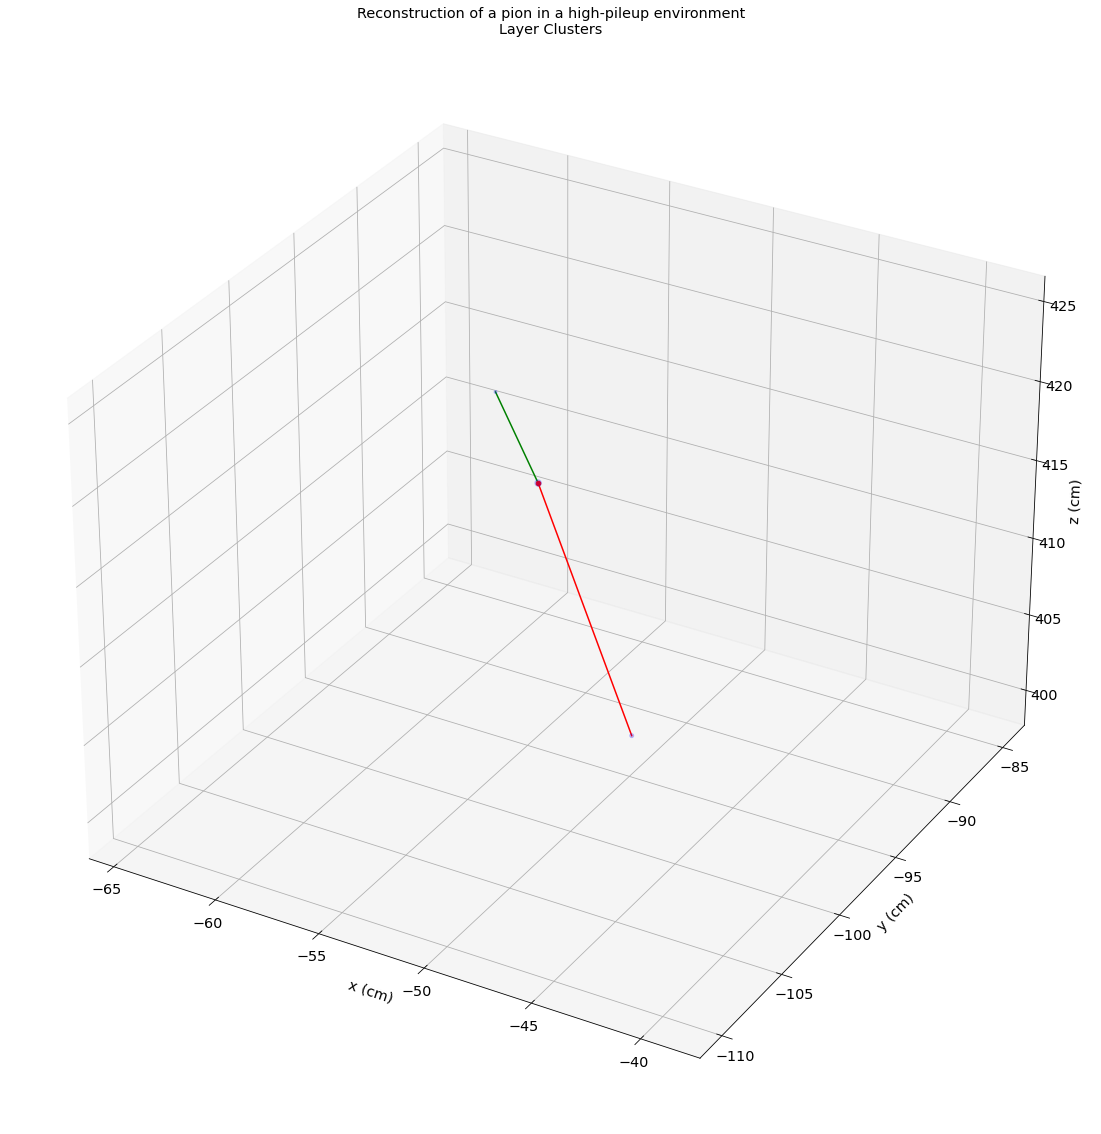

0 0.02364316483435051 4.905447408187347
1 0.02761341538544419 5.267860455950317
2 0.2721893817762442 0.9101424531776383
3 0.10650888223820565 1.3742002430265825
4 0.05719922042267394 1.8321831088253238
5 1.0 0.0
6 0.019723867616362037 4.41504989618731
7 0.06311637492728384 0.8550462005800691


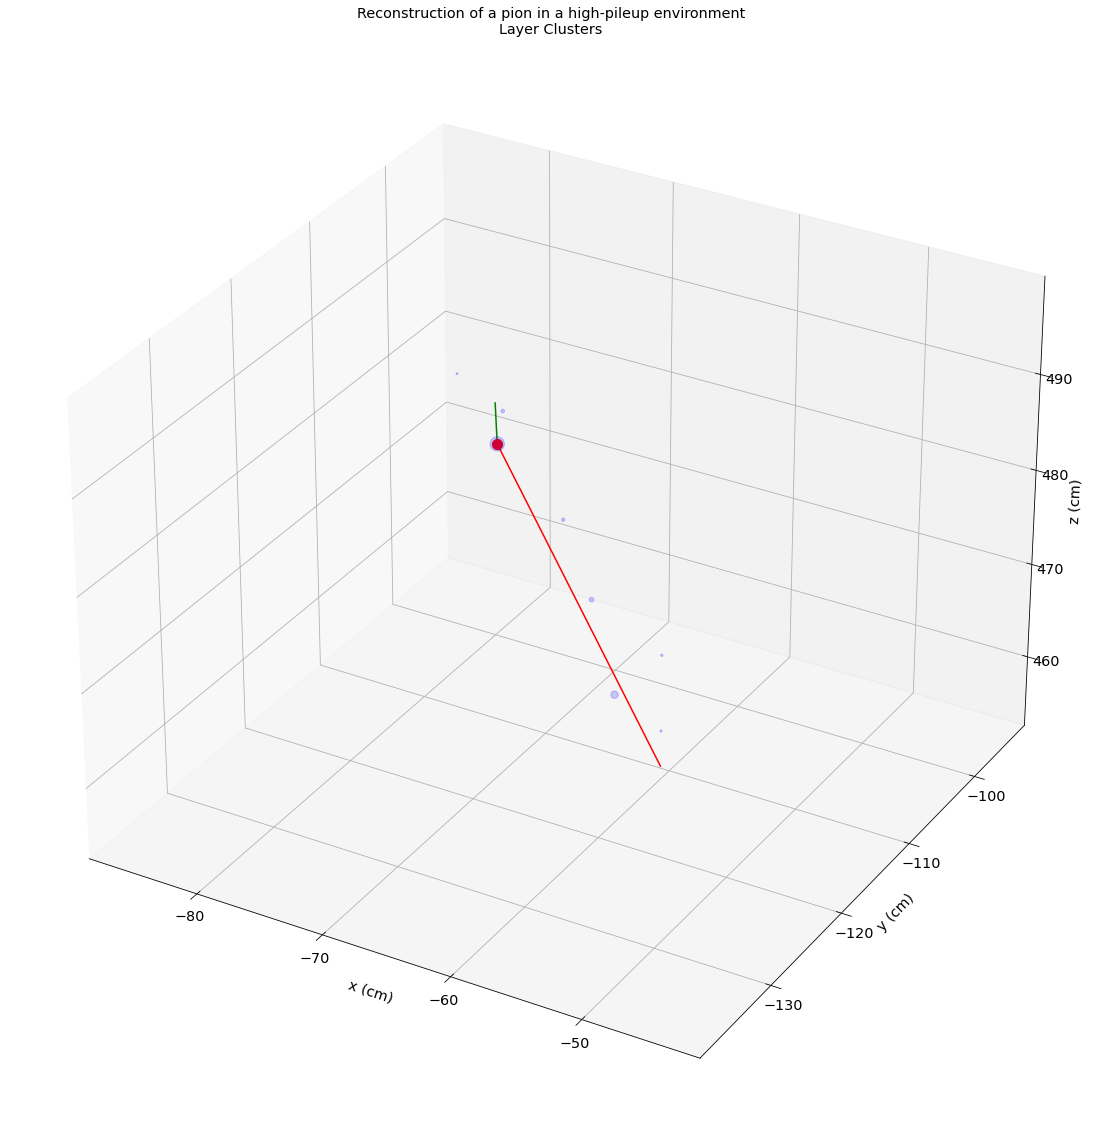

In [193]:
# create internal edges per each trackster
all_event_edges, all_event_nodes = [], []
for tr_id in range(len(bx[eid])):
    internal_trackster_edges, internal_trackster_nodes = create_tr_skeletons(vx, vy, vz, ve, vi, ev=eid,
                                                                tr_id=tr_id, DST_THR=2, bubble_size=50, NEIGHBOUR_THR=30, ENERGY_RATIO_THR=0.05)
    all_event_edges.append(internal_trackster_edges)
    all_event_nodes.append(internal_trackster_nodes)

((-41.291229248046875, -80.07343292236328, 340.49700927734375), (-41.291229248046875, -80.07343292236328, 340.49700927734375))
((-44.30204391479492, -84.79106903076172, 346.6109924316406), (-44.30204391479492, -84.79106903076172, 346.6109924316406))
((-44.276045927389696, -85.10165381291439, 338.4464688054804), (-46.033531188964844, -86.60932159423828, 341.4909973144531))
((-46.4732551574707, -86.24906158447266, 357.7510070800781), (-46.4732551574707, -86.24906158447266, 357.7510070800781))
((-46.325736623946504, -86.10348523798561, 357.12123604355884), (-49.19437789916992, -89.45763397216797, 360.1390075683594))
((-46.4732551574707, -86.24906158447266, 357.7510070800781), (-48.488067626953125, -83.83832550048828, 360.1390075683594))
((-48.82126758502516, -88.56616074851412, 367.7749016032606), (-47.36913299560547, -88.88340759277344, 374.281005859375))
((-40.14155197143555, -83.03981018066406, 367.97601318359375), (-40.14155197143555, -83.03981018066406, 367.97601318359375))
((-40.518

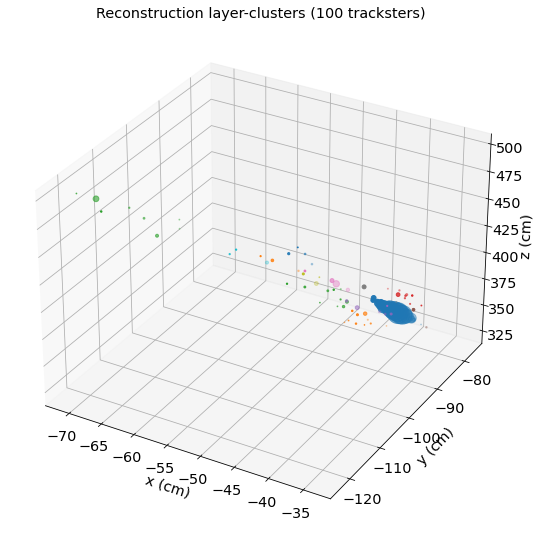

In [196]:
# Plot all of them in one figure
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121, projection='3d')

ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
ax1.set_zlabel("z (cm)")

for x, y, z, e in zip(vx[eid], vy[eid], vz[eid], ve[eid]):
    ax1.scatter(x, y, z, s=8*e)
    
for trackster_edges in all_event_edges:
    for edge in trackster_edges:
        print(edge)

ax1.set_title(f"Reconstruction layer-clusters ({len(vx)} tracksters)")
plt.show()